
# SCHISM procedural example

In this notebook we will use the SCHOSM grid, config and data objects to define a SCHISM workspace

### Frontmatter
Required inputs and defination of a few helper functions

In [1]:
# Choose grid

# hgrid_file="hgrid.gr3" # heavy grid
hgrid_file="hgrid_20kmto60km_rompyschism_testing.gr3" # testing grid

In [2]:
%load_ext autoreload
%autoreload 2

# turn off warnings
import warnings
warnings.filterwarnings('ignore')


from datetime import datetime
from pathlib import Path
from rompy.core import DataBlob, TimeRange
from shutil import rmtree
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
import pandas as pd 

import logging
logging.basicConfig(level=logging.INFO)

HERE =  Path('../../tests/schism')



### Workspace basepath

In [3]:
workdir = Path("schism_procedural")
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

### Model Grid

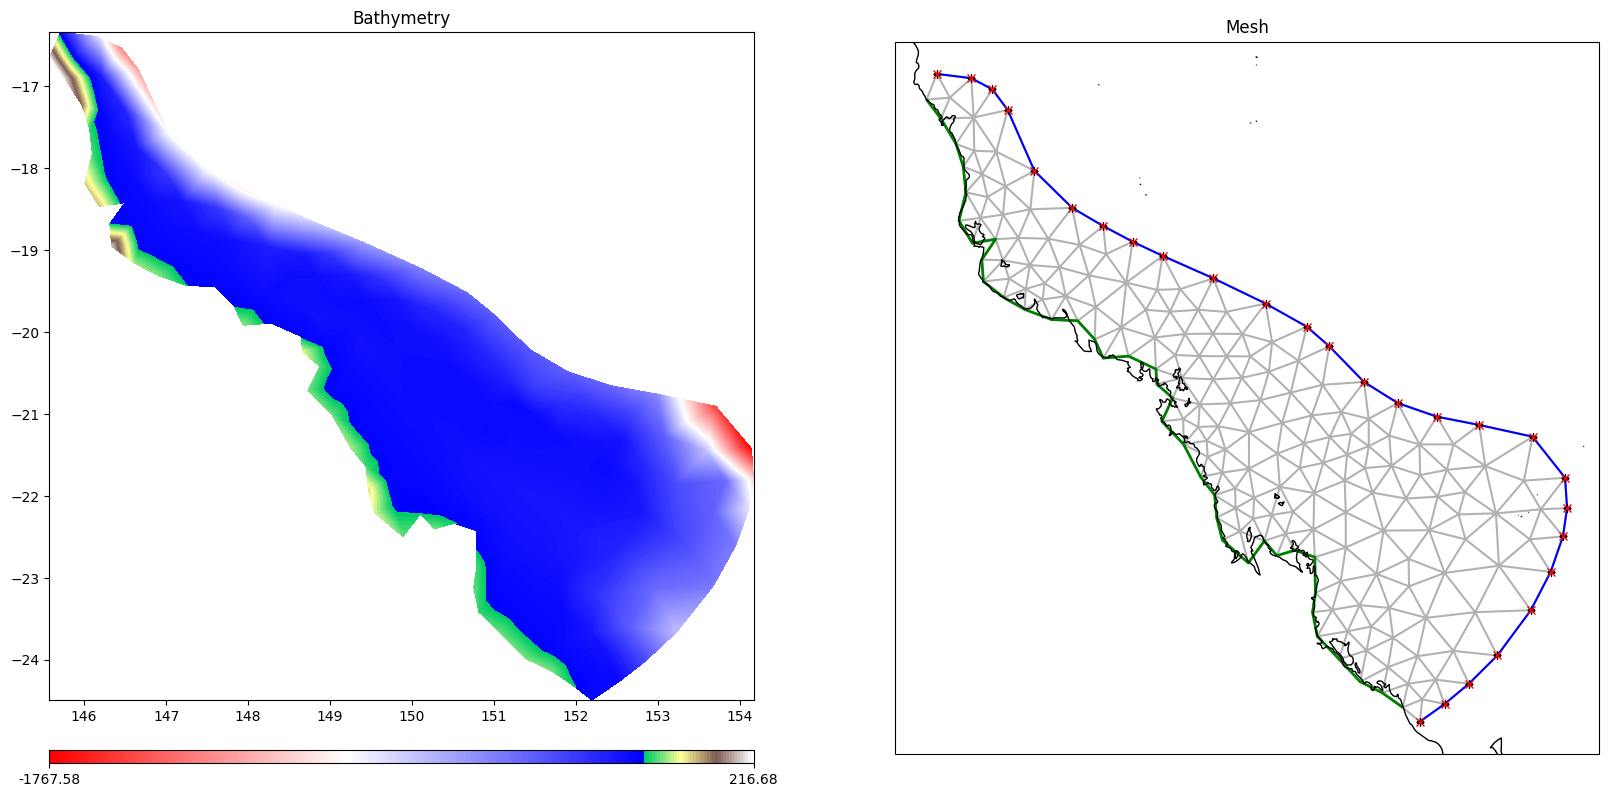

In [4]:
# Grid object

from rompy.schism import Inputs, SCHISMGrid

#SCHISMGrid?

# Medium sized grid, will run one day in about 3 minutes on 48 cores
hgrid = HERE / "test_data" / hgrid_file

# Fast running grid, will run in about 1 minute on 4 cores
#hgrid = HERE / "test_data" / "hgrid_20kmto60km_rompyschism_testing.gr3"

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),
    drag=1,
)

grid.plot_hgrid()

In [5]:
grid.get(workdir)
list(workdir.glob('*'))

INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated drag with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/hgrid.ll
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/hgrid_WWM.gr3


[PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/tvd.prop')]


# Forcing data

In [6]:
# First lists import the main data classes
from rompy.schism.data import SCHISMDataSflux, SCHISMDataOcean, SCHISMDataWave, SCHISMDataTides

# Sets also import a few of the minor classes that are used in the construction of these main classes for use in this demo
from rompy.schism.data import SfluxSource, TidalDataset, SfluxAir, SCHISMDataBoundary

# And also lets import some of the core data source objects. These are data input abstractions that work in exactly the same way as 
# with the swan classes, and can be used interchangeably in each of the data classes depending on the data source. We will use a 
# bit of a mix here for illustration purposes.
from rompy.core.data import DataBlob
from rompy.core.source import SourceFile, SourceDataset, SourceIntake, SourceDatamesh, SourceWavespectra

### Sflux Data

In [7]:
from rompy.schism.namelists import Sflux_Inputs
# SCHISMDataSflux??
# SfluxSource??
# Sflux_Inputs??



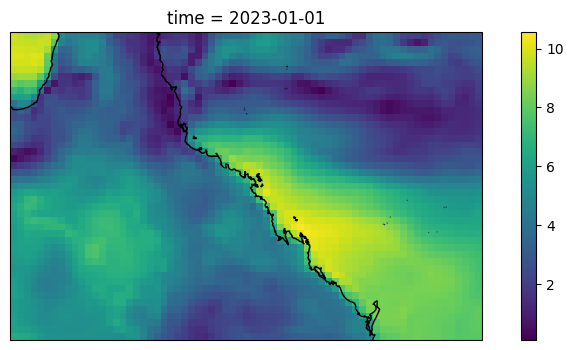

In [8]:
import intake
nn = 0
cat = intake.open_catalog(HERE / ".." / "data" / "catalog.yaml")
ds = xr.open_dataset(HERE/ "test_data" / "era5.nc")
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree())
(np.sqrt(ds.u10[nn]**2 + ds.v10[nn]**2)).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [9]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 73, latitude: 45, longitude: 69)
Coordinates:
  * latitude   (latitude) float32 180B -15.0 -15.25 -15.5 ... -25.5 -25.75 -26.0
  * longitude  (longitude) float32 276B 140.0 140.2 140.5 ... 156.5 156.8 157.0
  * time       (time) datetime64[ns] 584B 2023-01-01 ... 2023-01-04
Data variables:
    msl        (time, latitude, longitude) float32 907kB ...
    u10        (time, latitude, longitude) float32 907kB ...
    v10        (time, latitude, longitude) float32 907kB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-11-10T00:18 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           907700
    _domain_size:            226665

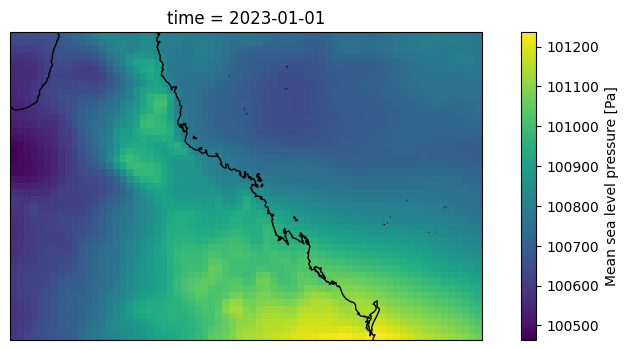

In [10]:
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.msl[nn].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [11]:
# Lets have a look at an flux object. Here we will use a ERA5 dataset exposed through the intake catalog in the tests/data folder.
from rompy.core.time import TimeRange

atmos_forcing = SCHISMDataSflux(
    air_1=SfluxAir(
        id="air_1",
        source=SourceFile(
            uri=HERE / "test_data" / "era5.nc",
        ),
        uwind_name='u10',
        vwind_name='v10',
        prmsl_name='msl',
        filter={
            "sort": {"coords": ["latitude"]},
        },
    buffer=2
    )
)
atmos_forcing.get(destdir=workdir, grid=grid, time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600))

INFO:rompy.schism.data:Fetching air_1


In [12]:
# Lets check the workdir again, we should see some prepared sflux inputs

list(workdir.glob('**/*'))

[PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/tvd.prop'),
 PosixPath('schism_procedural/sflux/air_1.0001.nc'),
 PosixPath('schism_procedural/sflux/sflux_inputs.txt')]

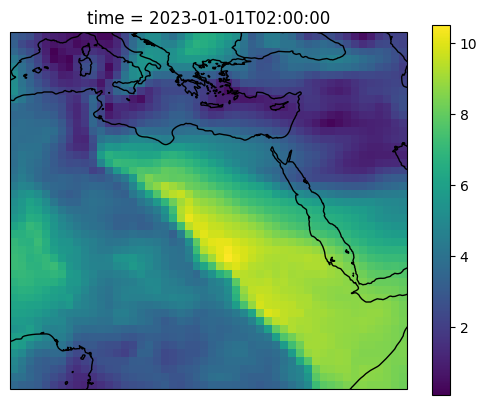

In [13]:
# Create a map
ax = plt.axes(projection=ccrs.PlateCarree())
# load the data
ds = xr.open_dataset("schism_procedural/sflux/air_1.0001.nc")
wind_speed = np.sqrt(ds.u10**2 + ds.v10**2)
# plot the data
wind_speed.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Ocean Boundary

In [14]:
#SCHISMDataOcean??

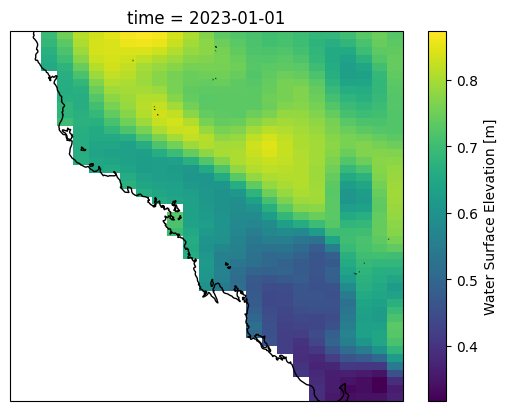

In [15]:
ds = xr.open_dataset(HERE / "test_data" / "hycom.nc")
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [16]:

ocean_forcing = SCHISMDataOcean(
                elev2D = SCHISMDataBoundary(
                    id="hycom",
                    source=SourceFile(
                        uri=HERE / "test_data" / "hycom.nc",
                    ),
                    variable="surf_el",
                    coords={"t": "time", "y": "ylat", "x": "xlon", "z": "depth"},
                    interpolate_missing_coastal=True,
                    ),
                )



In [17]:
ocean_forcing.get(destdir=workdir, grid=grid)
list(workdir.glob("*"))



INFO:rompy.schism.data:Fetching elev2D


[PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/elev2D.th.nc'),
 PosixPath('schism_procedural/tvd.prop')]

In [18]:
dsb = xr.open_dataset('schism_procedural/elev2D.th.nc')
dsb.time[0]

<xarray.DataArray 'time' ()> Size: 8B
array('2023-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-01-01
Attributes:
    long_name:      Time
    standard_name:  time
    base_date:      [2023    1    1    0    0    0]

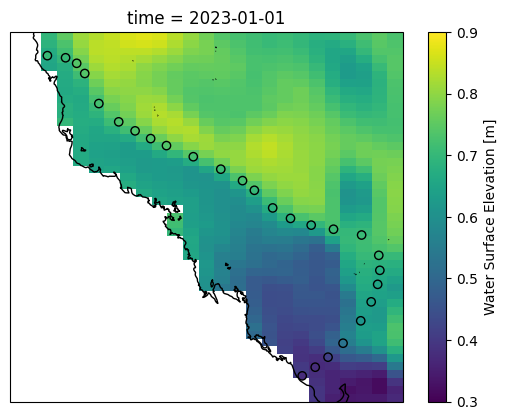

In [19]:
vmin, vmax = 0.3, 0.9
time = dsb.time[0]
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].sel(time=time).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
ax.coastlines()
values = dsb.time_series.isel(time=0)
x,y = grid.boundary_points()
ax.scatter(x, y, transform=ccrs.PlateCarree(), c=values, cmap="viridis", vmin=vmin, vmax=vmax, edgecolor="black")

# Check for nans (there shouldn't be any)
# nans = dsb.time_series.isel(time=0).isnull().squeeze()
# ax.scatter(x[nans], y[nans], transform=ccrs.PlateCarree(), c="red", edgecolor="black")

In [20]:
ocean_forcing.elev2D.ds

<xarray.Dataset> Size: 10kB
Dimensions:  (time: 2, ylat: 47, xlon: 25)
Coordinates:
  * ylat     (ylat) float64 376B -25.04 -24.84 -24.64 ... -16.24 -16.04 -15.84
  * xlon     (xlon) float64 200B 145.0 145.4 145.8 146.2 ... 153.8 154.2 154.6
  * time     (time) datetime64[ns] 16B 2023-01-01 2023-01-02
Data variables:
    surf_el  (time, ylat, xlon) float32 9kB ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    history:                   Thu Dec 21 12:28:25 2023: ncrcat hycom_2023010...
    comment:                   p-grid
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1
    NCO:                       netCDF Operators version 5.1.8 (Homepage = htt...

### Wave

In [21]:
# SCHISMDataWave??

In [22]:
wave_forcing = SCHISMDataWave(
        id="wavedata",
        source=SourceIntake(
            dataset_id="ausspec",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        coords={'x': "lon", 'y': "lat"},
)


<GeoAxes: >

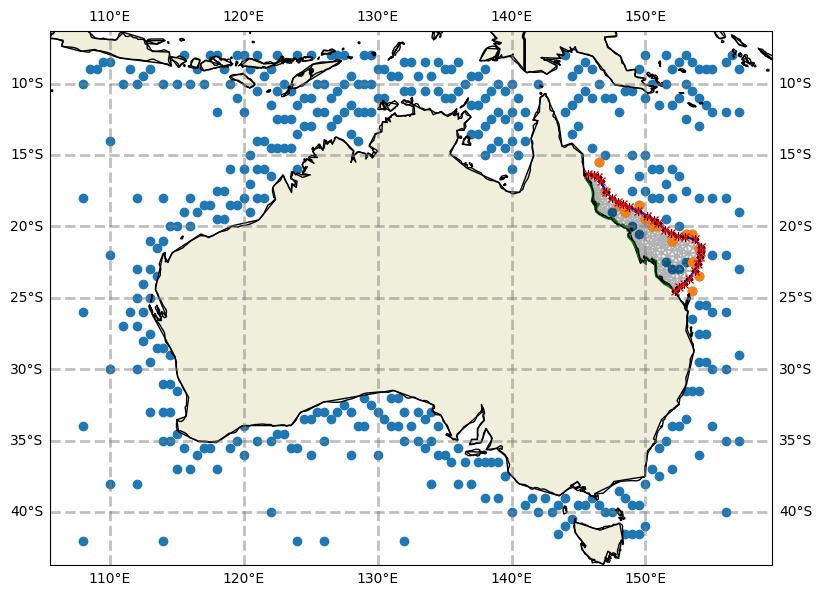

In [23]:
ax = wave_forcing.plot(model_grid=grid)
wave_forcing.plot_boundary(ax=ax, grid=grid)

### Tidal data

In [24]:
# SCHISMDataTides?
# TidalDataset?

In [25]:
tidal_forcing = SCHISMDataTides(
    tidal_data=TidalDataset(
        elevations=HERE / "test_data"/ "tpxo9-neaus" / "h_m2s2n2.nc",
        velocities=HERE / "test_data"/ "tpxo9-neaus" / "u_m2s2n2.nc" 
    ),
    constituents=["M2", "S2", "N2"],
    cutoff_depth=50,
    flags=[[5, 3, 0, 0]]
)
tidal_forcing.get(
    destdir=workdir,
    grid=grid,
    time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600),
)



INFO:rompy.schism.data:Generating tides
INFO:pyschism.forcing.bctides.bctides:Processing boundary 1:
INFO:pyschism.forcing.bctides.bctides:Elevation type: 5
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent M2.
INFO:pyschism.forcing.bctides.tpxo:h_file is ../../tests/schism/test_data/tpxo9-neaus/h_m2s2n2.nc
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent N2.
INFO:pyschism.forcing.bctides.bctides:Velocity type: 3
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent M2.
INFO:pyschism.forcing.bctides.tpxo:u_file is ../../tests/schism/test_data/tpxo9-neaus/u_m2s2n2.nc
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent N2.
INFO:pyschism.forcing.bctides.bctides:Temperature type: 0
INFO:pyschism.forcing.bctides.bctides:Salinity type: 0
INFO:pys

# Full config object

In [26]:

# Instantiate a config object

from rompy.schism import SchismCSIROConfig
from rompy.schism.data import SCHISMData
from pydantic import ValidationError
try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)

1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([152....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


In [27]:
# That gives us an expected error due to teh fact that we have a validator checking required inputs
# Lets fix the grid issue and try again

try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)


# Again we get a validation error, the hgrid_WWM is missing. Lets add it and try again

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),
    manning=1,
)
config=SchismCSIROConfig(
    grid=grid,
    mesbf=1,
    fricc=0.067,
    param_iof_hydro1=1, # elevation
    param_iof_hydro14=1, # wind speed
    param_iof_hydro16=1, # surface velocities
    wwm18=1, # peak wave direction
    wwm1=1, # significant wave height
    wwm9=1, # peak period
    data=SCHISMData(
        atmos=atmos_forcing, 
        ocean=ocean_forcing, 
        wave=wave_forcing, 
        tides=tidal_forcing
        ),
)


1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([152....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


# Model Run

Note  that most fields are optional, this sample using defaults values.


### Generate workspace


In [28]:
#if workdir.exists():
#    rmtree(workdir)

#workdir.mkdir(exist_ok=True)

from rompy.model import ModelRun
from rompy.schism import SchismCSIROConfig

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 1, 12), interval="1h"),
    output_dir=str(workdir),
    config=config
)

rundir = run()


INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: 1:00:00
	Include End: True

output_dir: schism_procedural
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_procedural
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/test_schis

In [29]:
#wave_forcing = DataBlob(id="wavedata", source="../../tests/data/wavedata.nc")

### Run schism
(Note that paths to schism binaries will have to be updated)

In [30]:
# Run the model 
# !cd schism_procedural/test_schism && mpirun -np 4 /source/schism/src/schism_VL_WWM_v59 1
# Combine outputs
# !cd schism_procedural/test_schism/outputs && /source/schism/src/Utility/Combining_Scripts/combine_output11.exe  -b 1 -e 1

# Use docker
!docker run -v ./schism_procedural/test_schism:/tmp/schism  schism mpiexec -np 8 --allow-run-as-root pschism_git_HYDRO_VL_WWM 1
!docker run -v ./schism_procedural/test_schism/outputs:/tmp/schism  schism  combine_output11 -b 1 -e 1

Begin:    1, End:    1, dry flag:    0
 combine all variables


### Check results

In [31]:
list(Path(f"{rundir}/outputs").glob("*"))


[PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/maxelev_0003'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/schout_0000_1.nc'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/schout_0007_1.nc'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/readme.md'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/local_to_global_0007'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/maxdahv_0007'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/schout_0006_1.nc'),
 PosixPath('/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_procedural/test_schism/outputs/flux.out'),
 PosixPath(

In [32]:
#load schism files

from rompy.schism.utils import schism_load, schism_plot


schfile=('schism_procedural/test_schism/outputs/schout_1.nc')
schout,meshtri=schism_load(schfile)
lons = schout.SCHISM_hgrid_node_y.values
lats = schout.SCHISM_hgrid_node_x.values
schout

<xarray.Dataset> Size: 207kB
Dimensions:                  (time: 12, one: 1, nSCHISM_hgrid_face: 317,
                              nMaxSCHISM_hgrid_face_nodes: 4,
                              nSCHISM_hgrid_edge: 508, two: 2,
                              nSCHISM_hgrid_node: 192, sigma: 2,
                              nSCHISM_vgrid_layers: 2)
Coordinates:
  * time                     (time) datetime64[ns] 96B 2023-01-01T01:00:00 .....
  * sigma                    (sigma) float32 8B -1.0 0.0
Dimensions without coordinates: one, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes,
                                nSCHISM_hgrid_edge, two, nSCHISM_hgrid_node,
                                nSCHISM_vgrid_layers
Data variables: (12/35)
    SCHISM_hgrid             (one) int32 4B ...
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 10kB ...
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) int32 4kB ...
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 2kB 152.2 ... 145.6
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 2kB -24.49 ... -16.67
    node_bottom_index        (nSCHISM_hgrid_node) int32 768B ...
    ...                       ...
    WWM_2                    (time, nSCHISM_hgrid_node) float32 9kB ...
    WWM_10                   (time, nSCHISM_hgrid_node) float32 9kB ...
    WWM_11                   (time, nSCHISM_hgrid_node) float32 9kB ...
    WWM_18                   (time, nSCHISM_hgrid_node) float32 9kB ...
    WWM_19                   (time, nSCHISM_hgrid_node) float32 9kB ...
    WWM_20                   (time, nSCHISM_hgrid_node) float32 9kB ...
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...

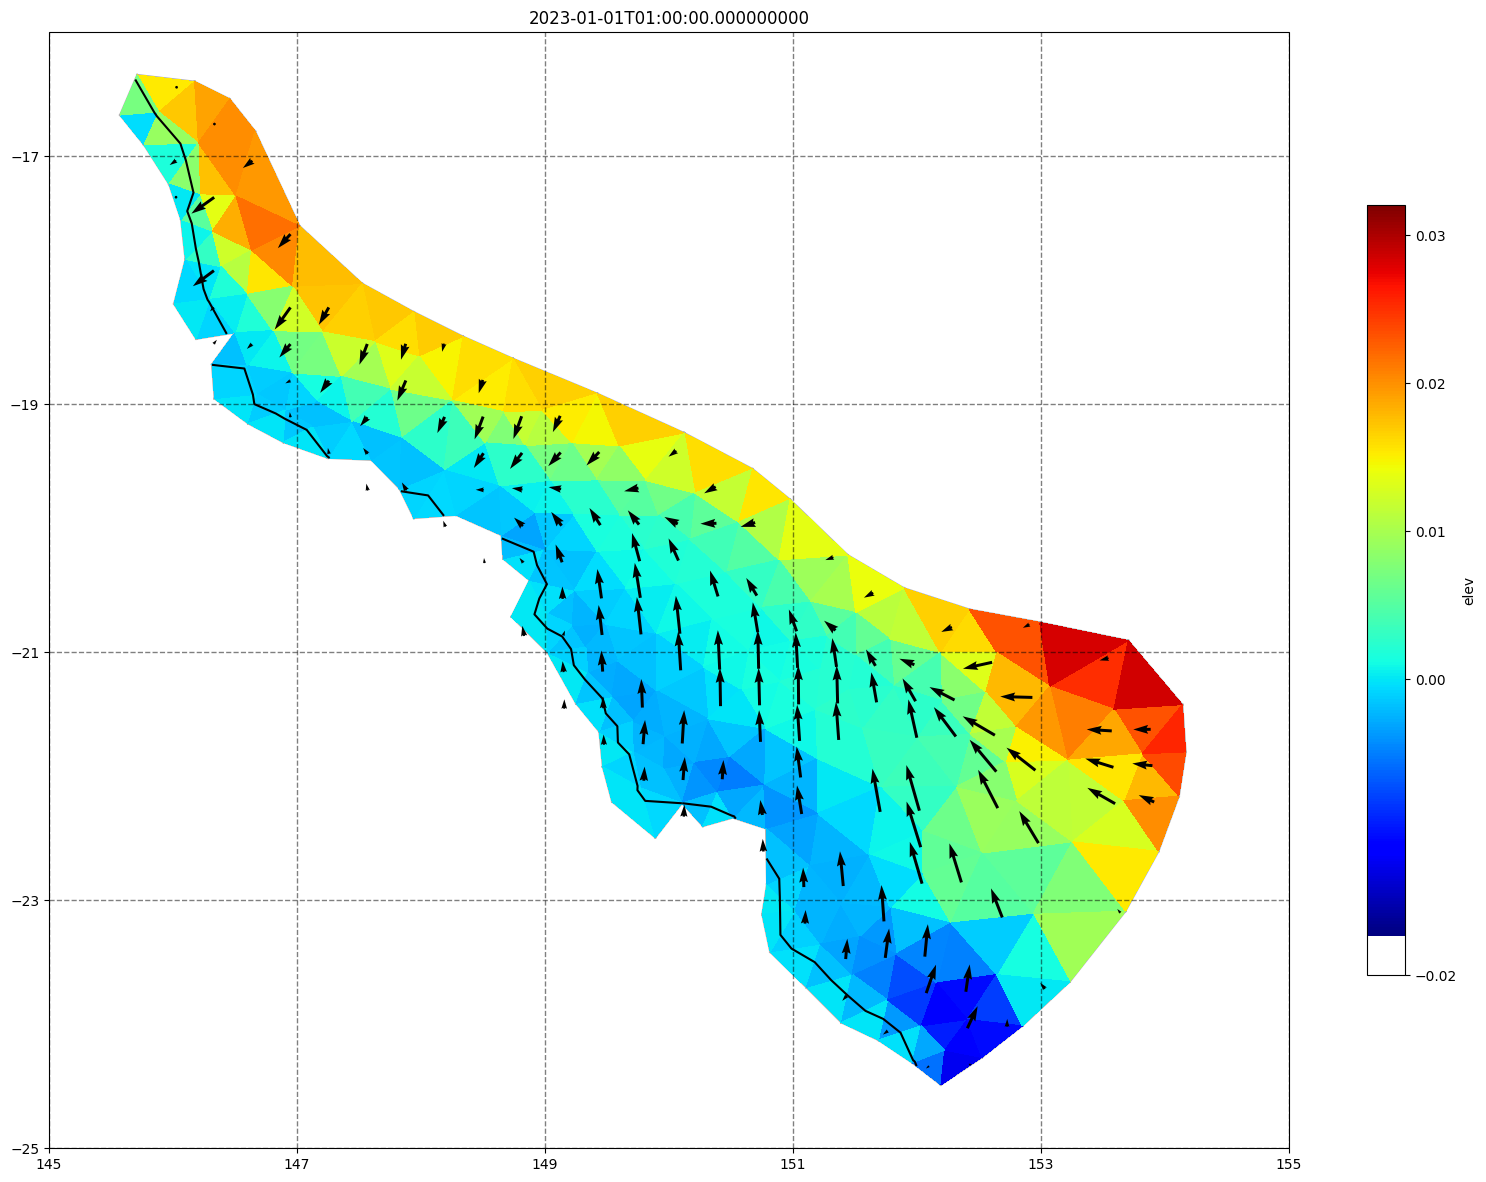

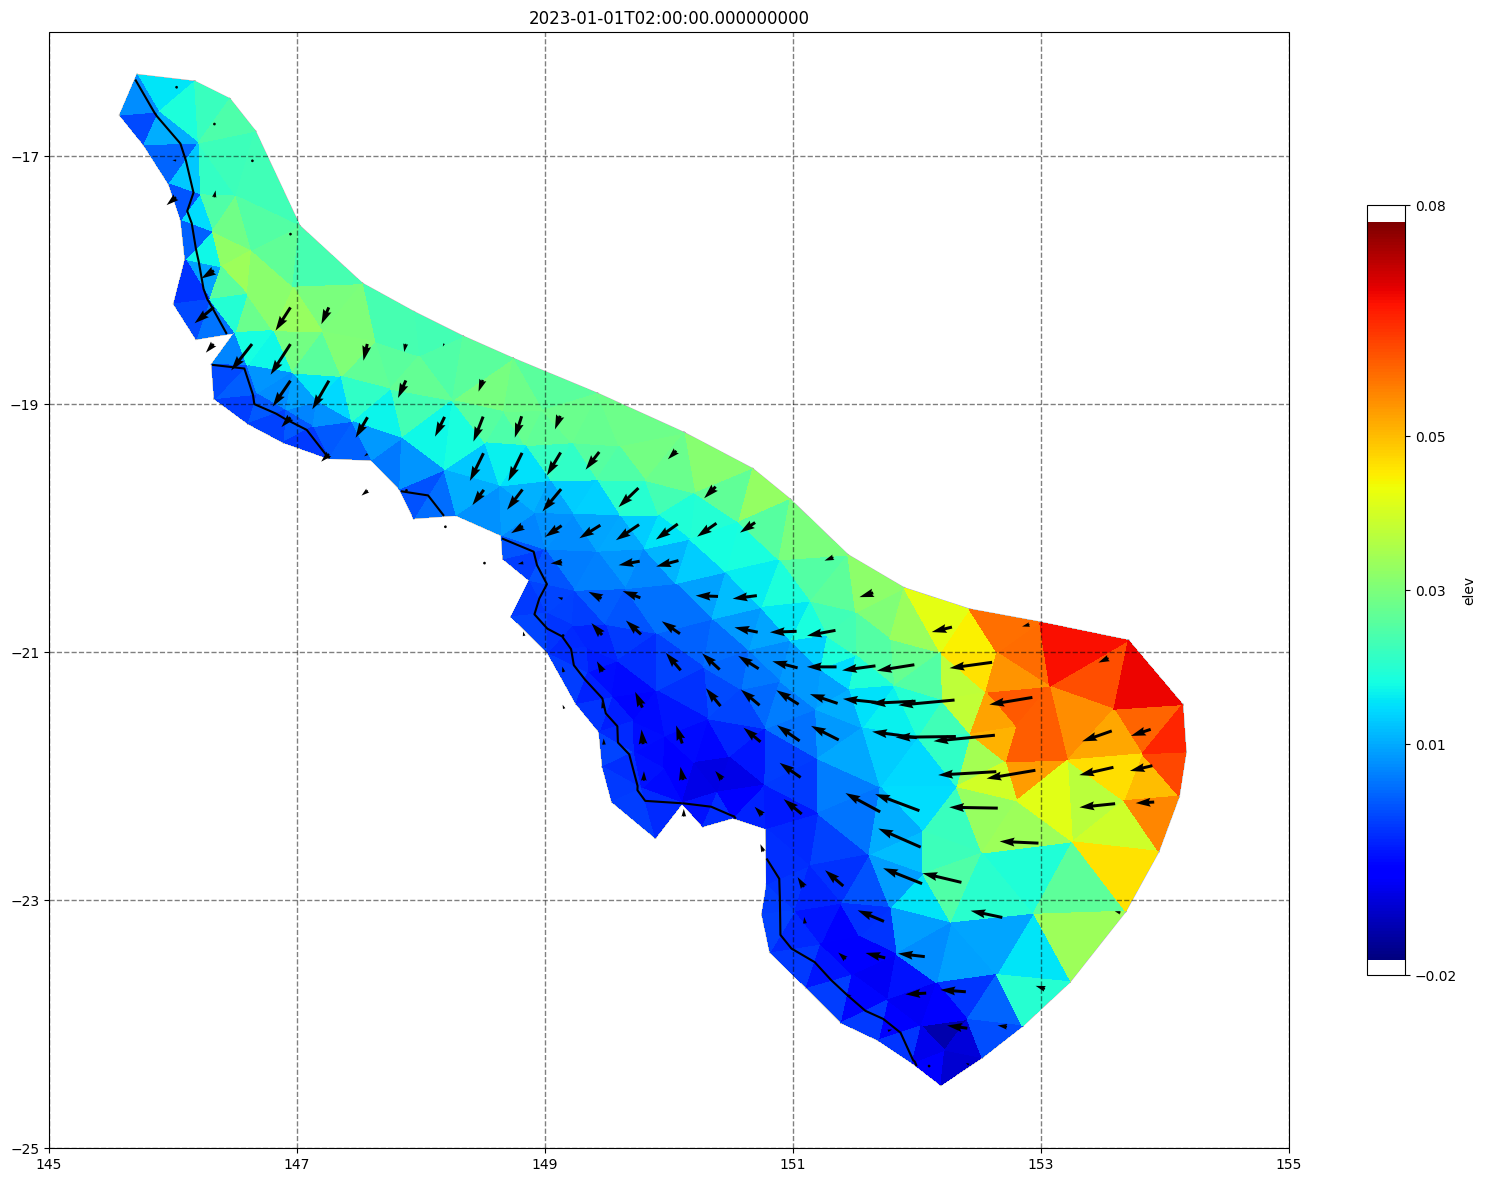

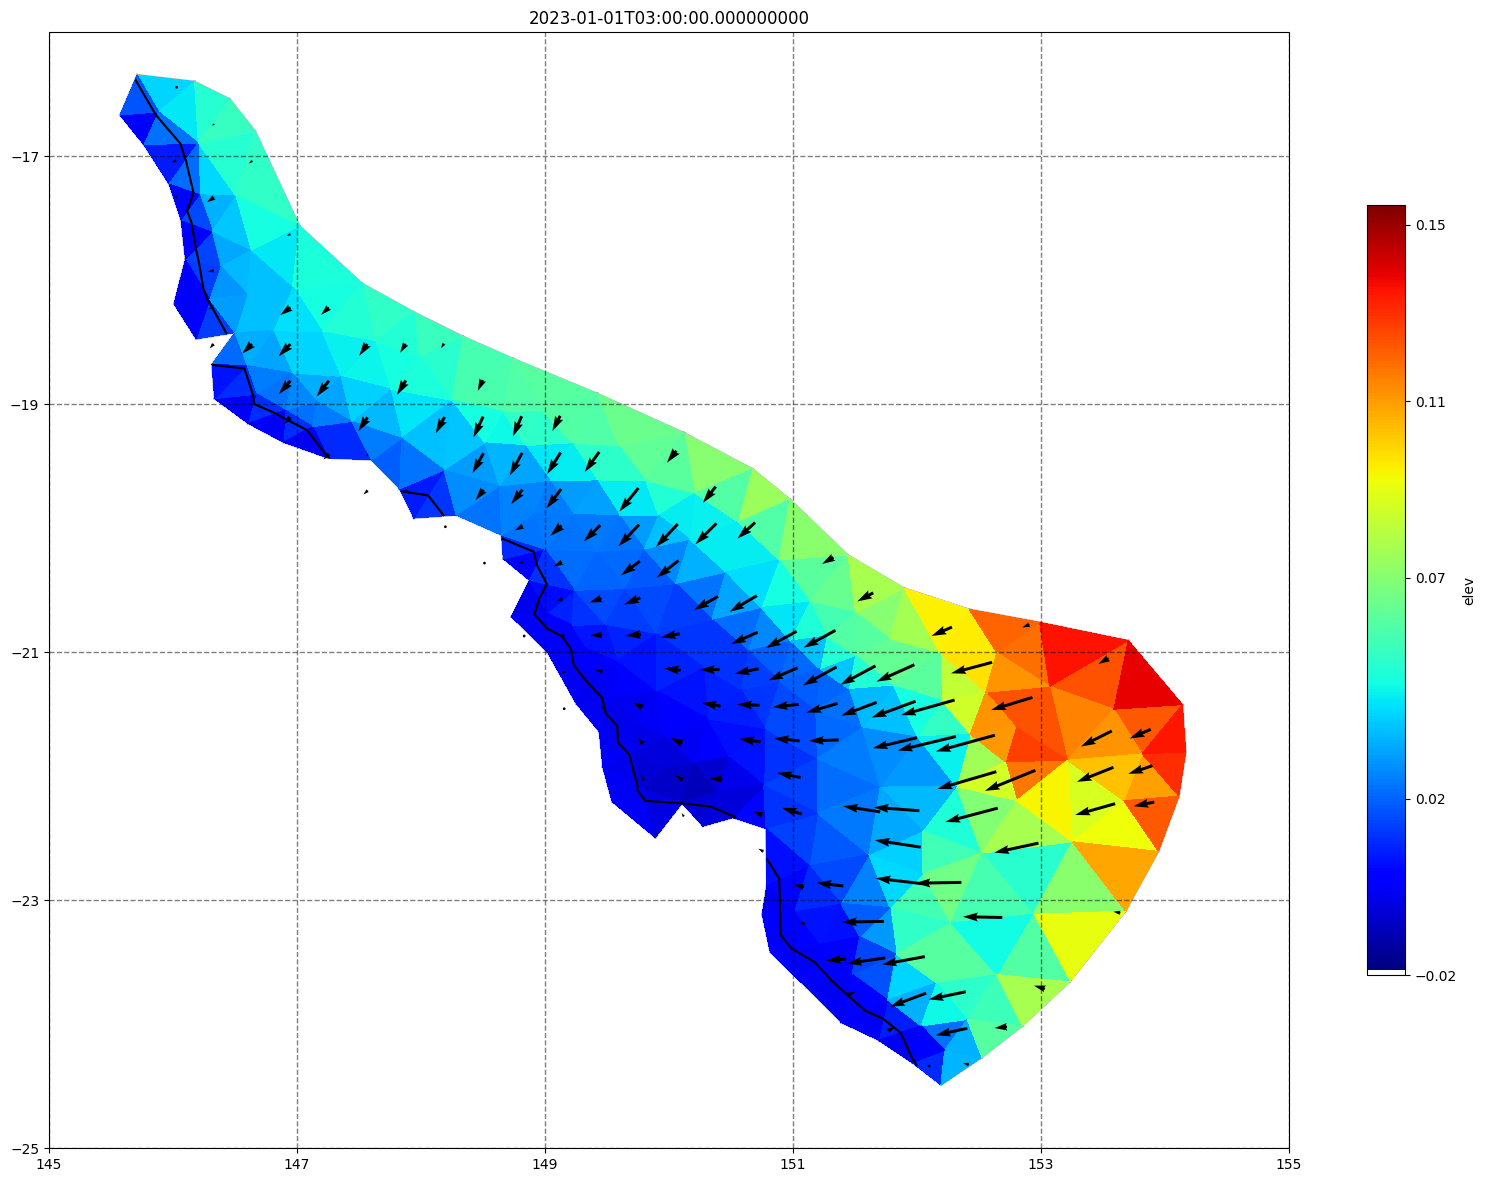

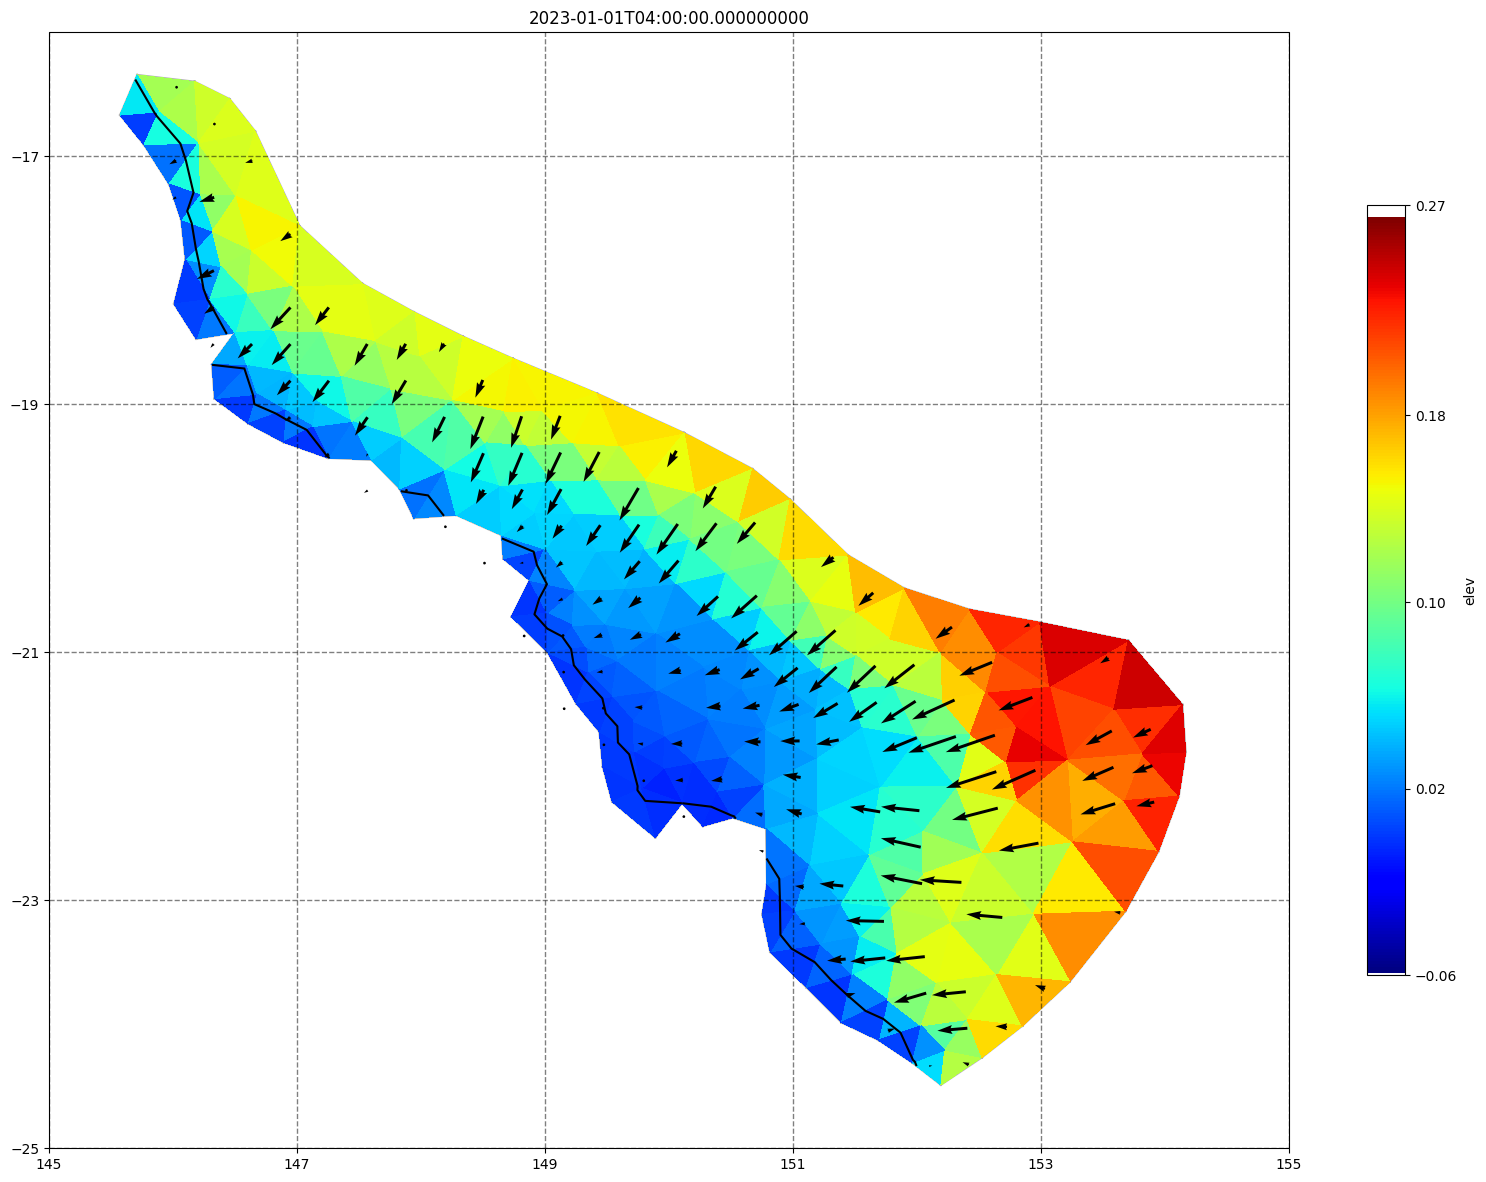

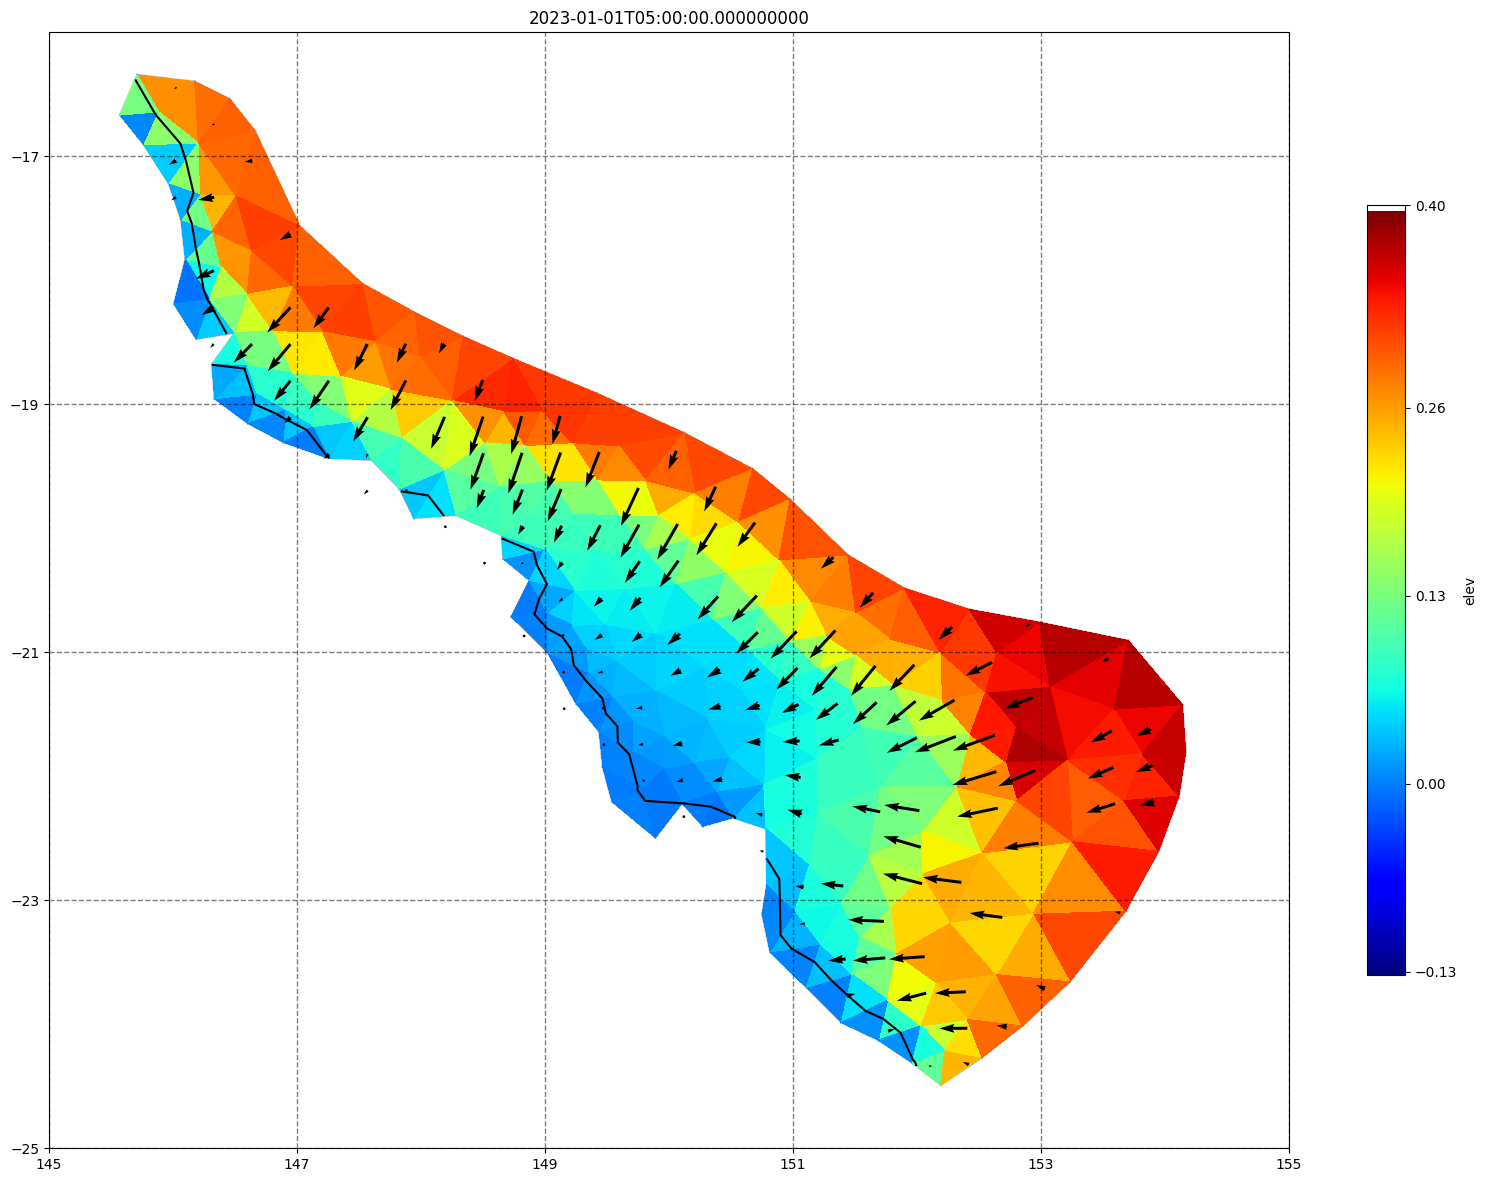

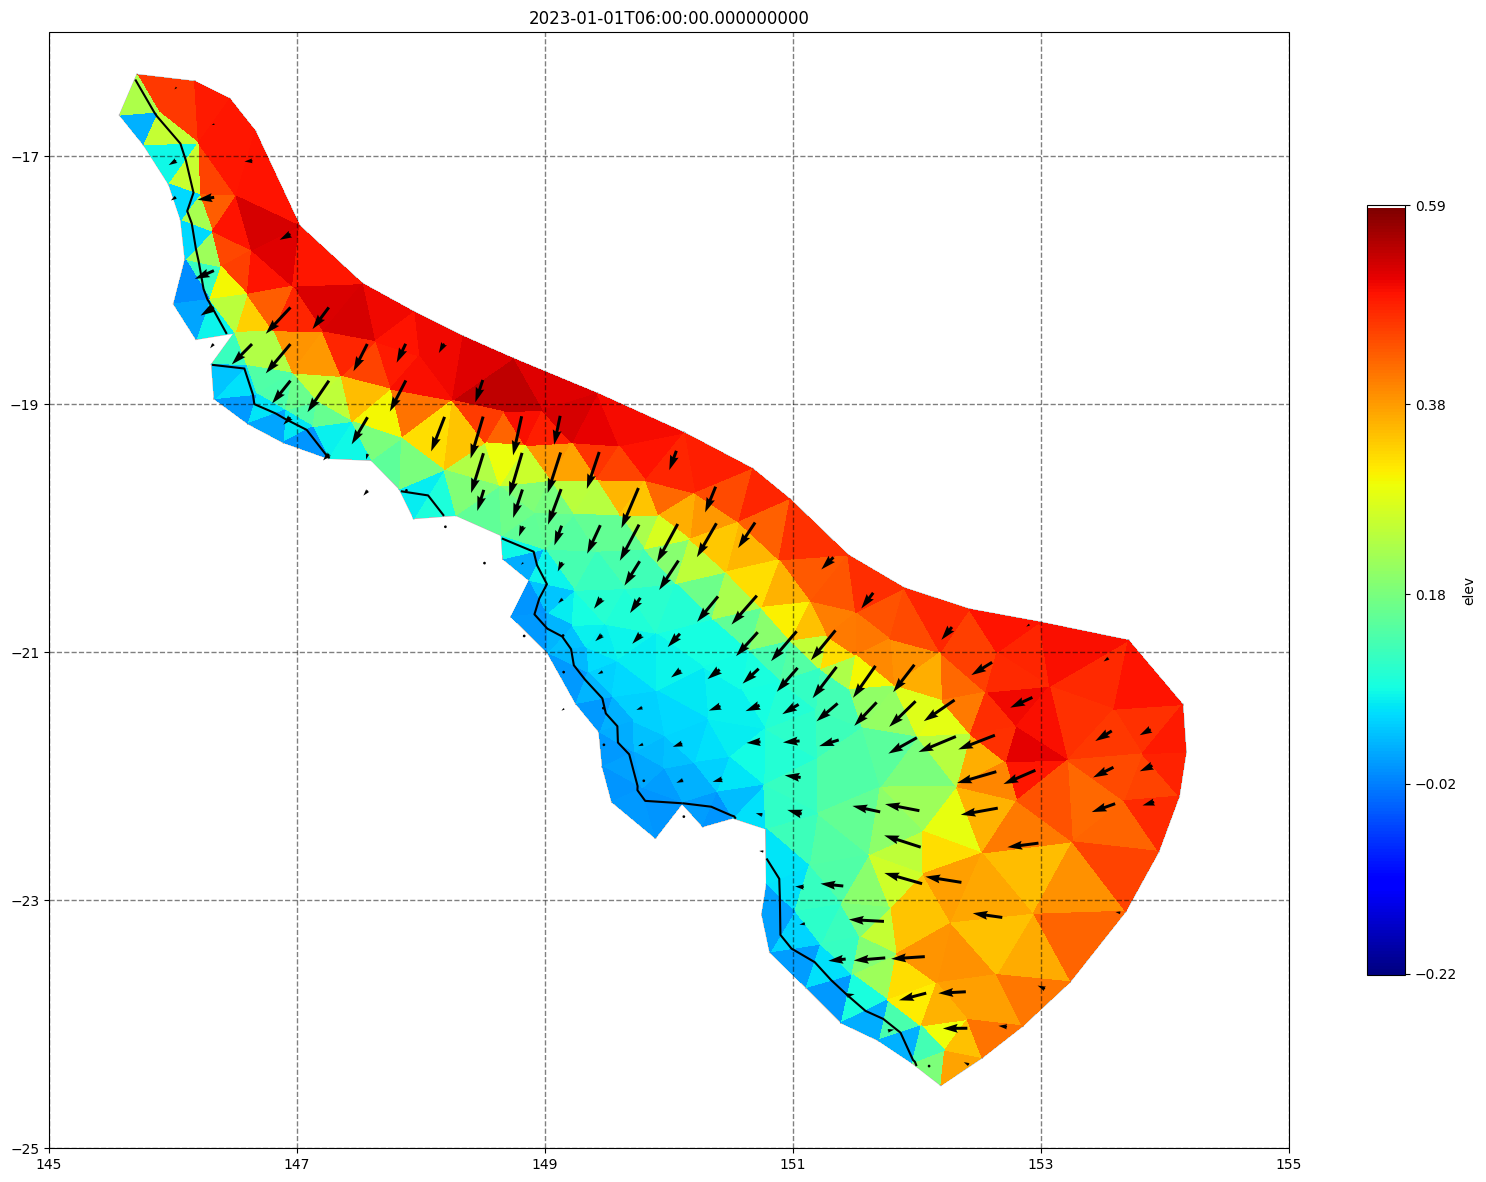

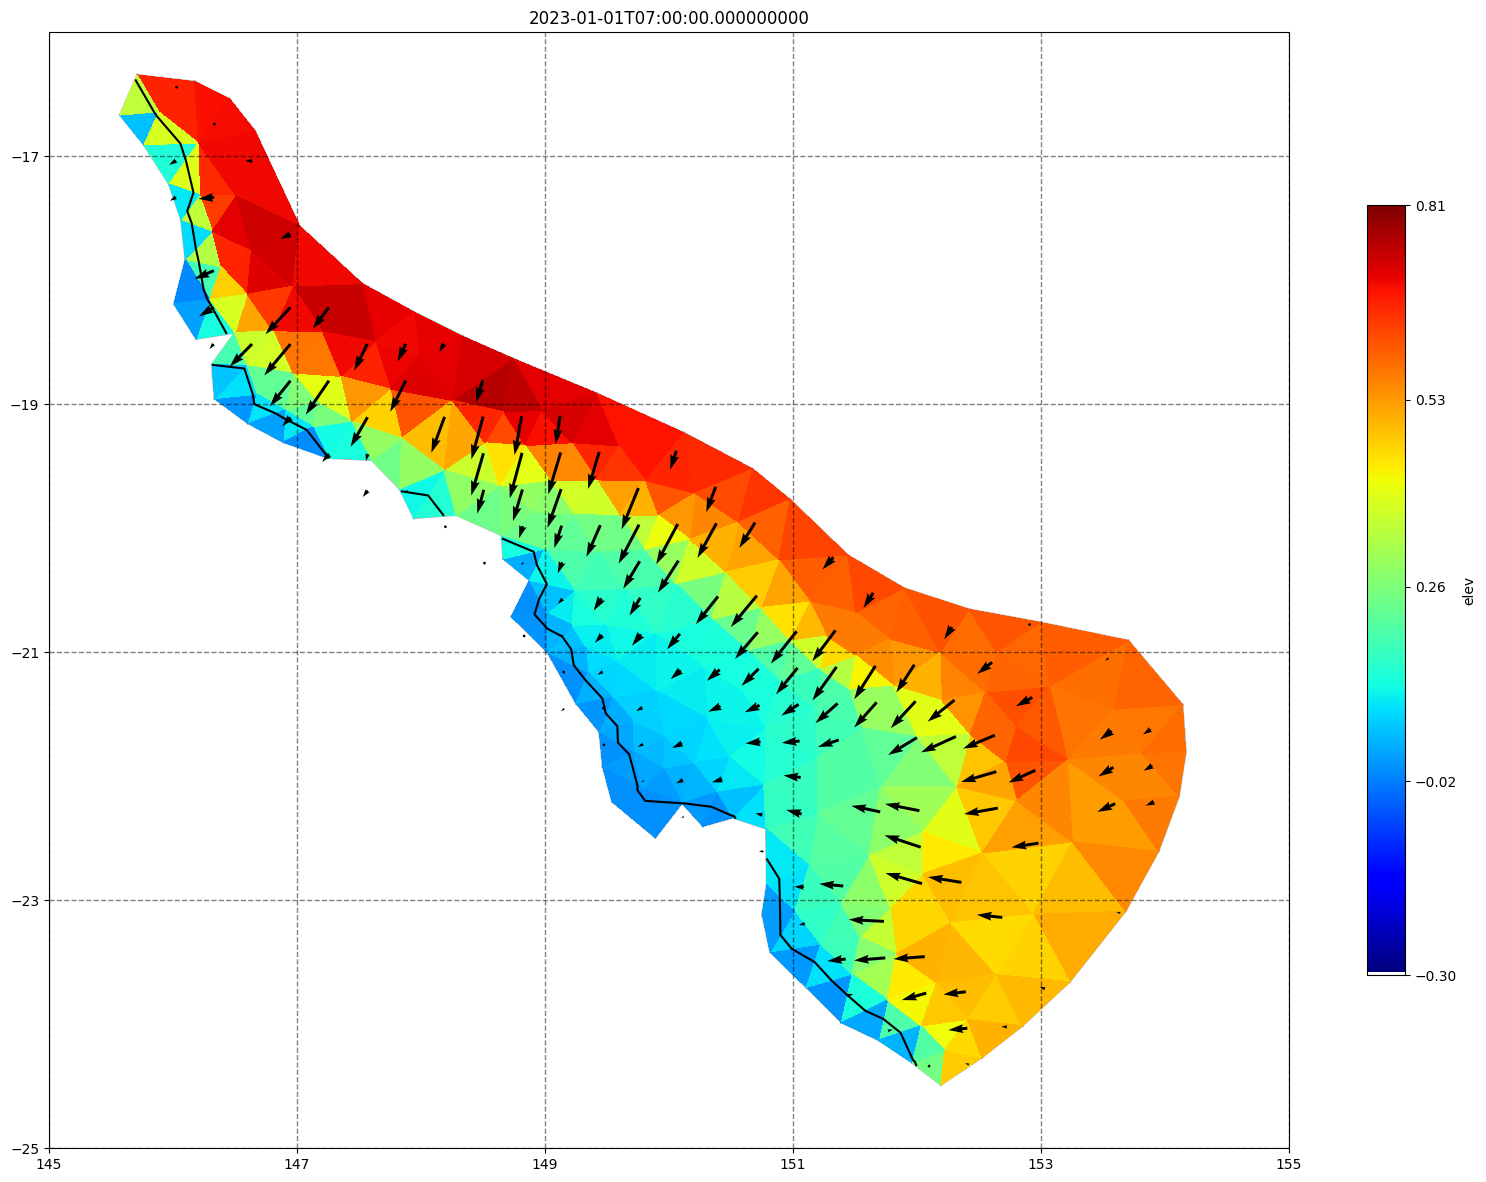

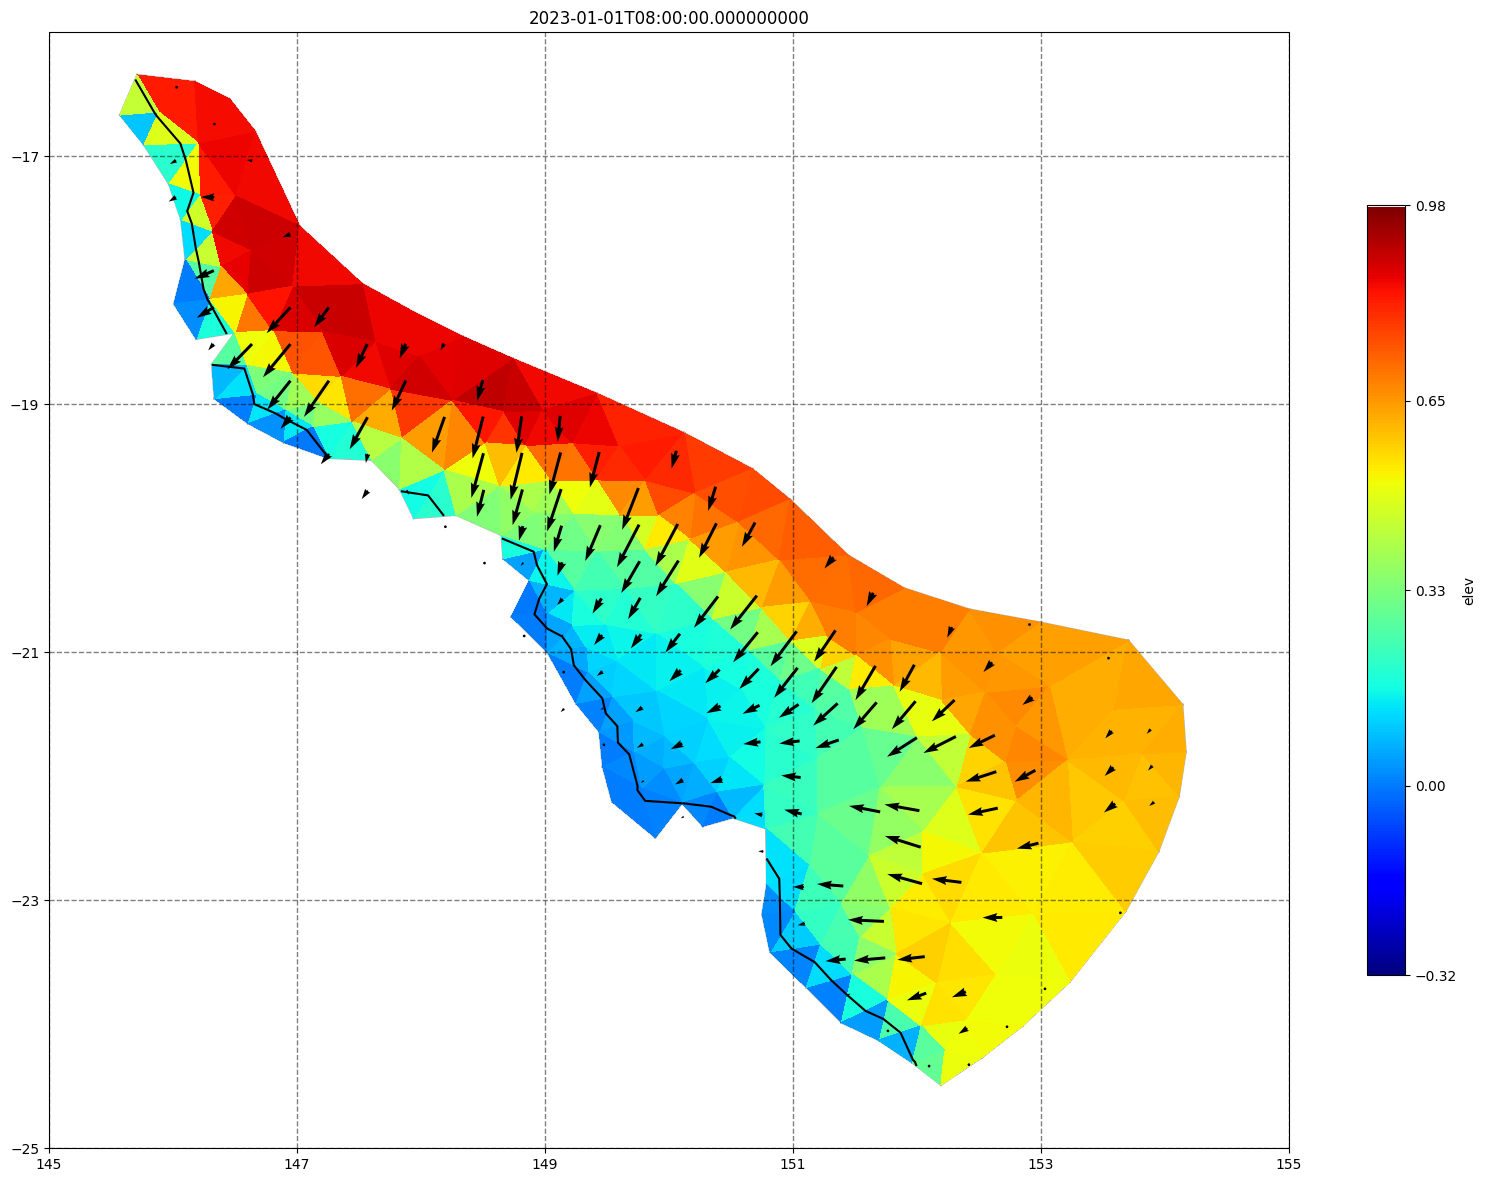

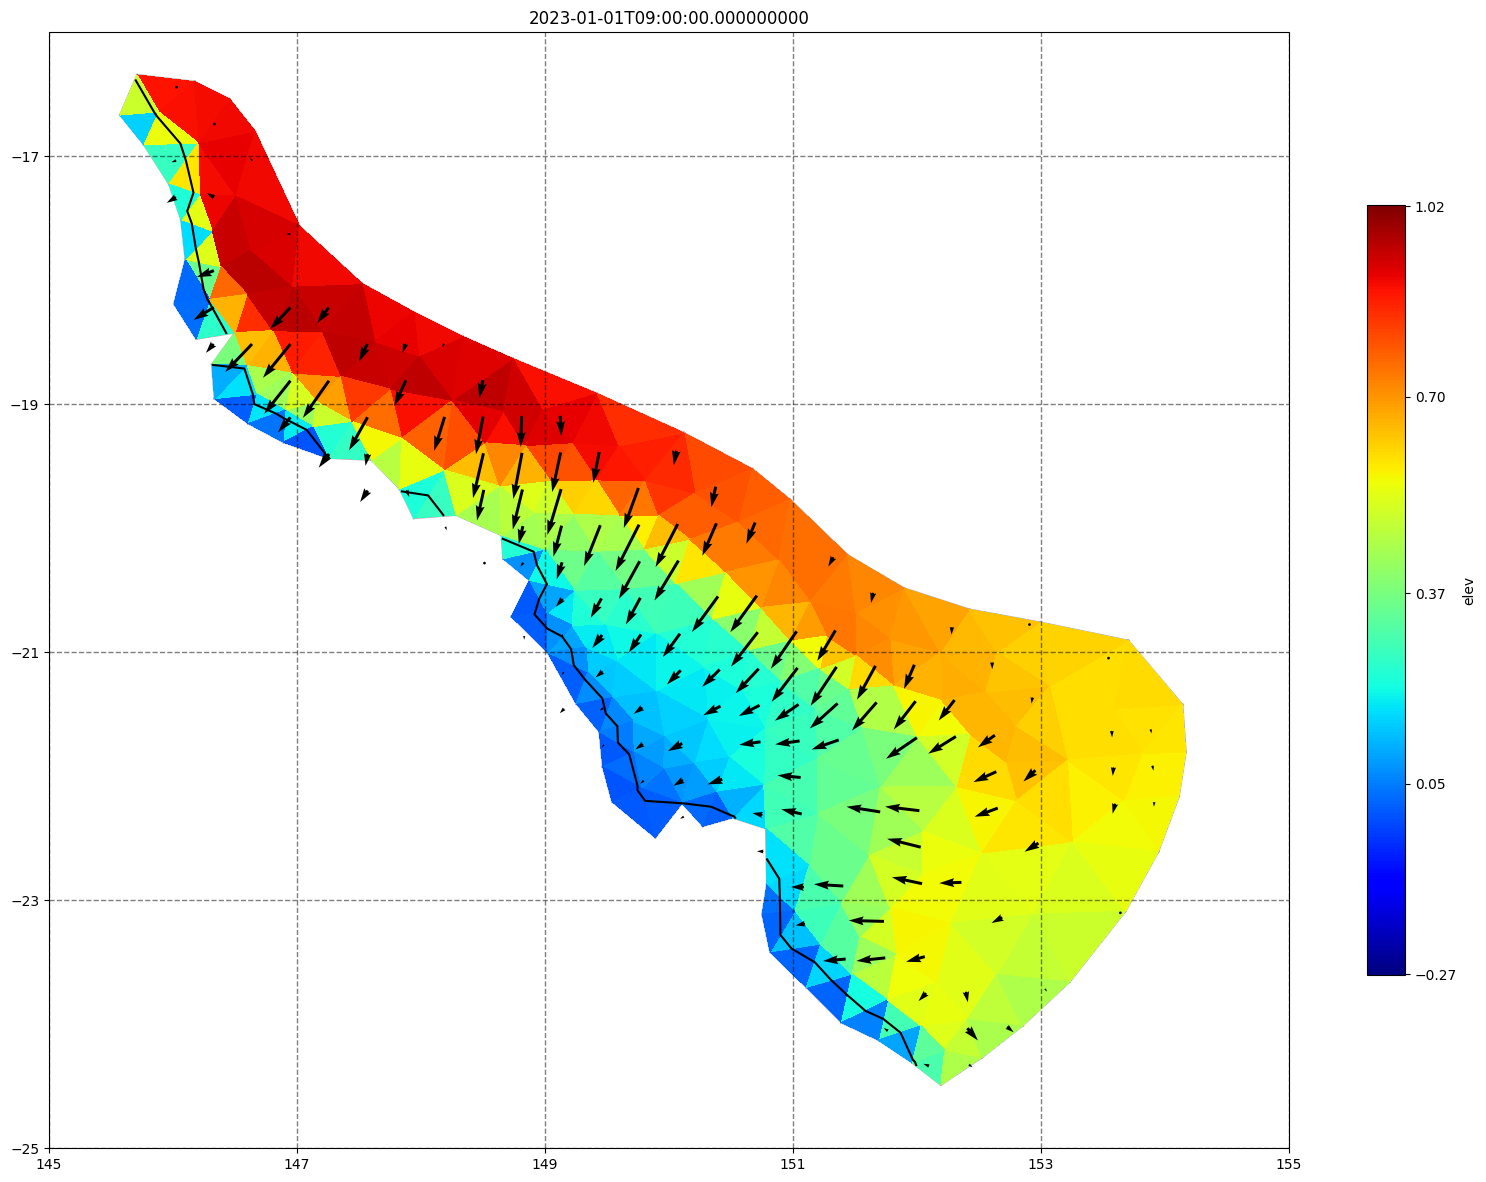

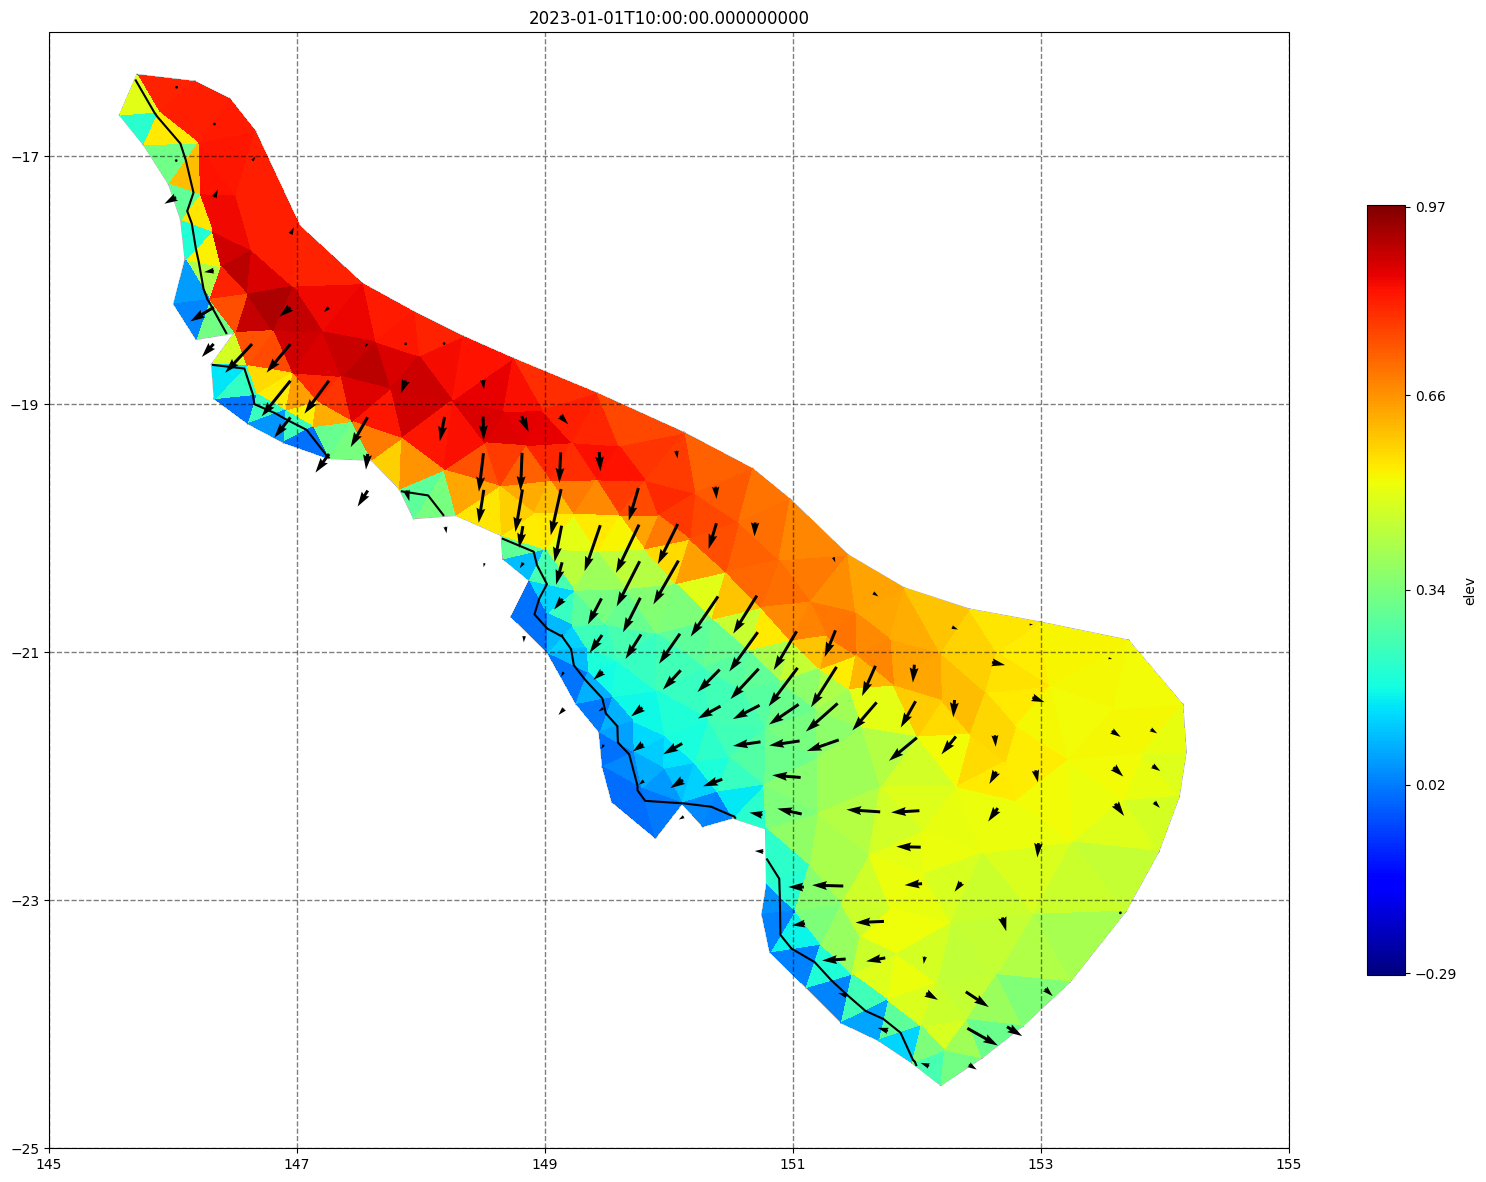

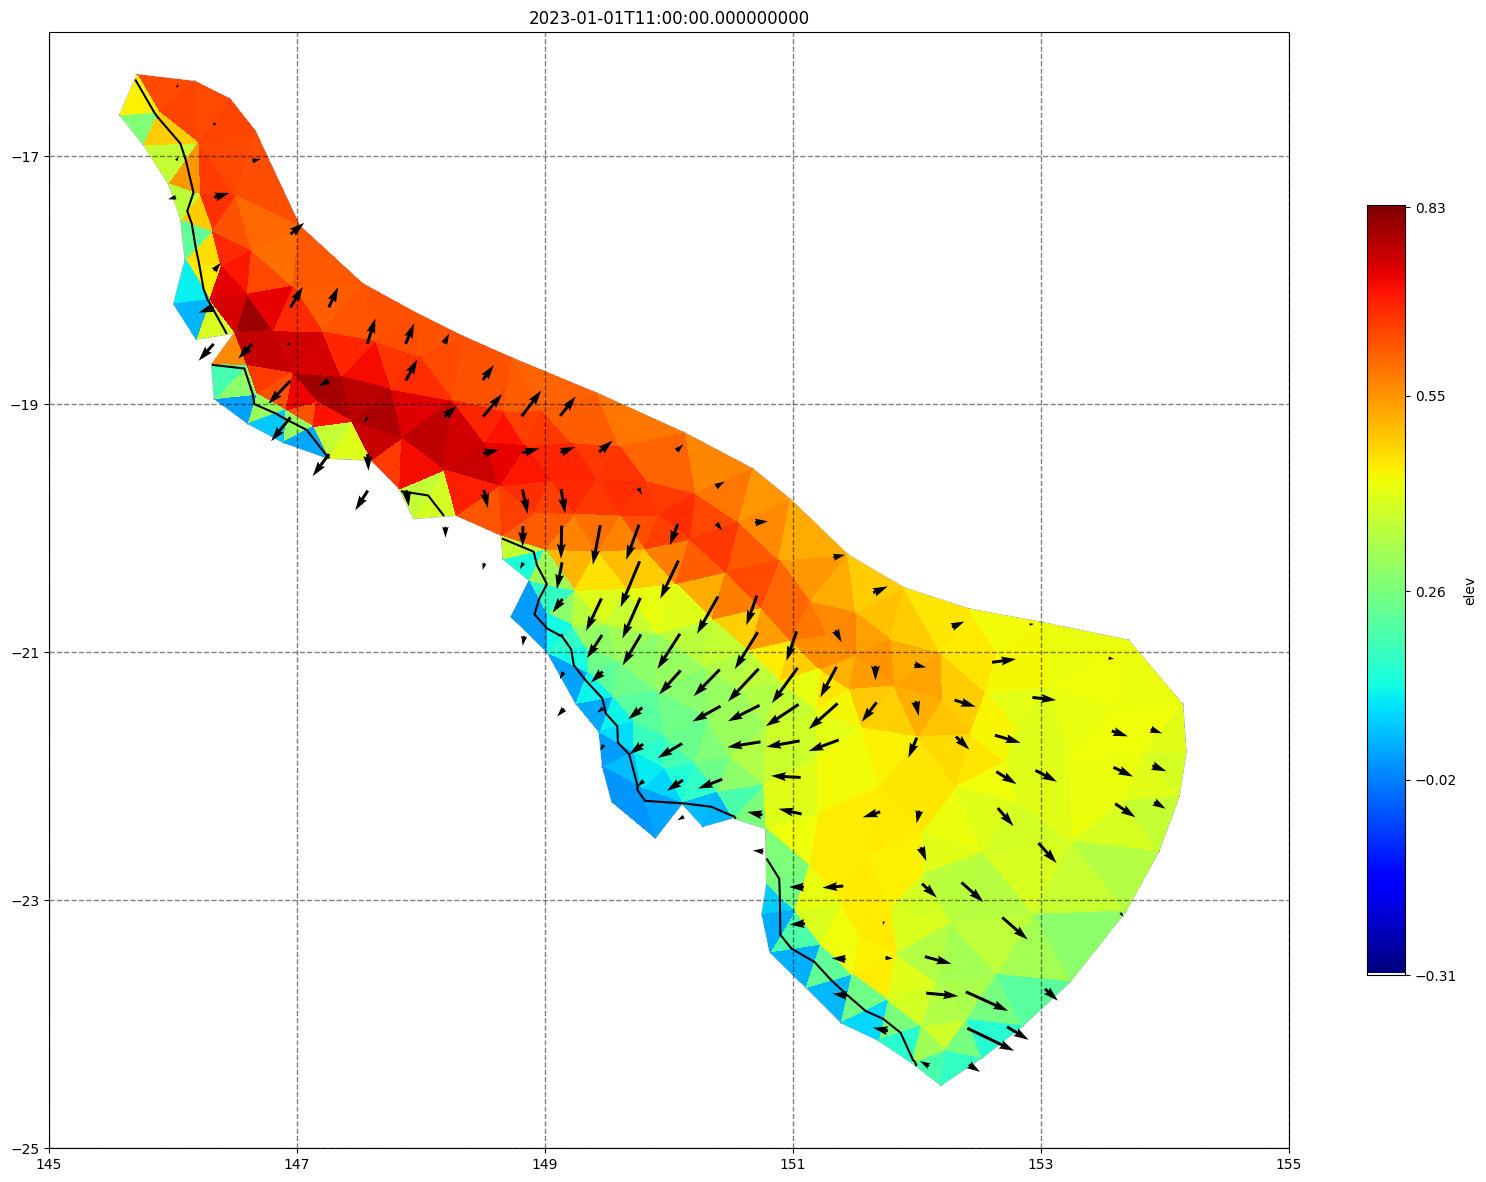

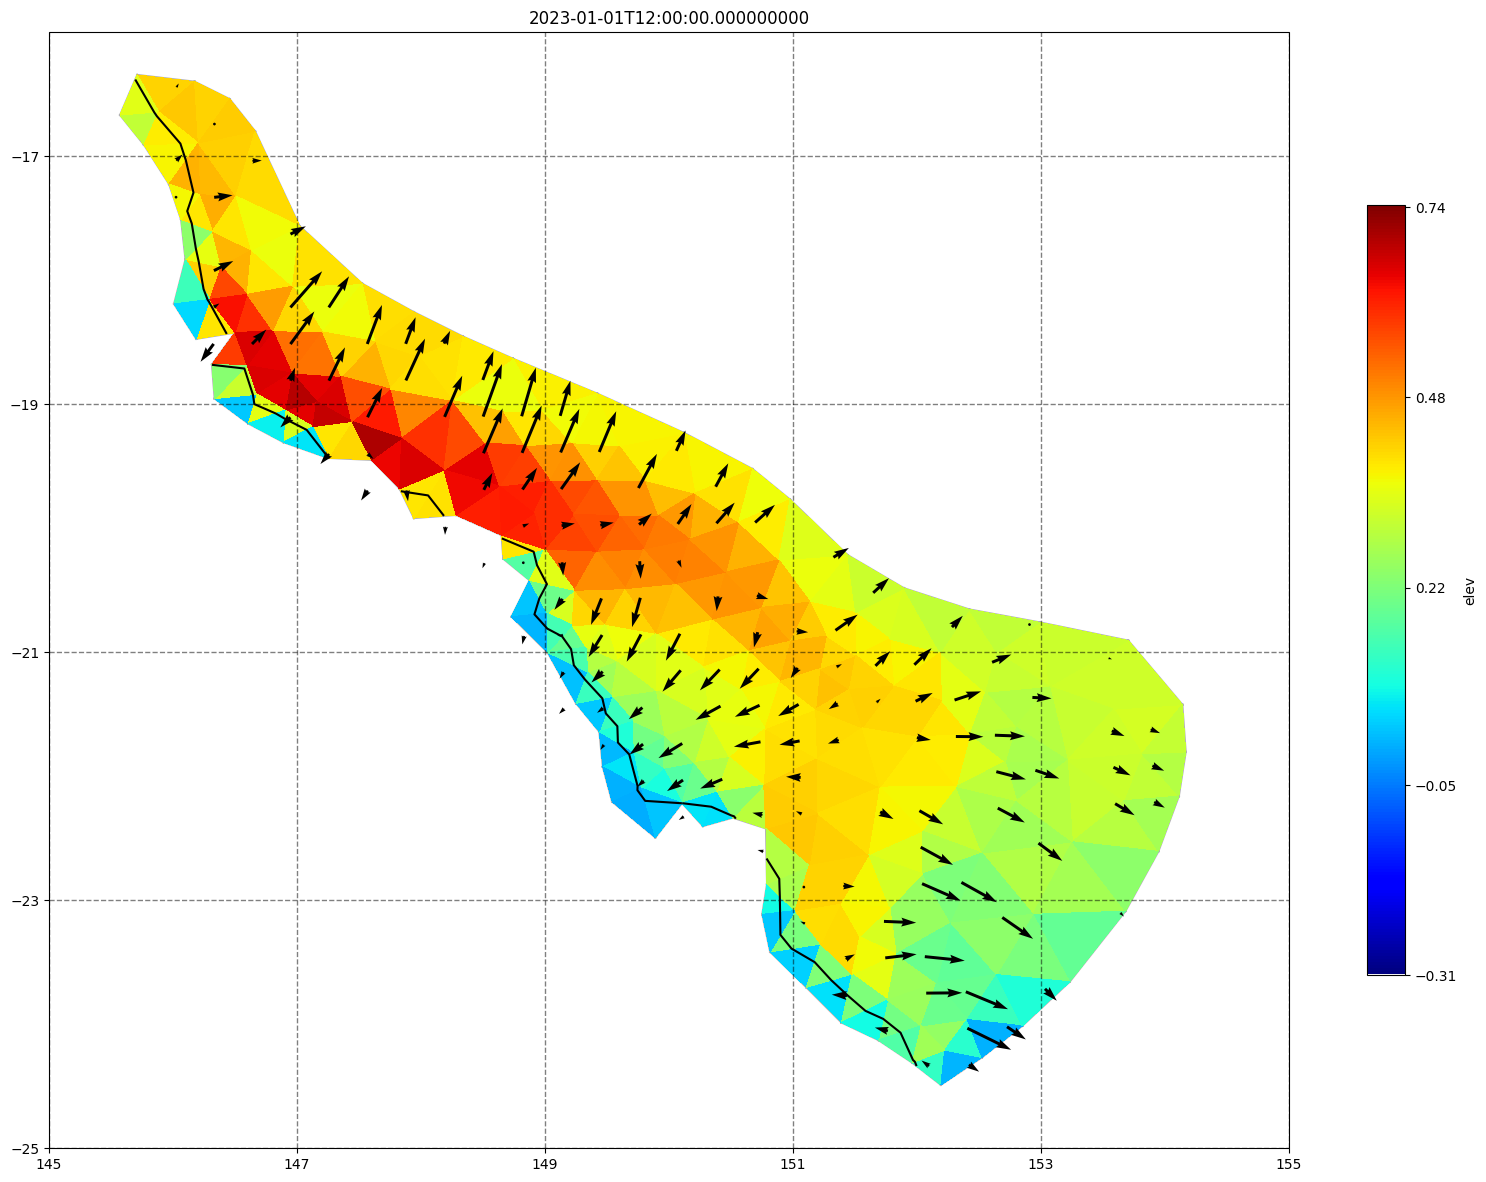

In [33]:

# plot gridded fields - elevation
for ix, time in enumerate(schout.time.values):
    fig, ax =schism_plot(schout, meshtri,'elev', bbox=[145,-25,155,-16], project=True, plotmesh=True, mask=False, time=time,
              vectors=True, contours=[0])
    ax.set_title(time)

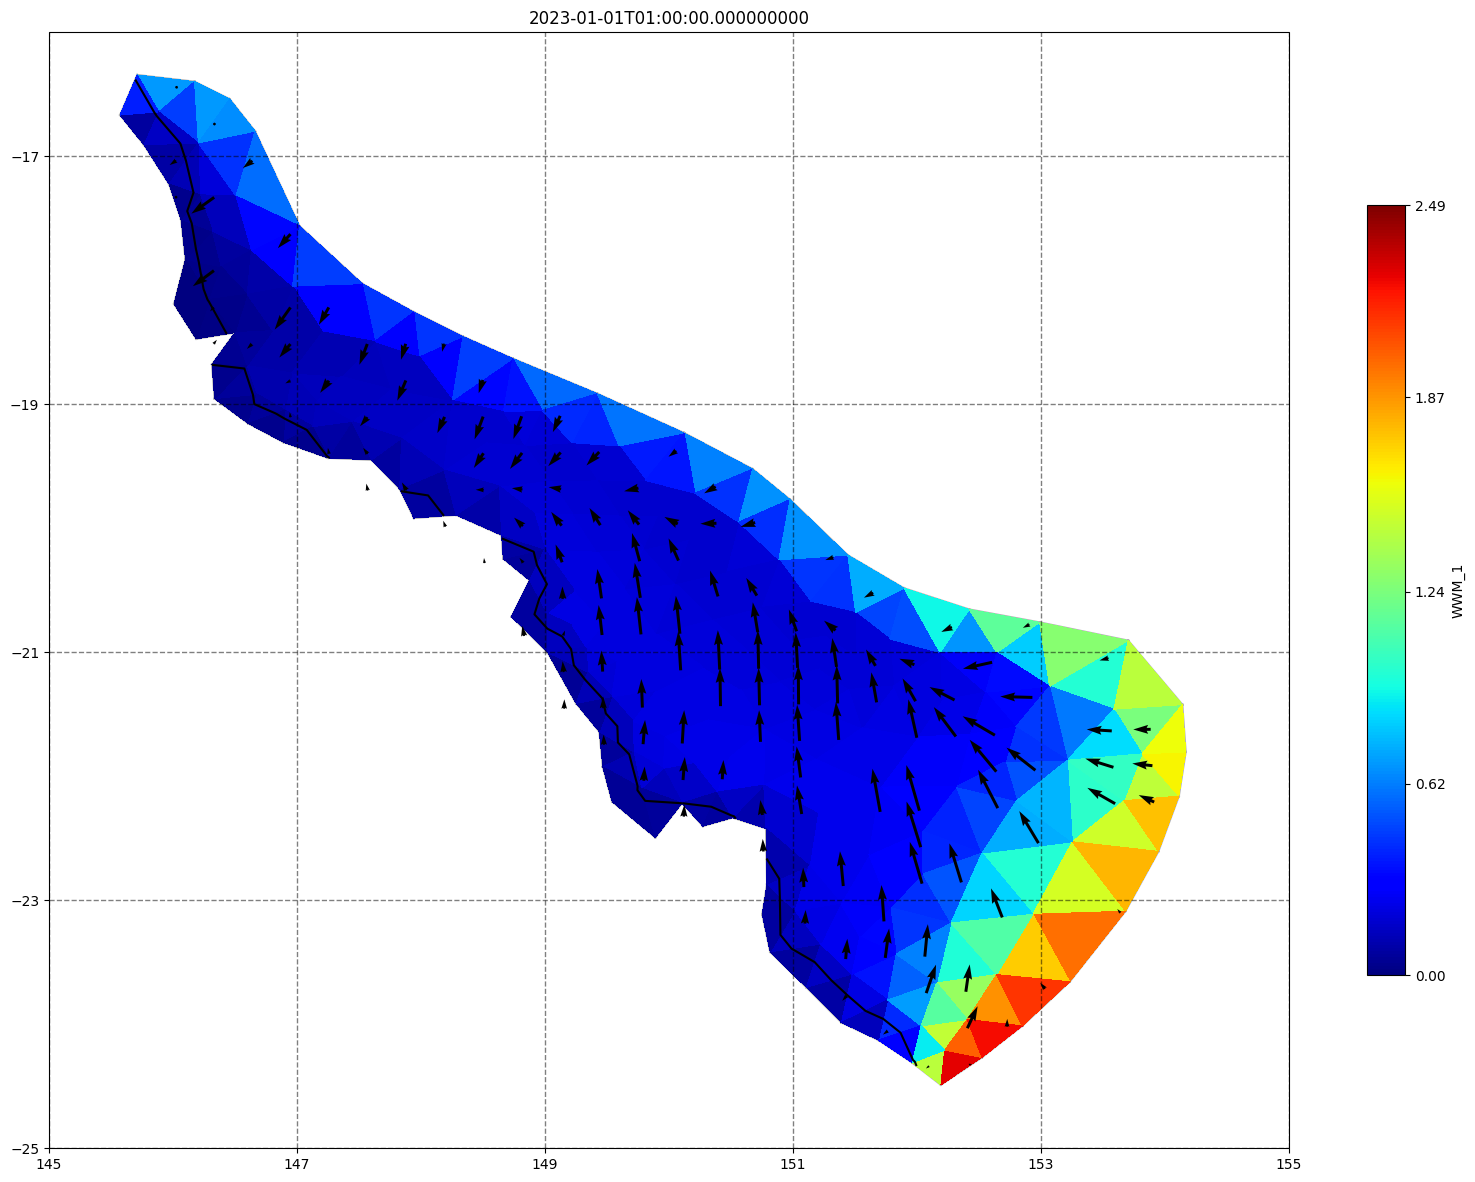

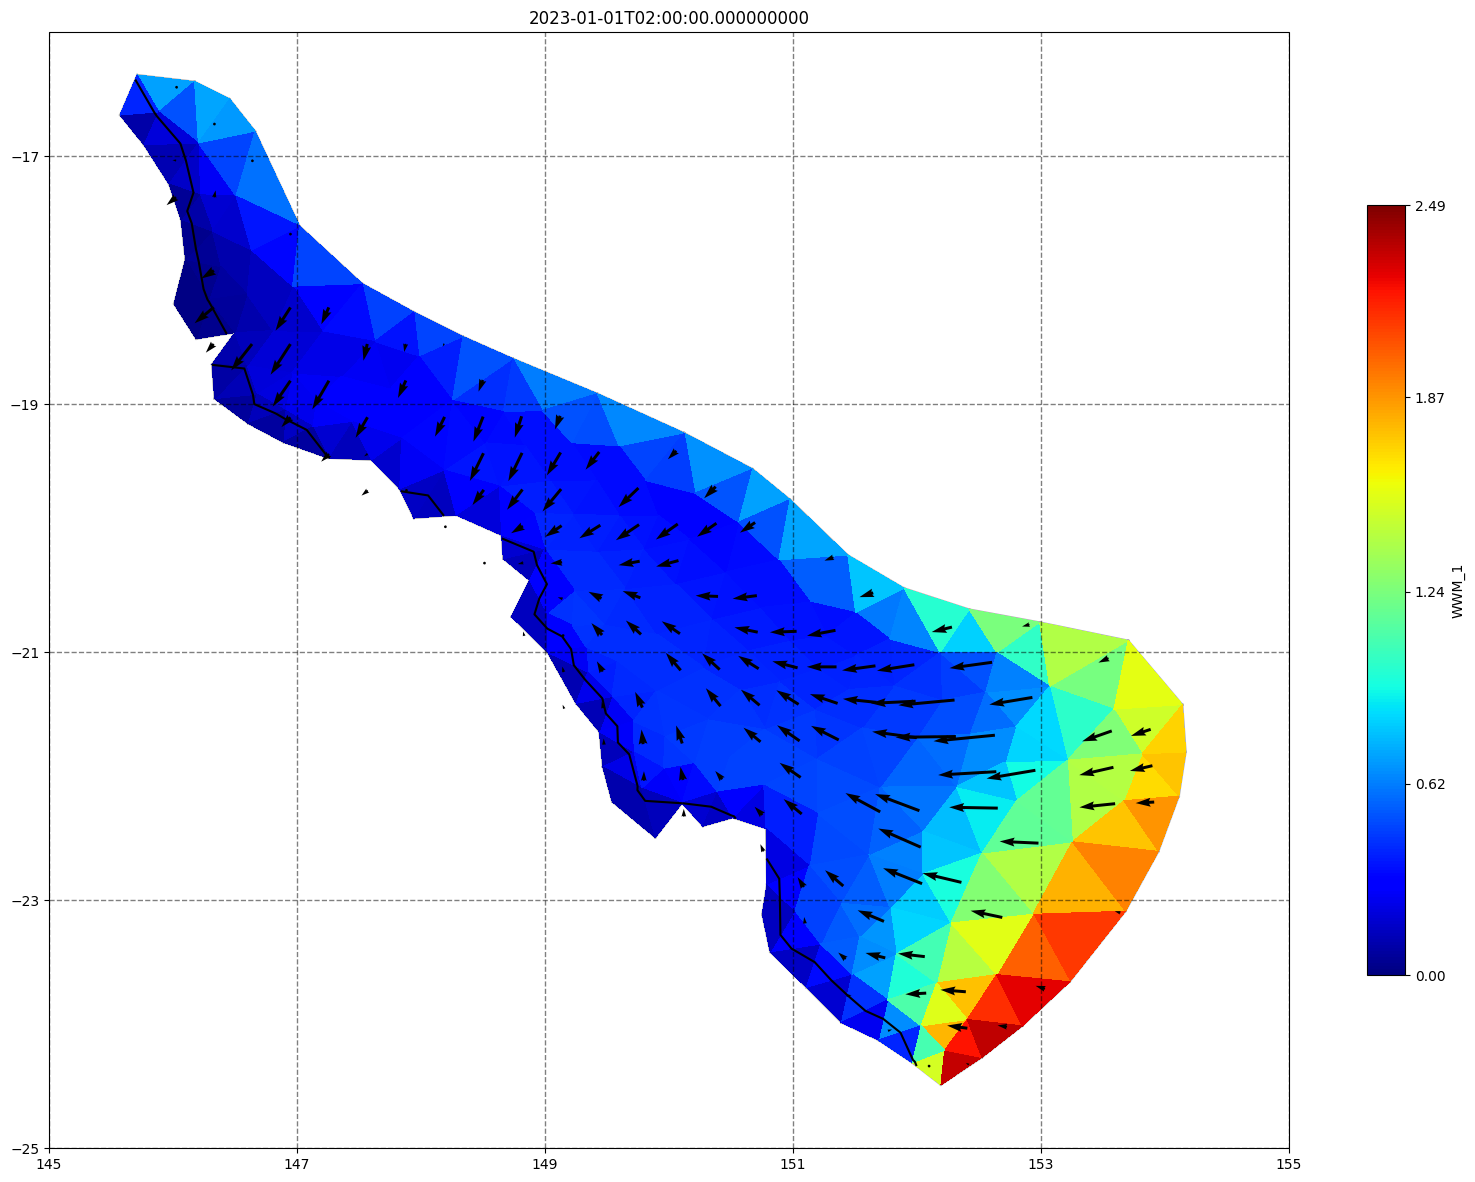

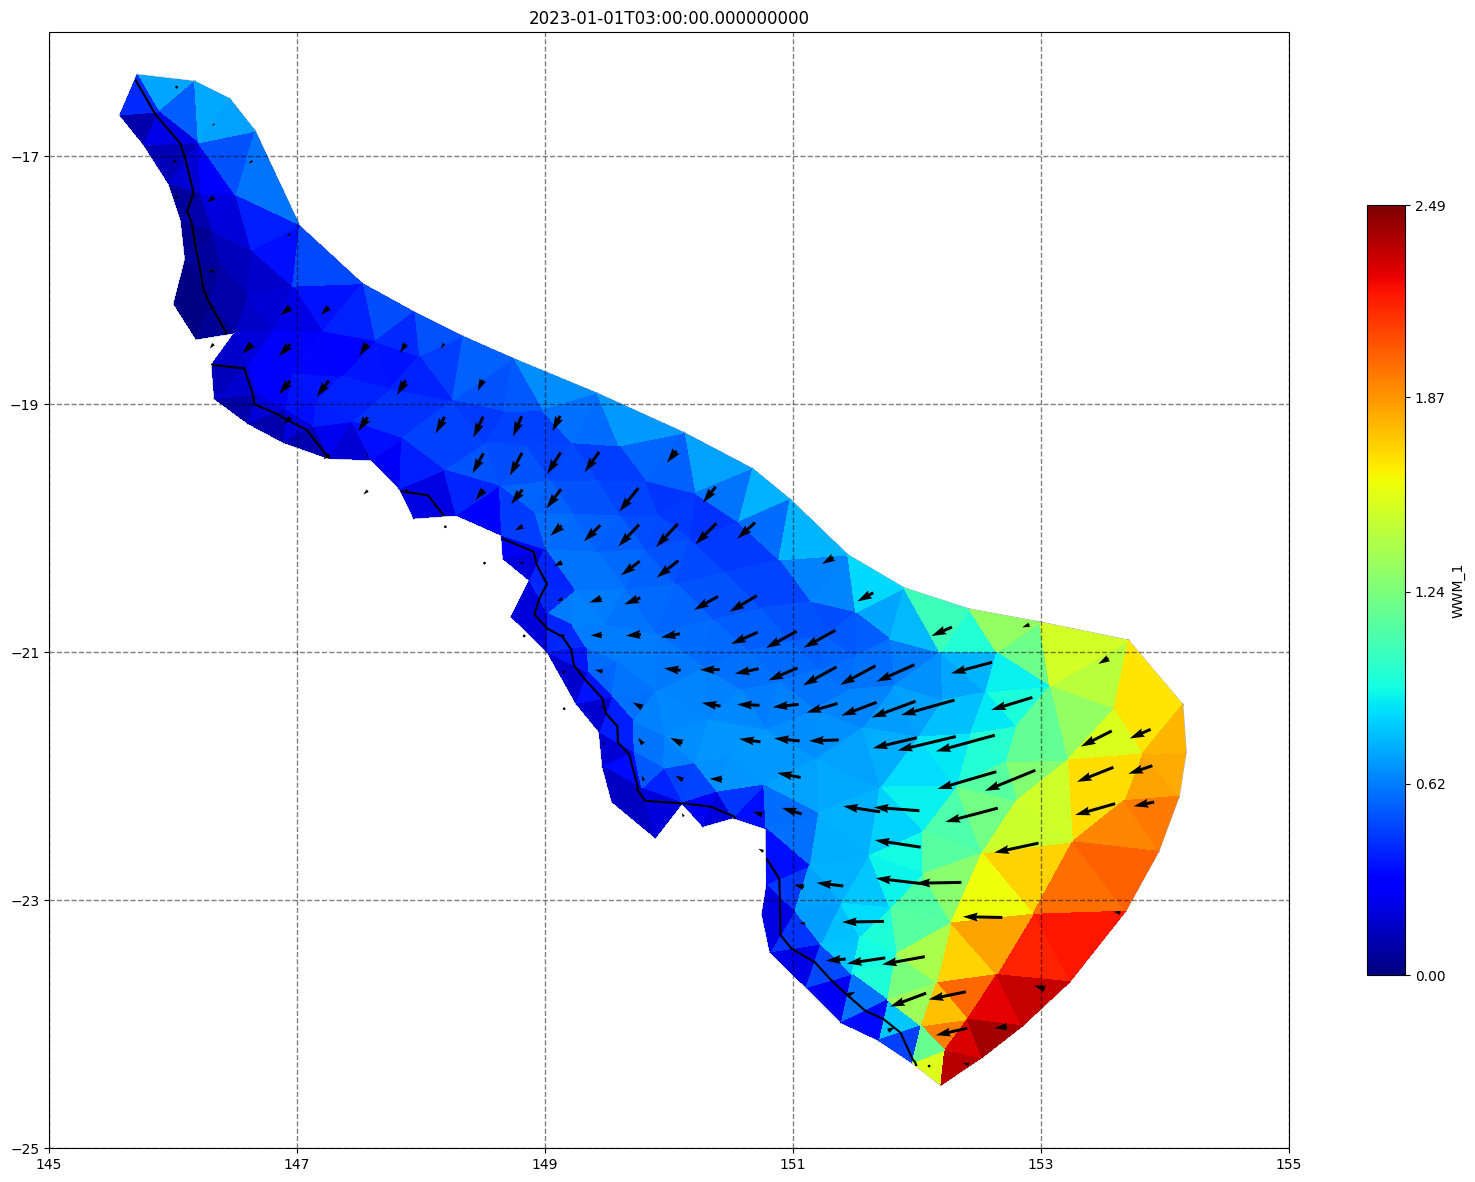

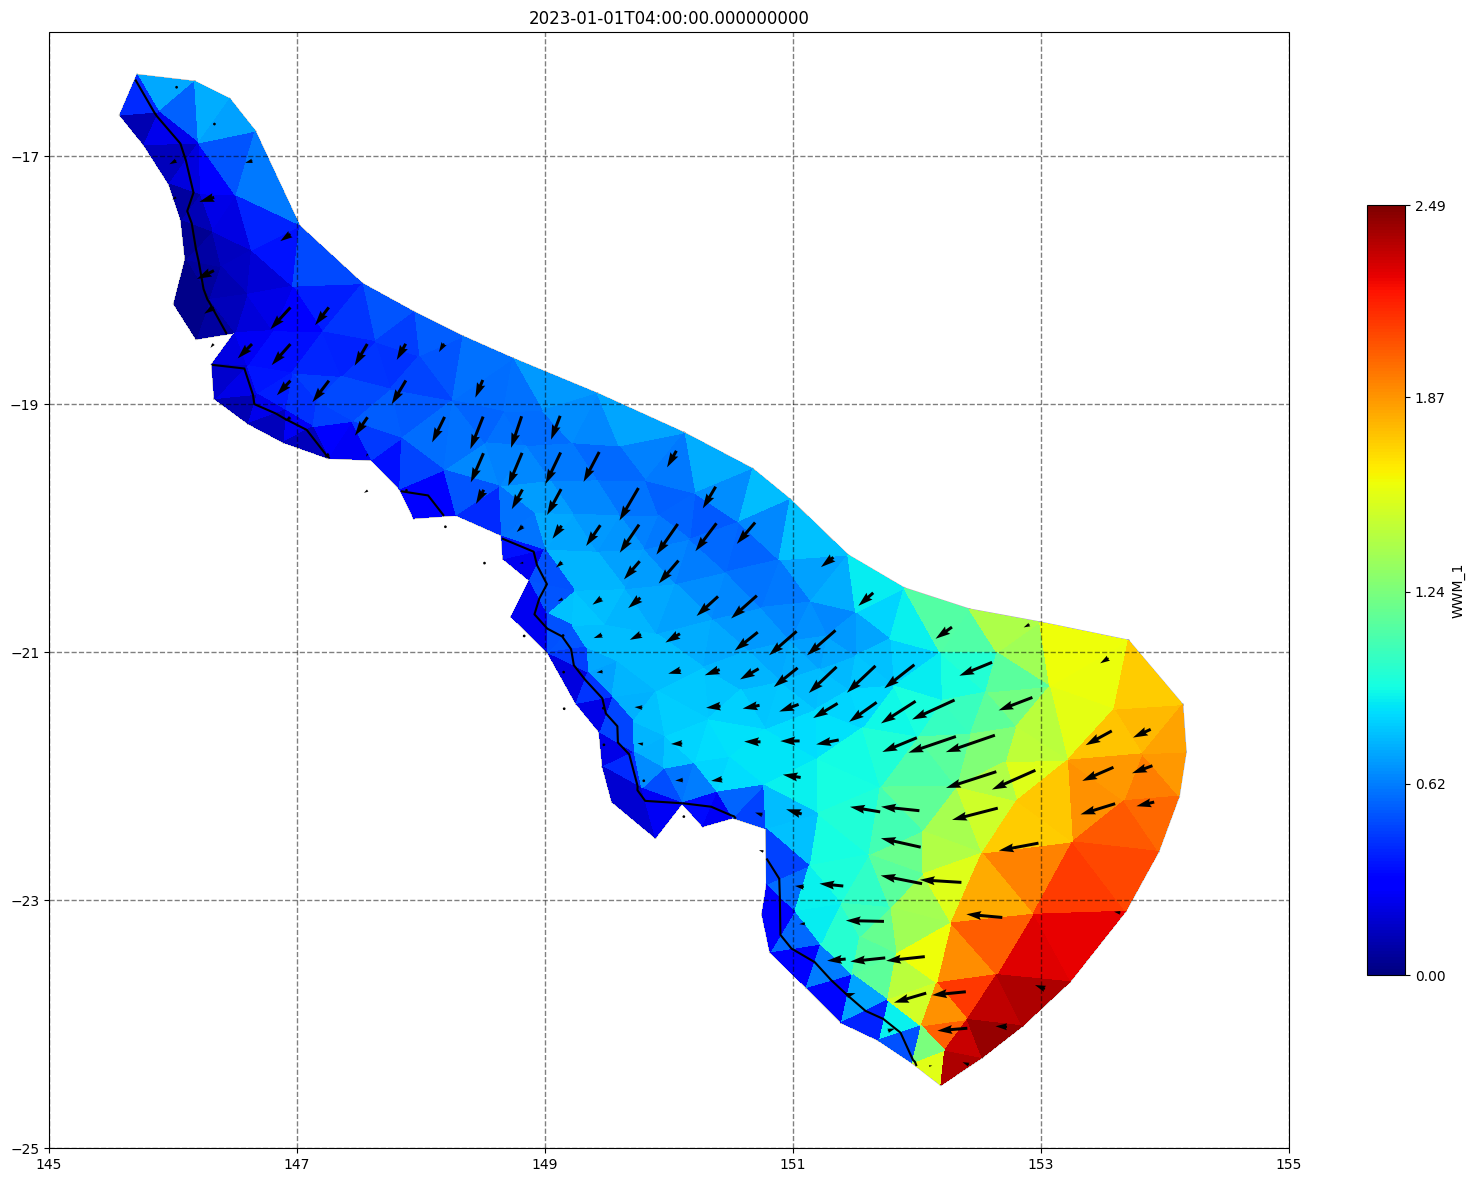

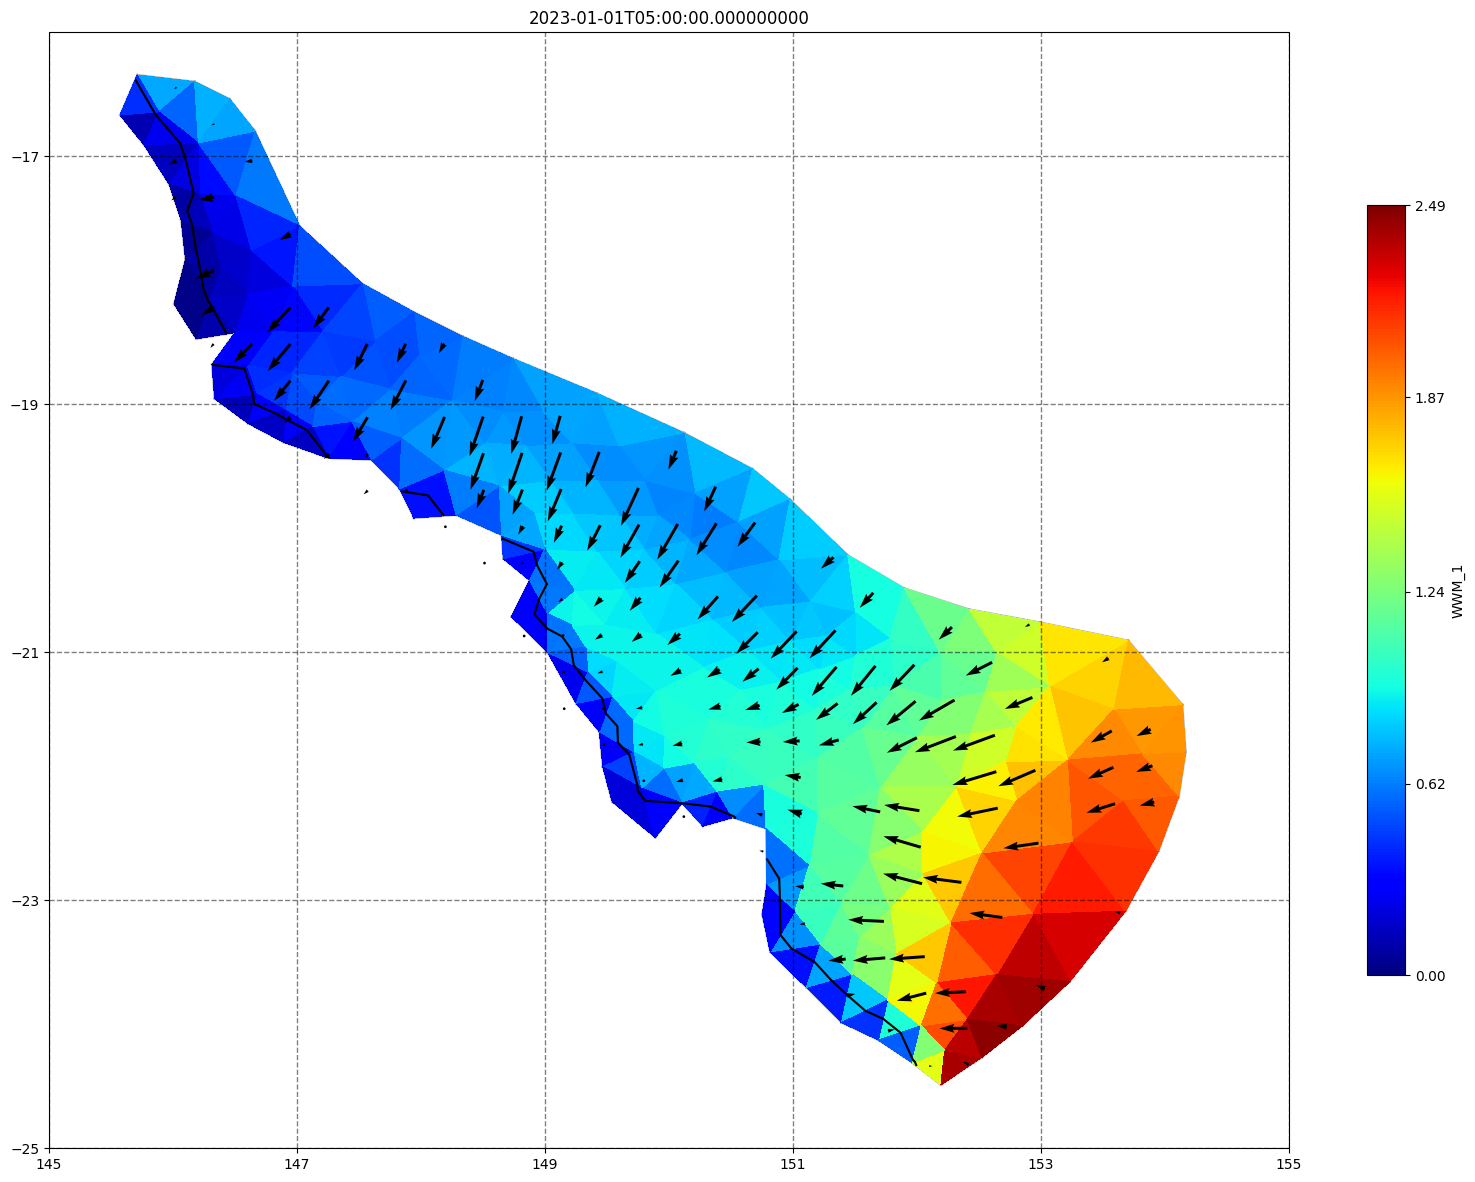

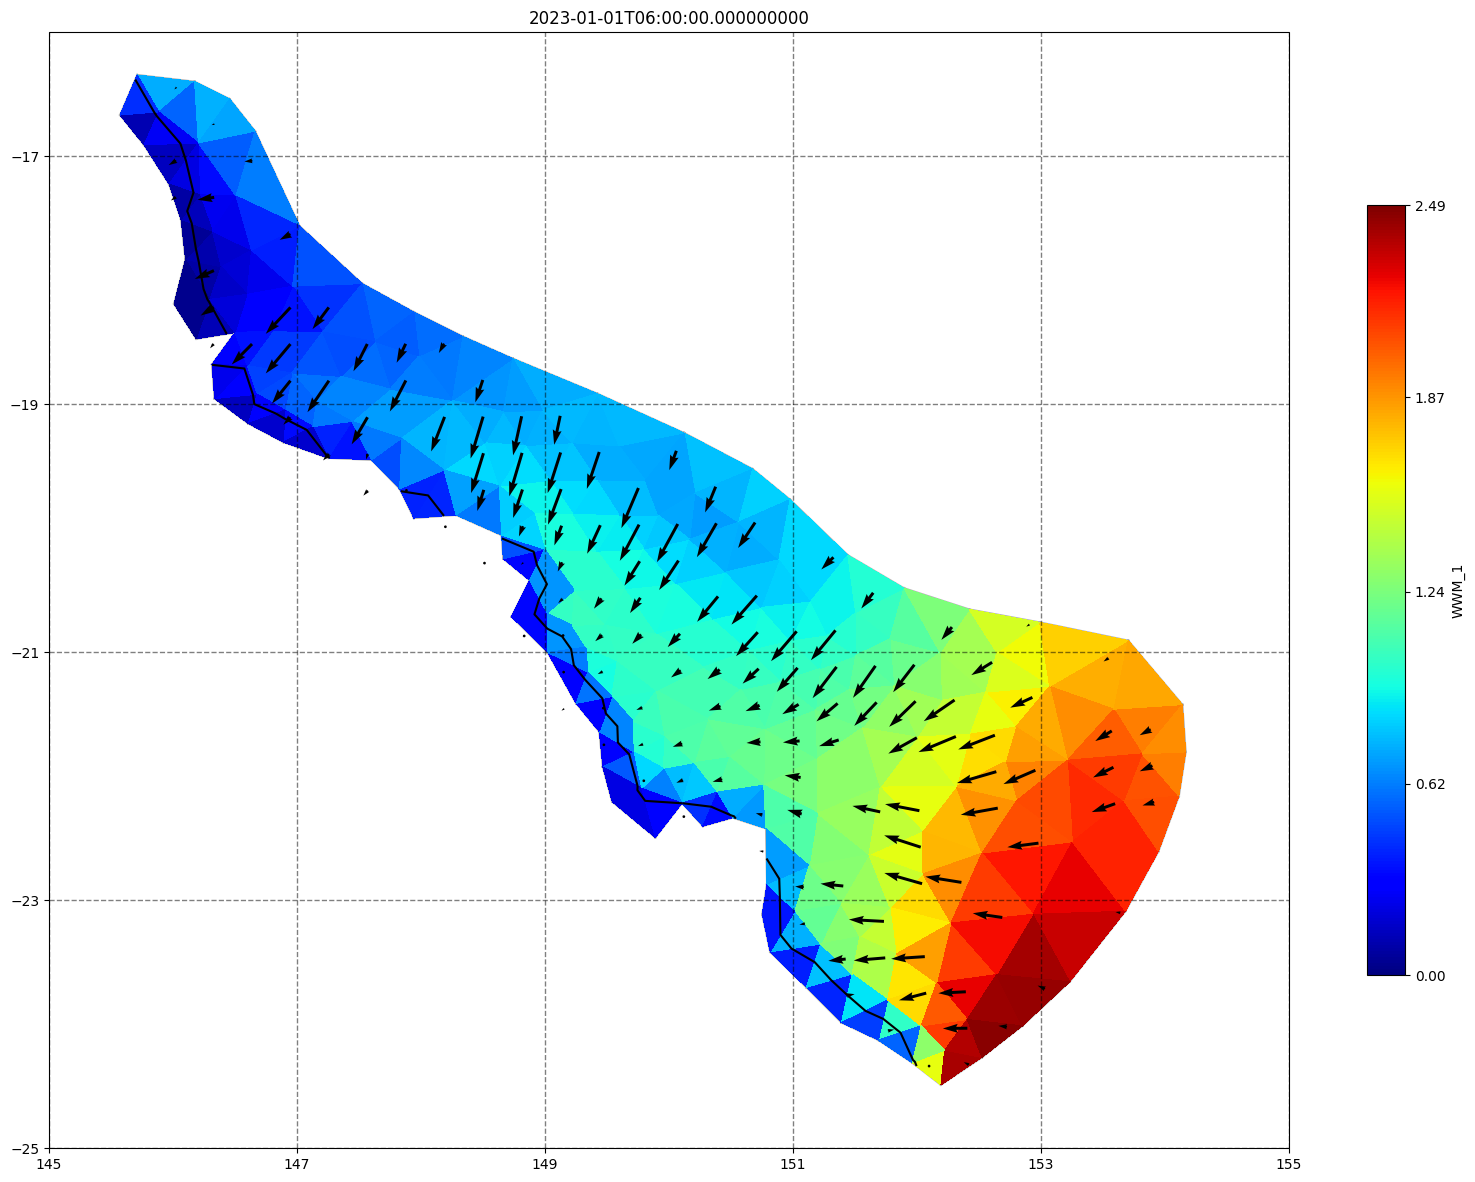

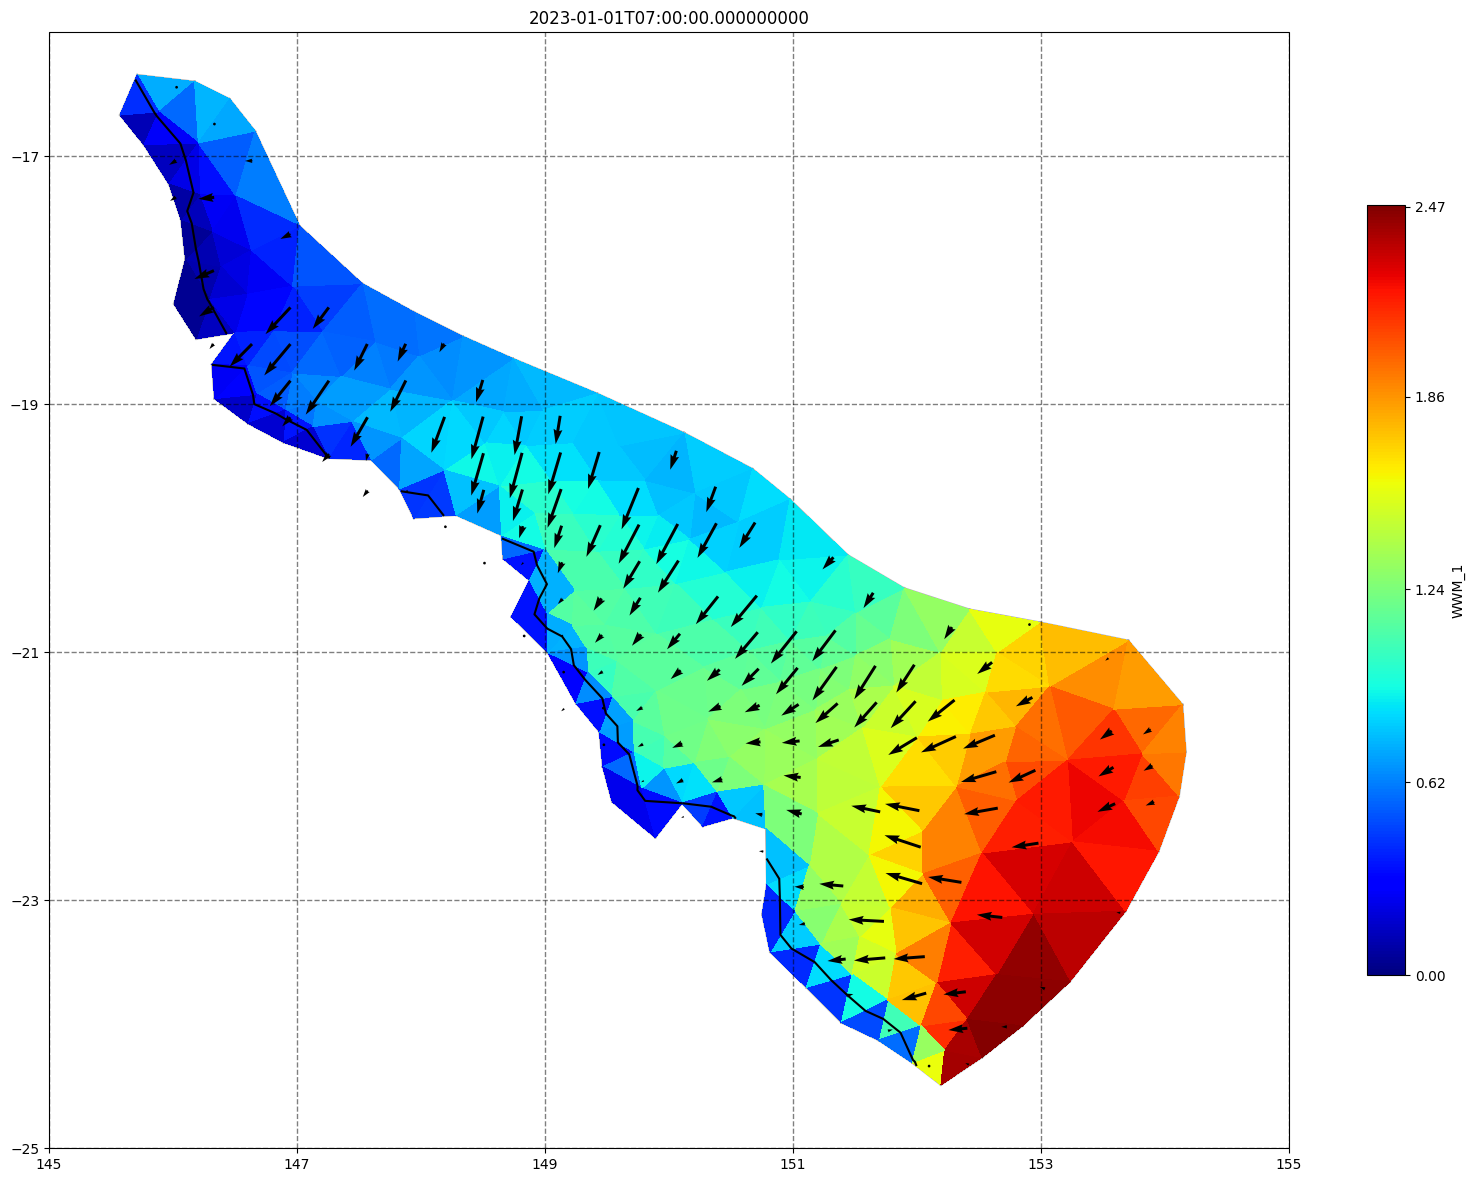

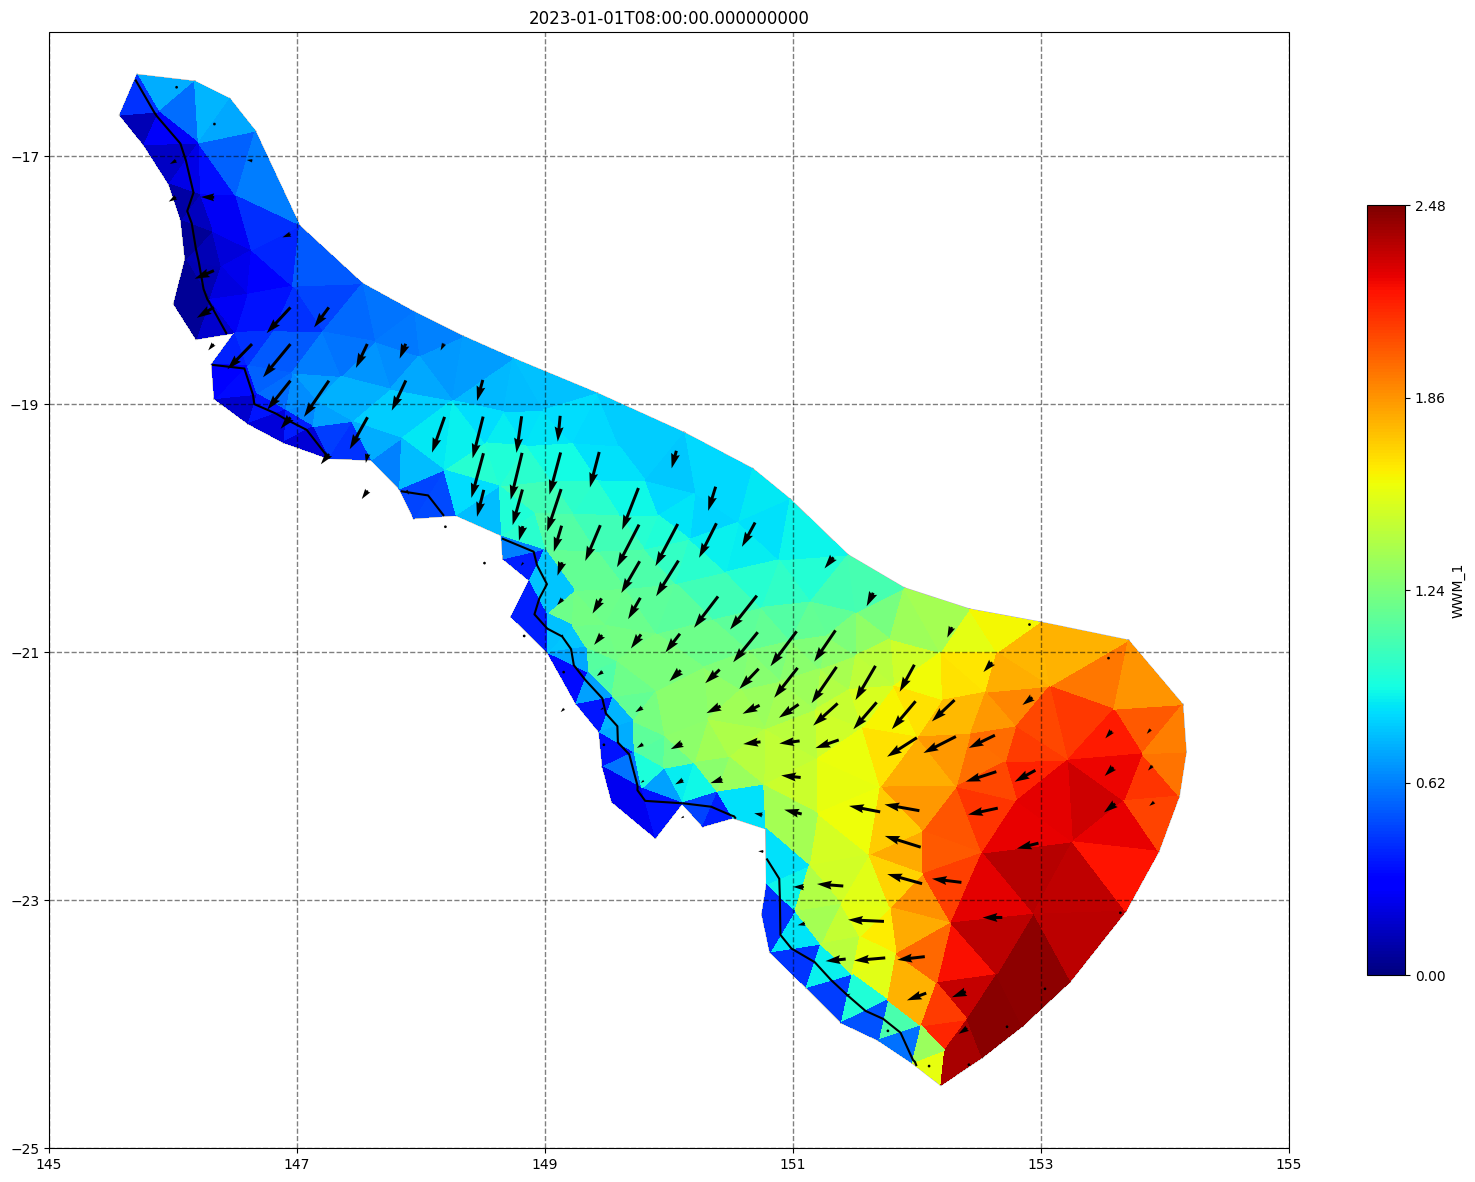

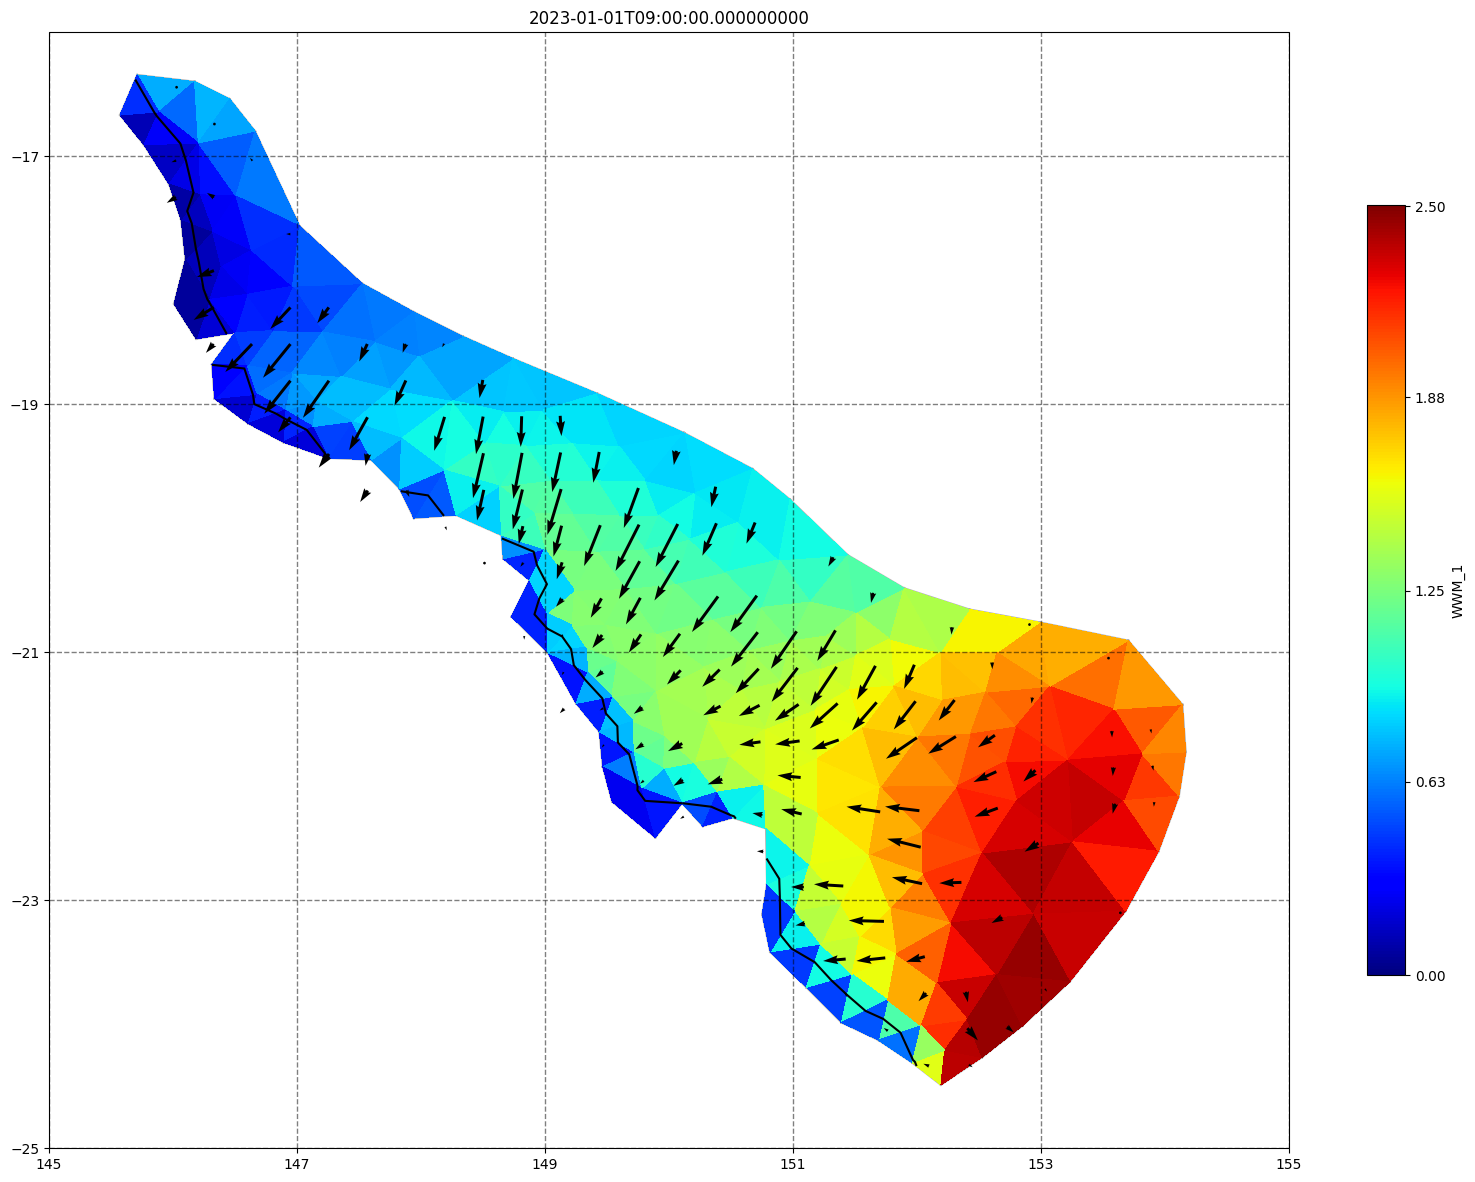

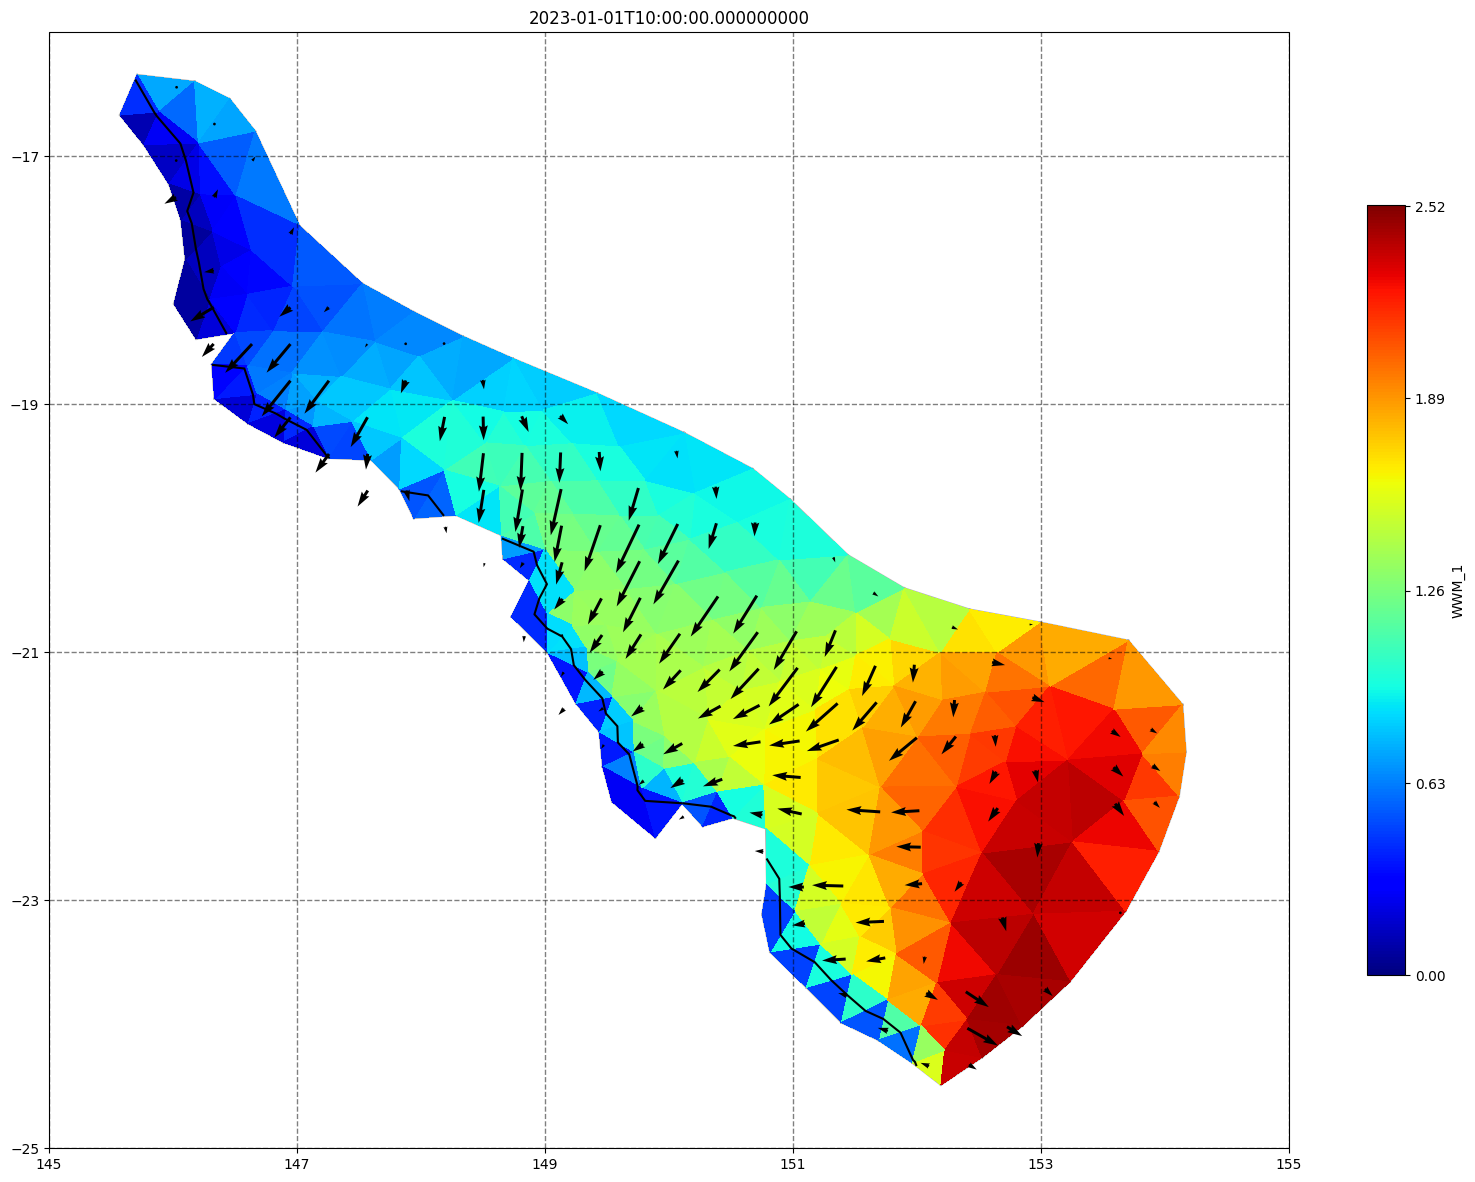

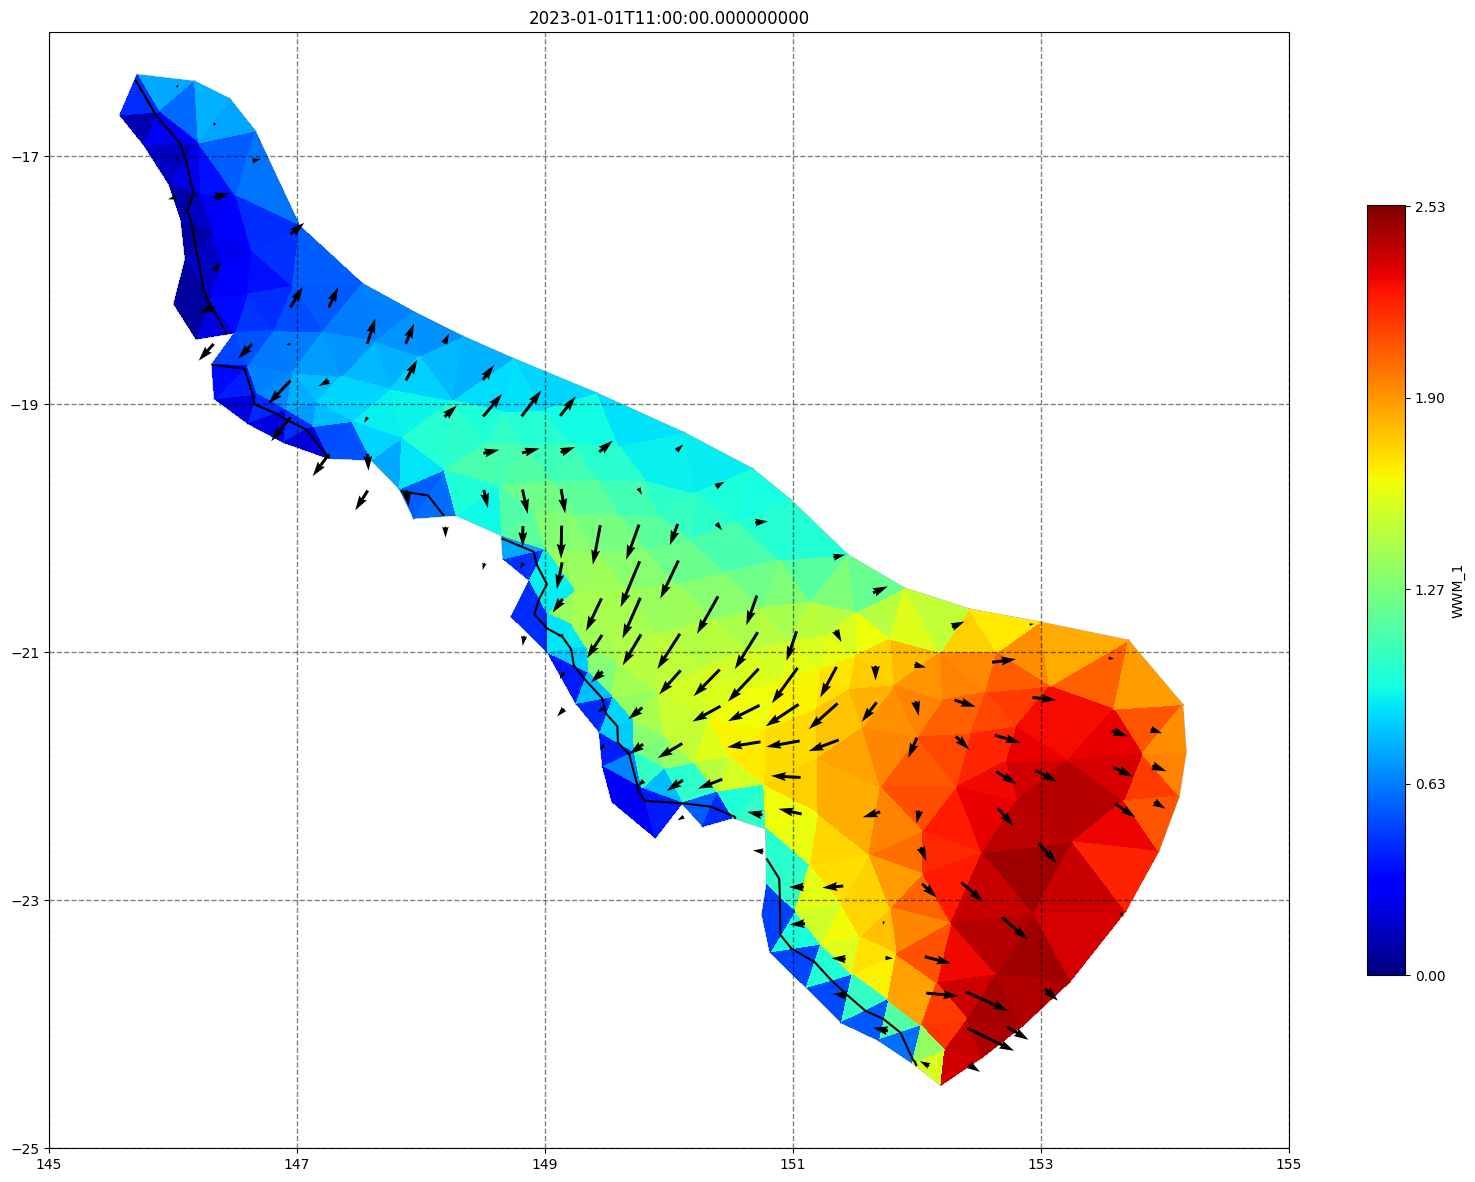

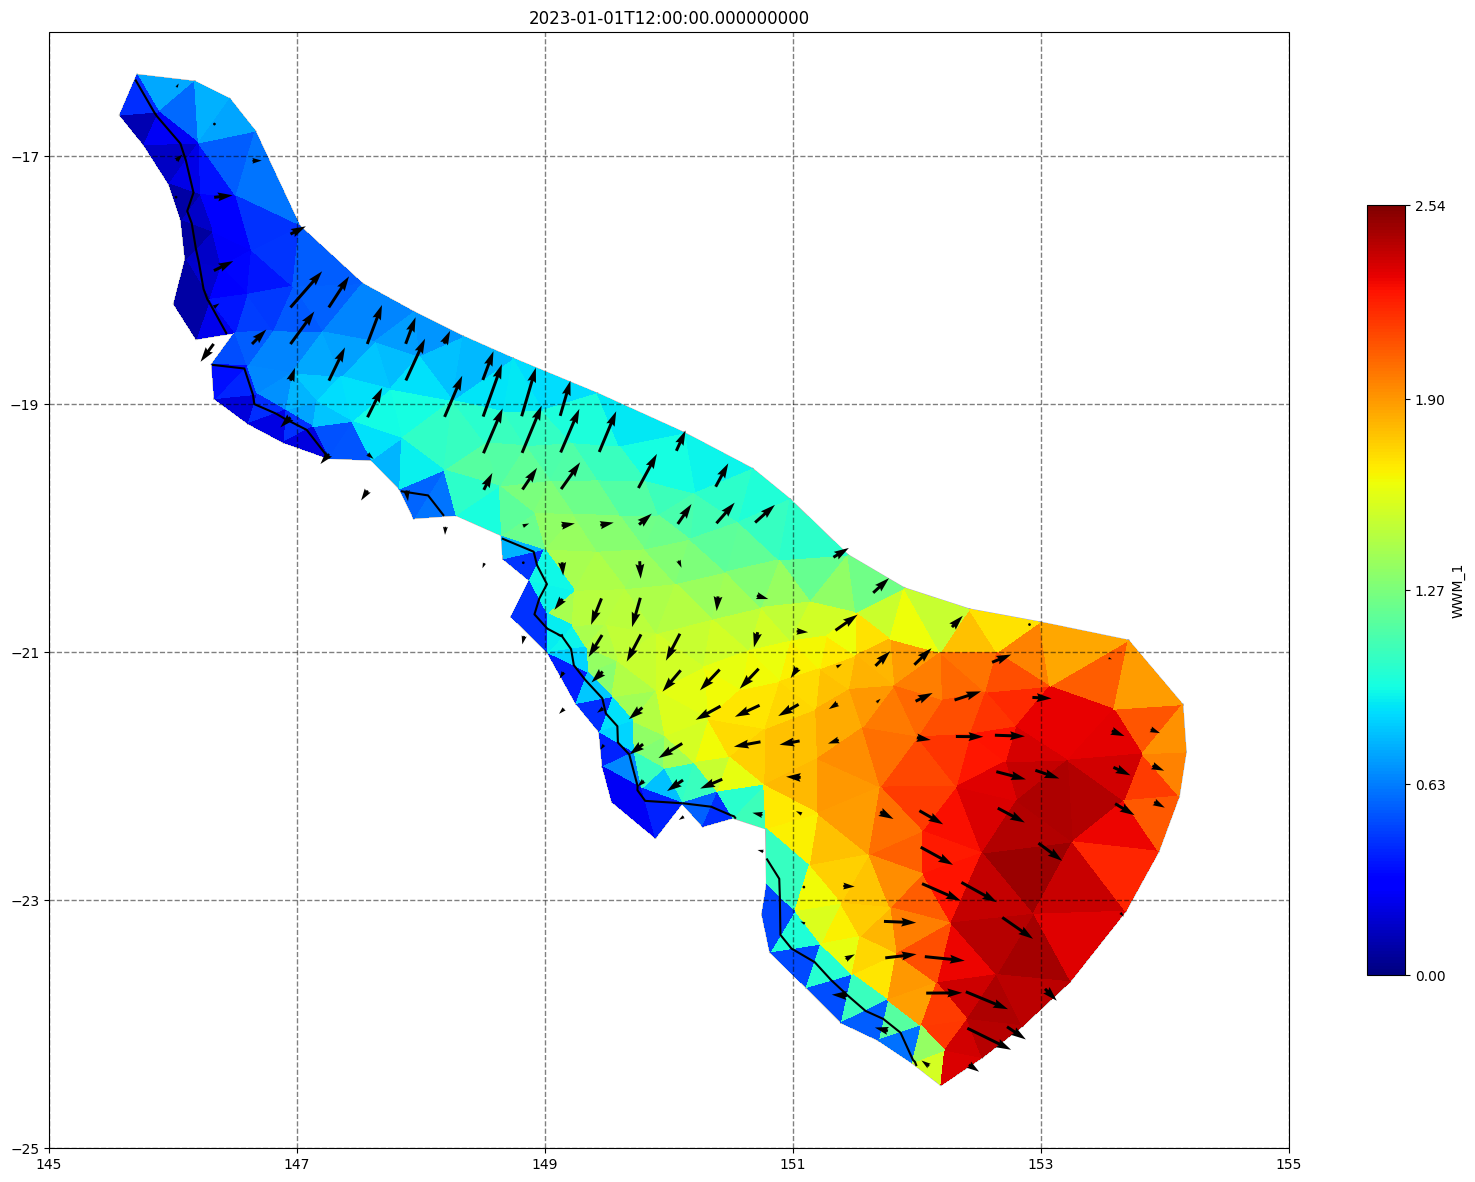

In [34]:
## plot gridded fields - Hs
for ix, time in enumerate(schout.time.values):
    fig, ax=schism_plot(schout, meshtri,'WWM_1', bbox=[145,-25,155,-16], project=True, plotmesh=True, mask=False, time=time,
              vectors=True, contours=[0])
    ax.set_title(time)

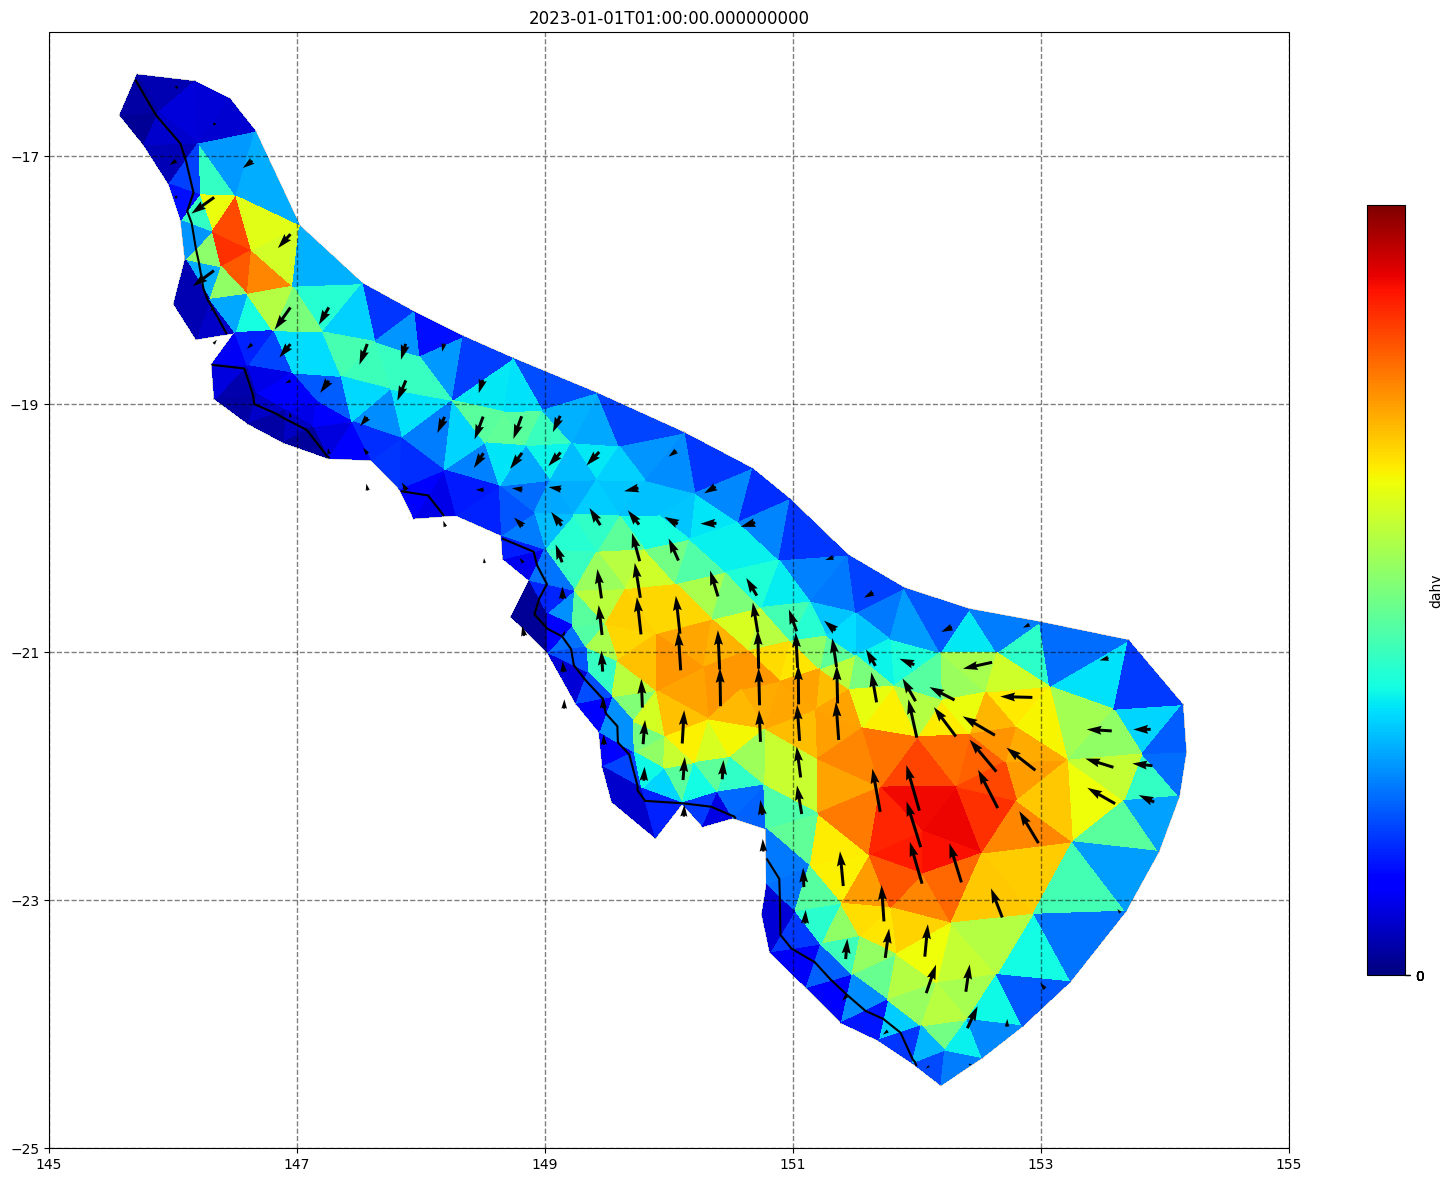

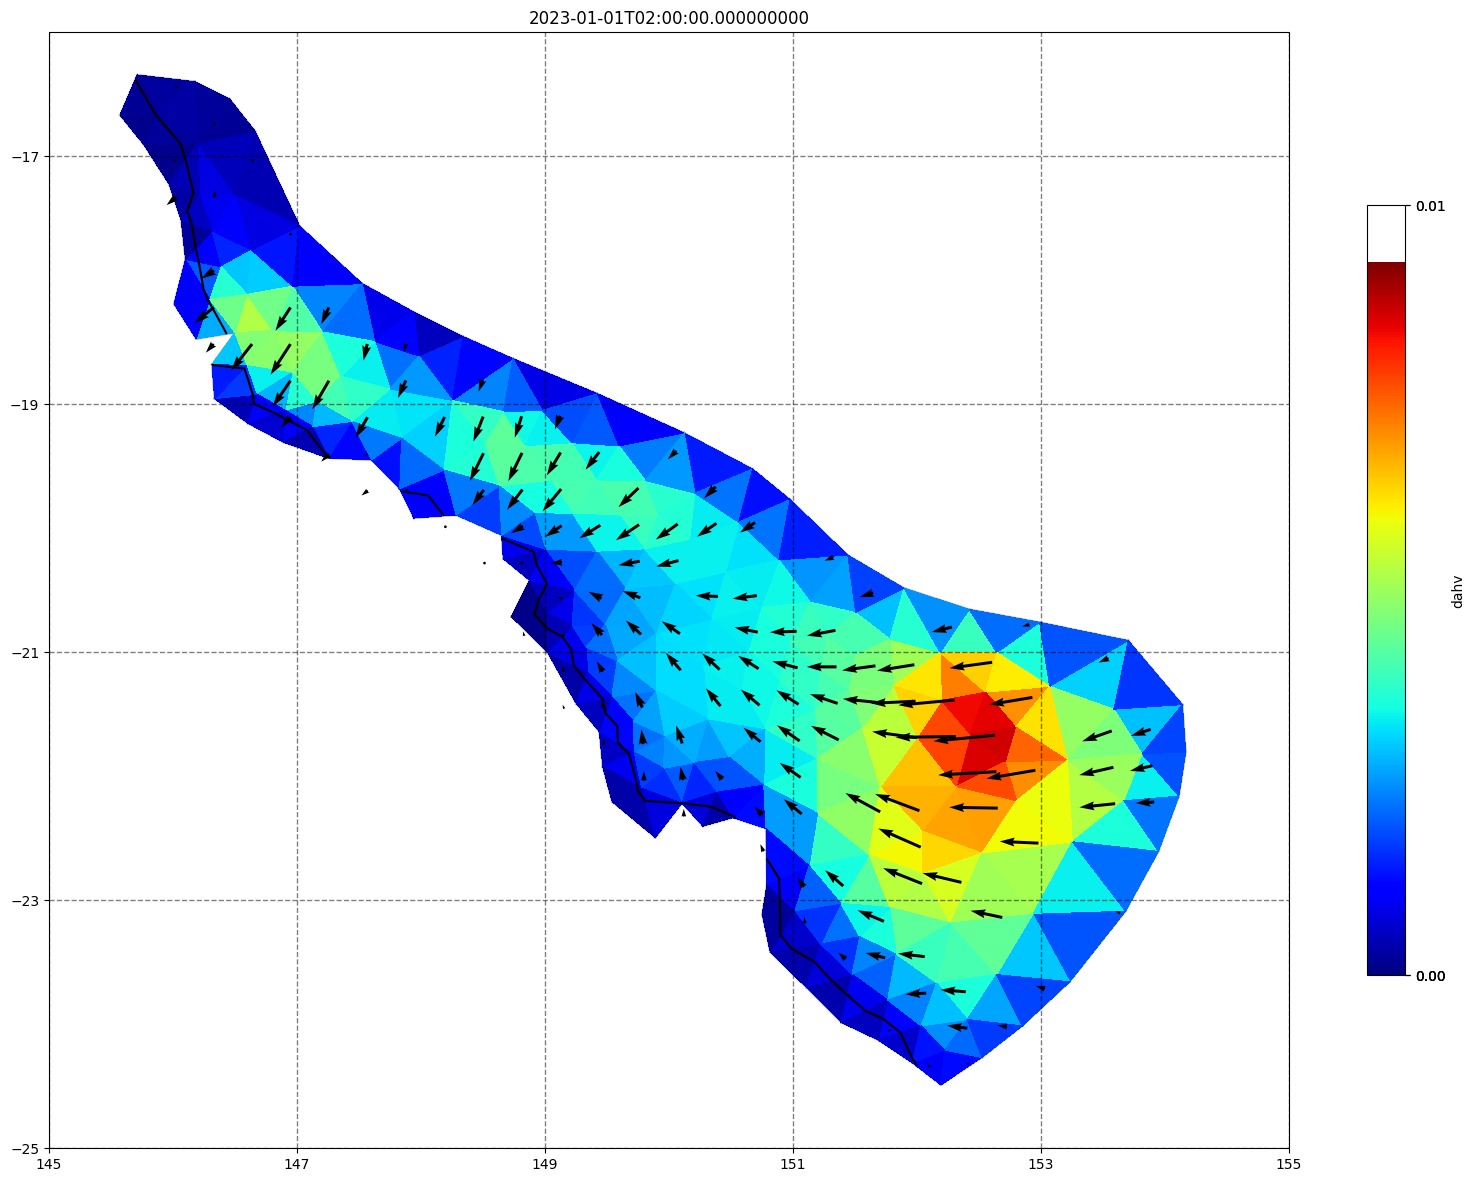

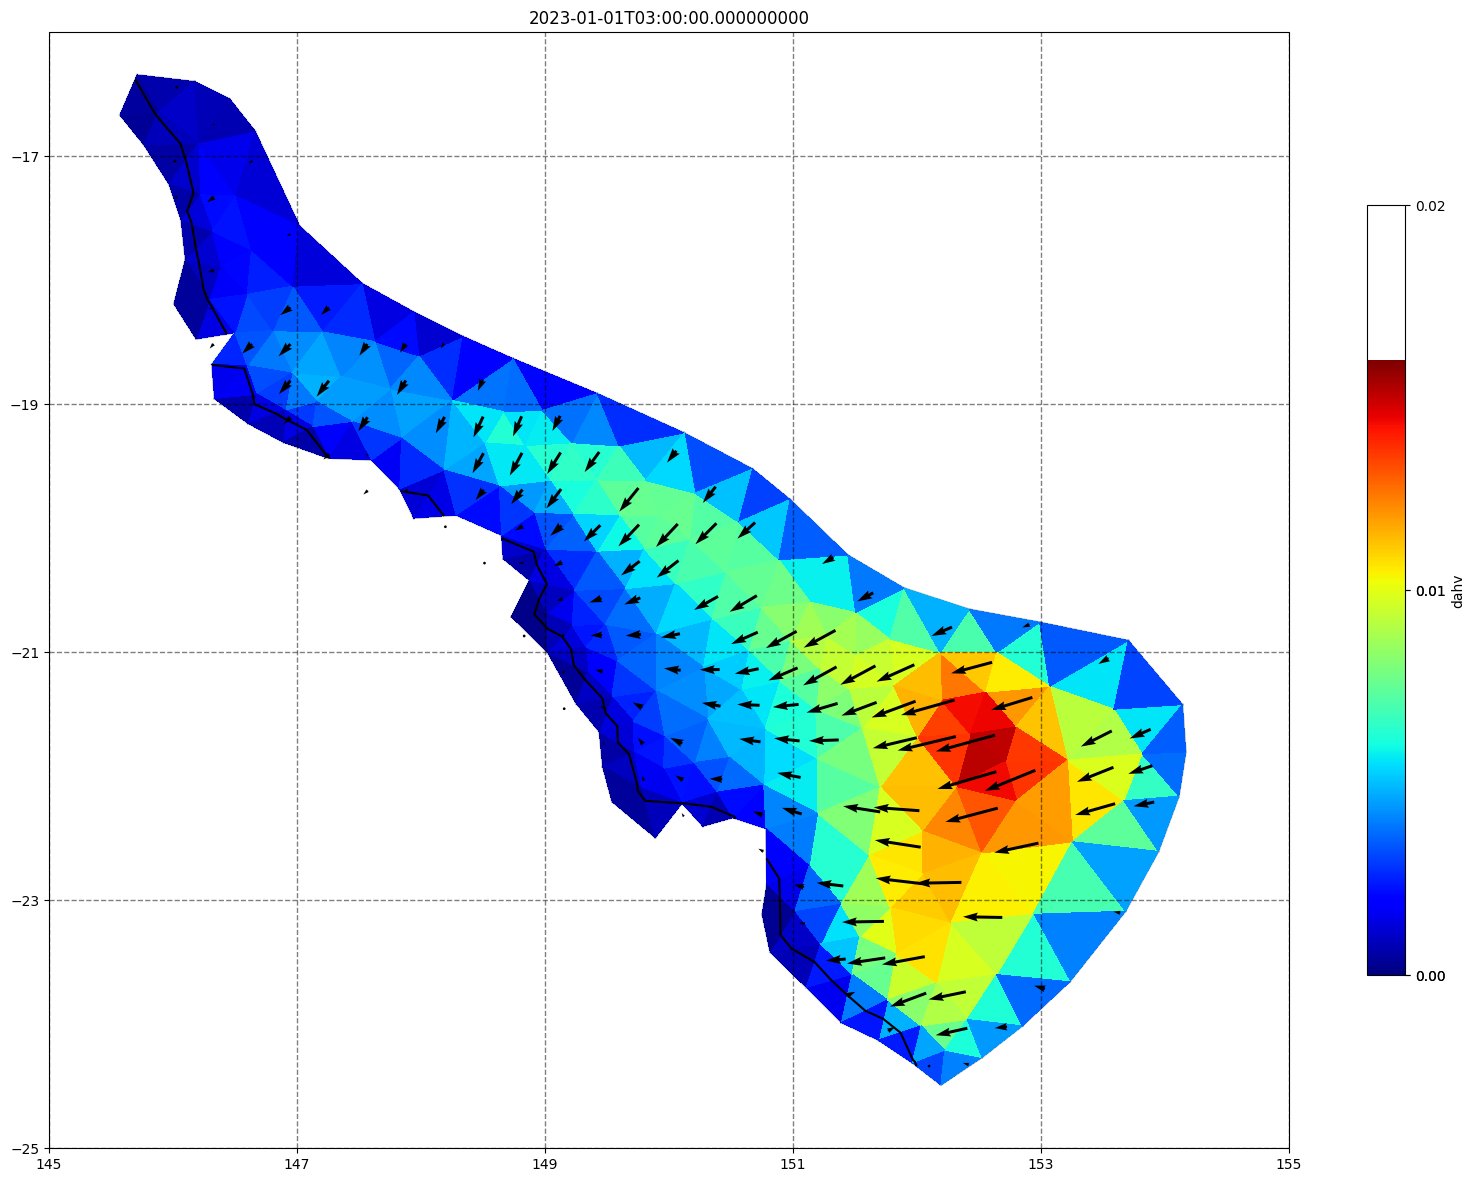

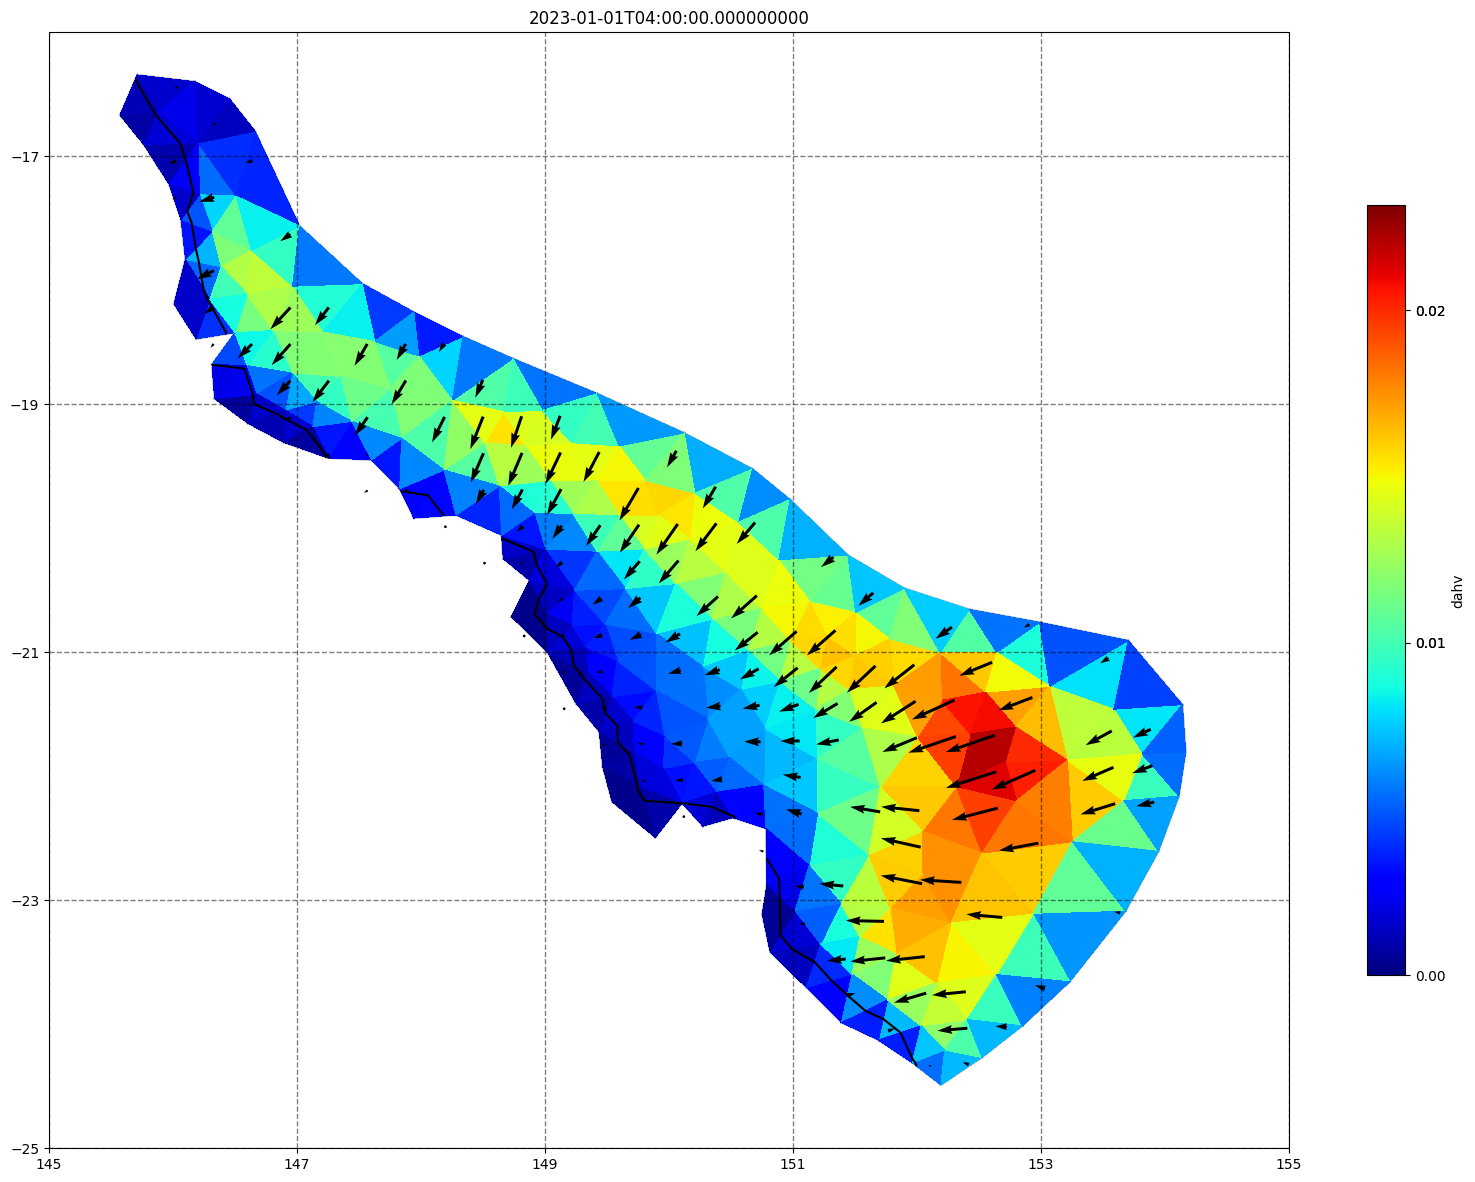

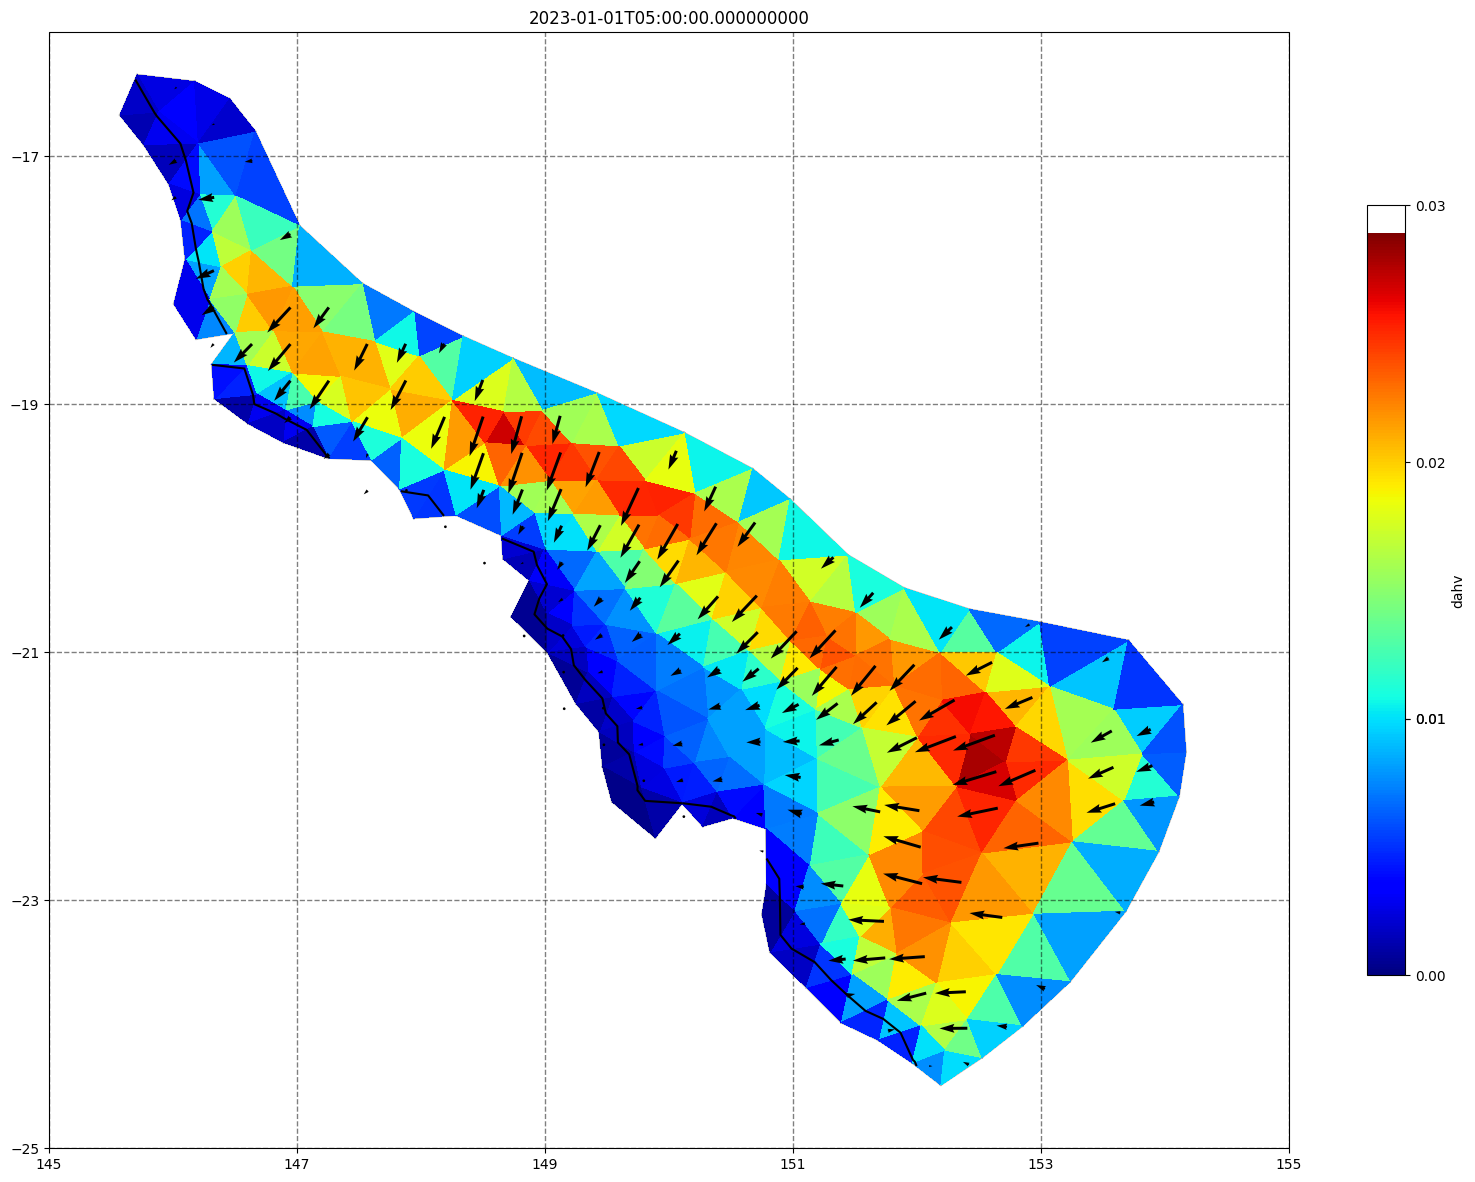

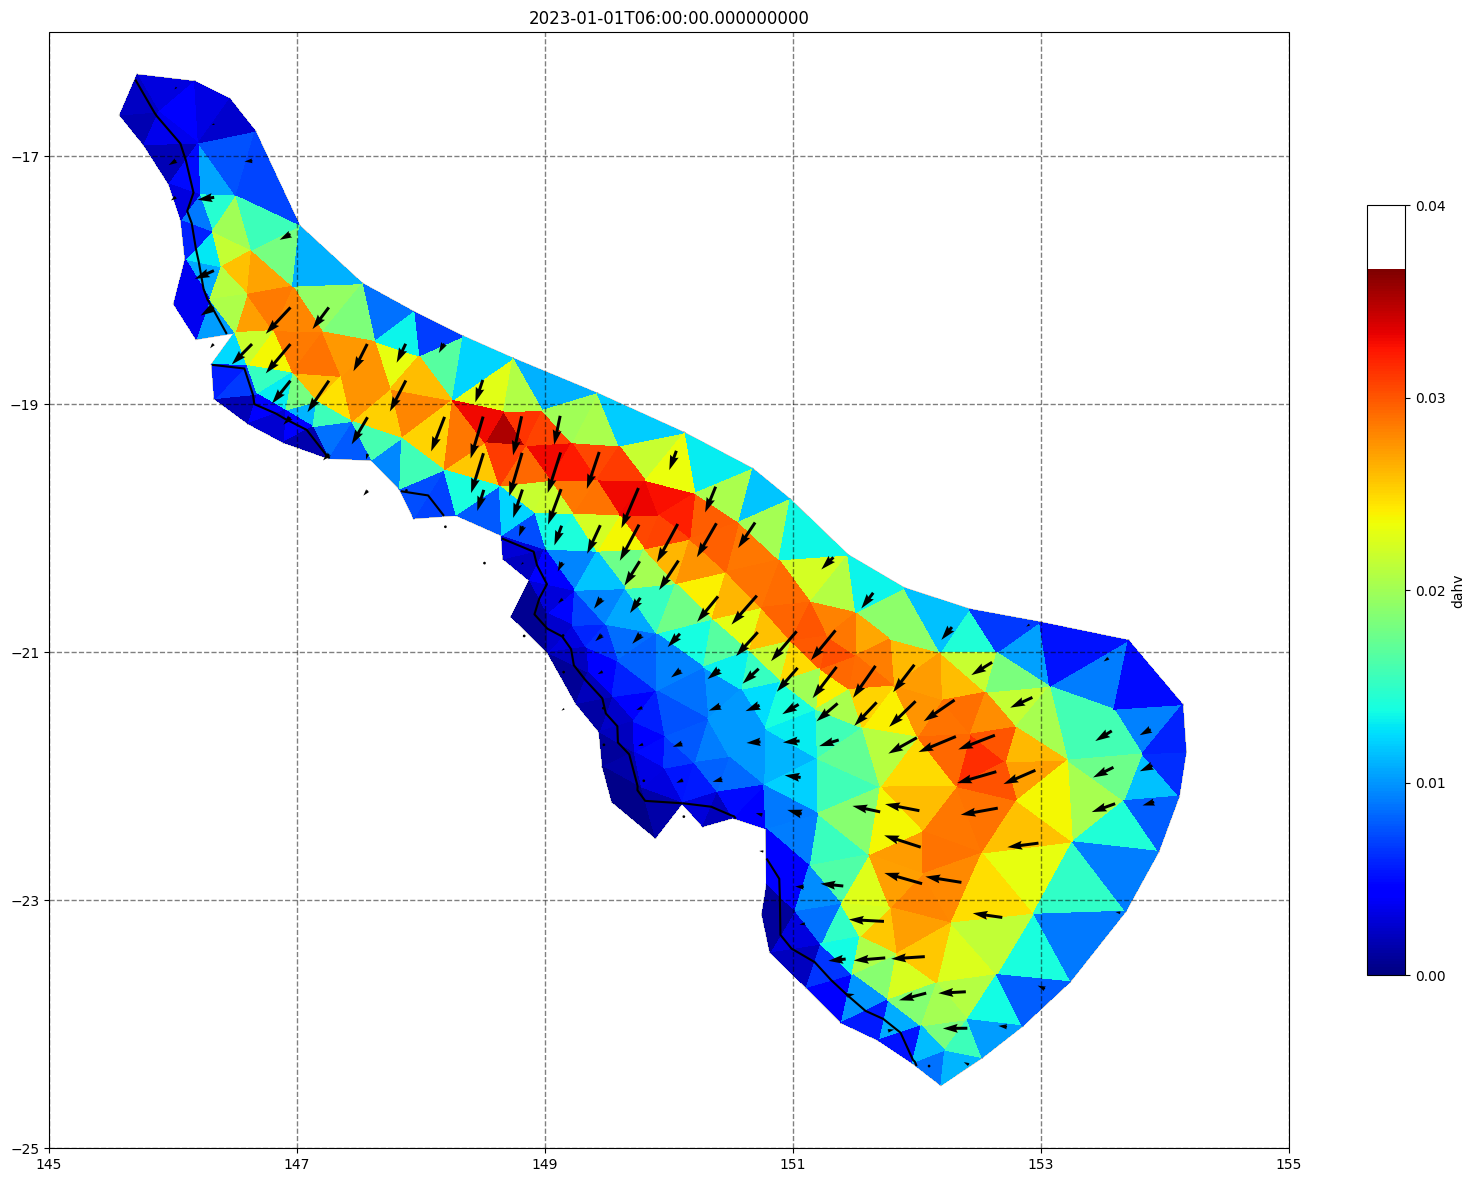

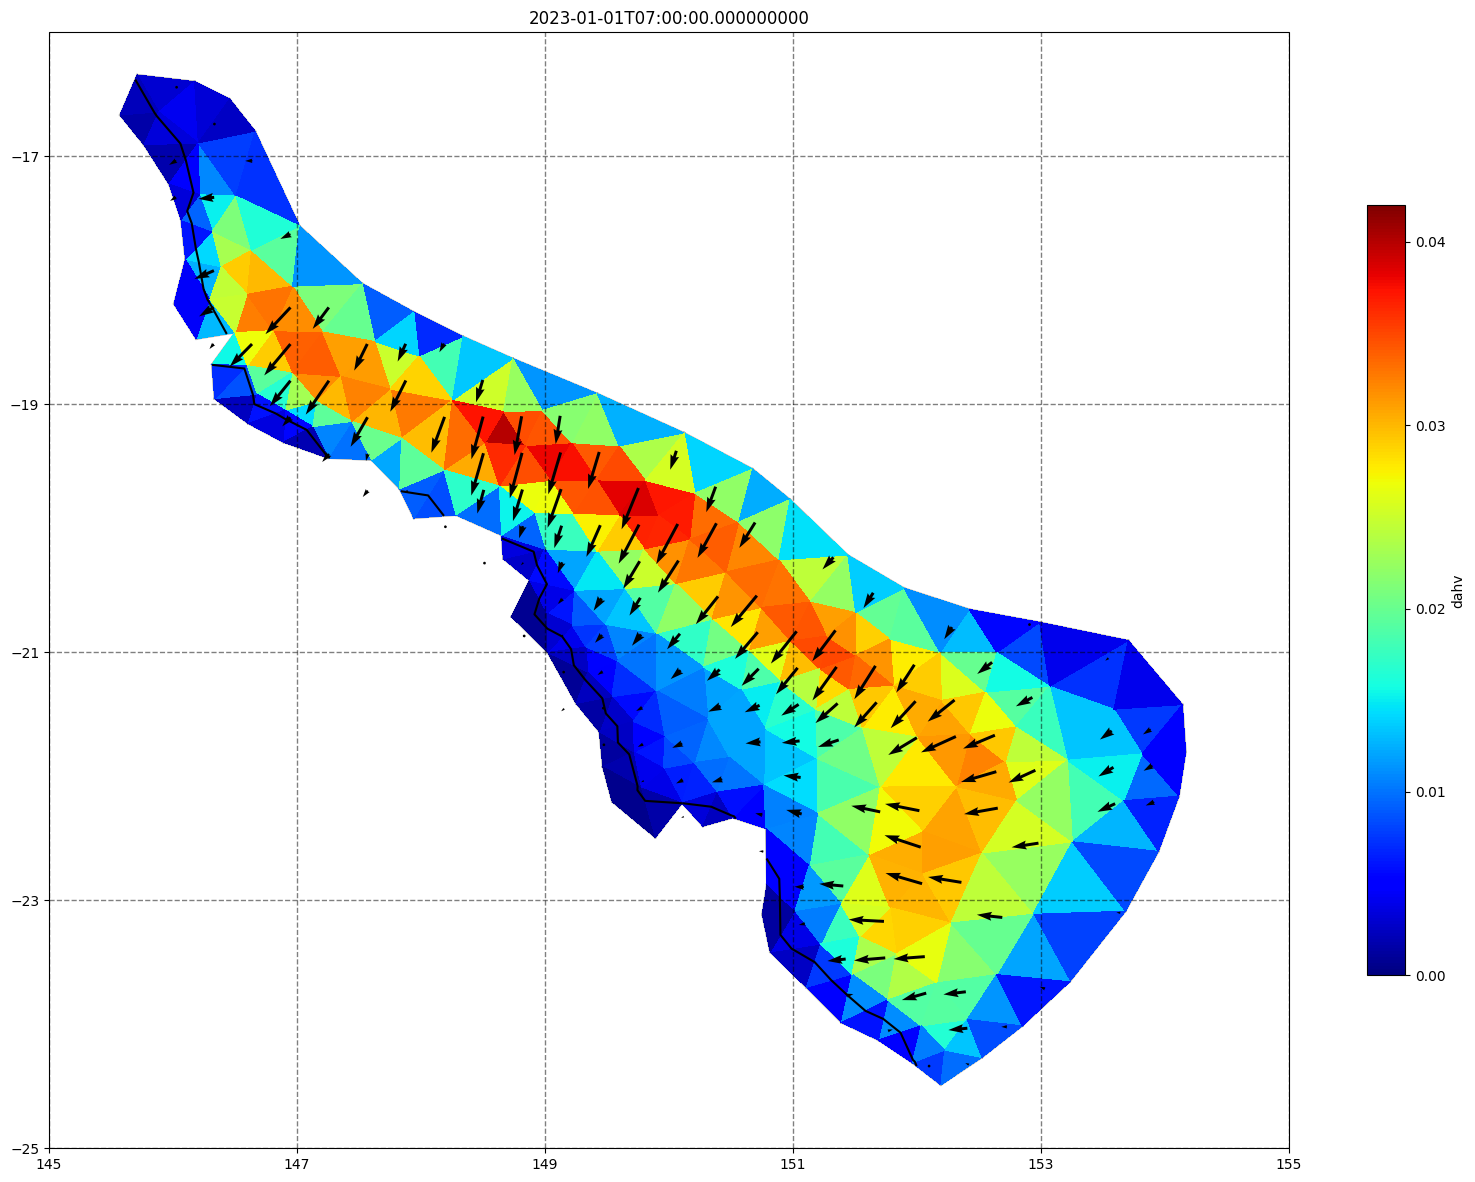

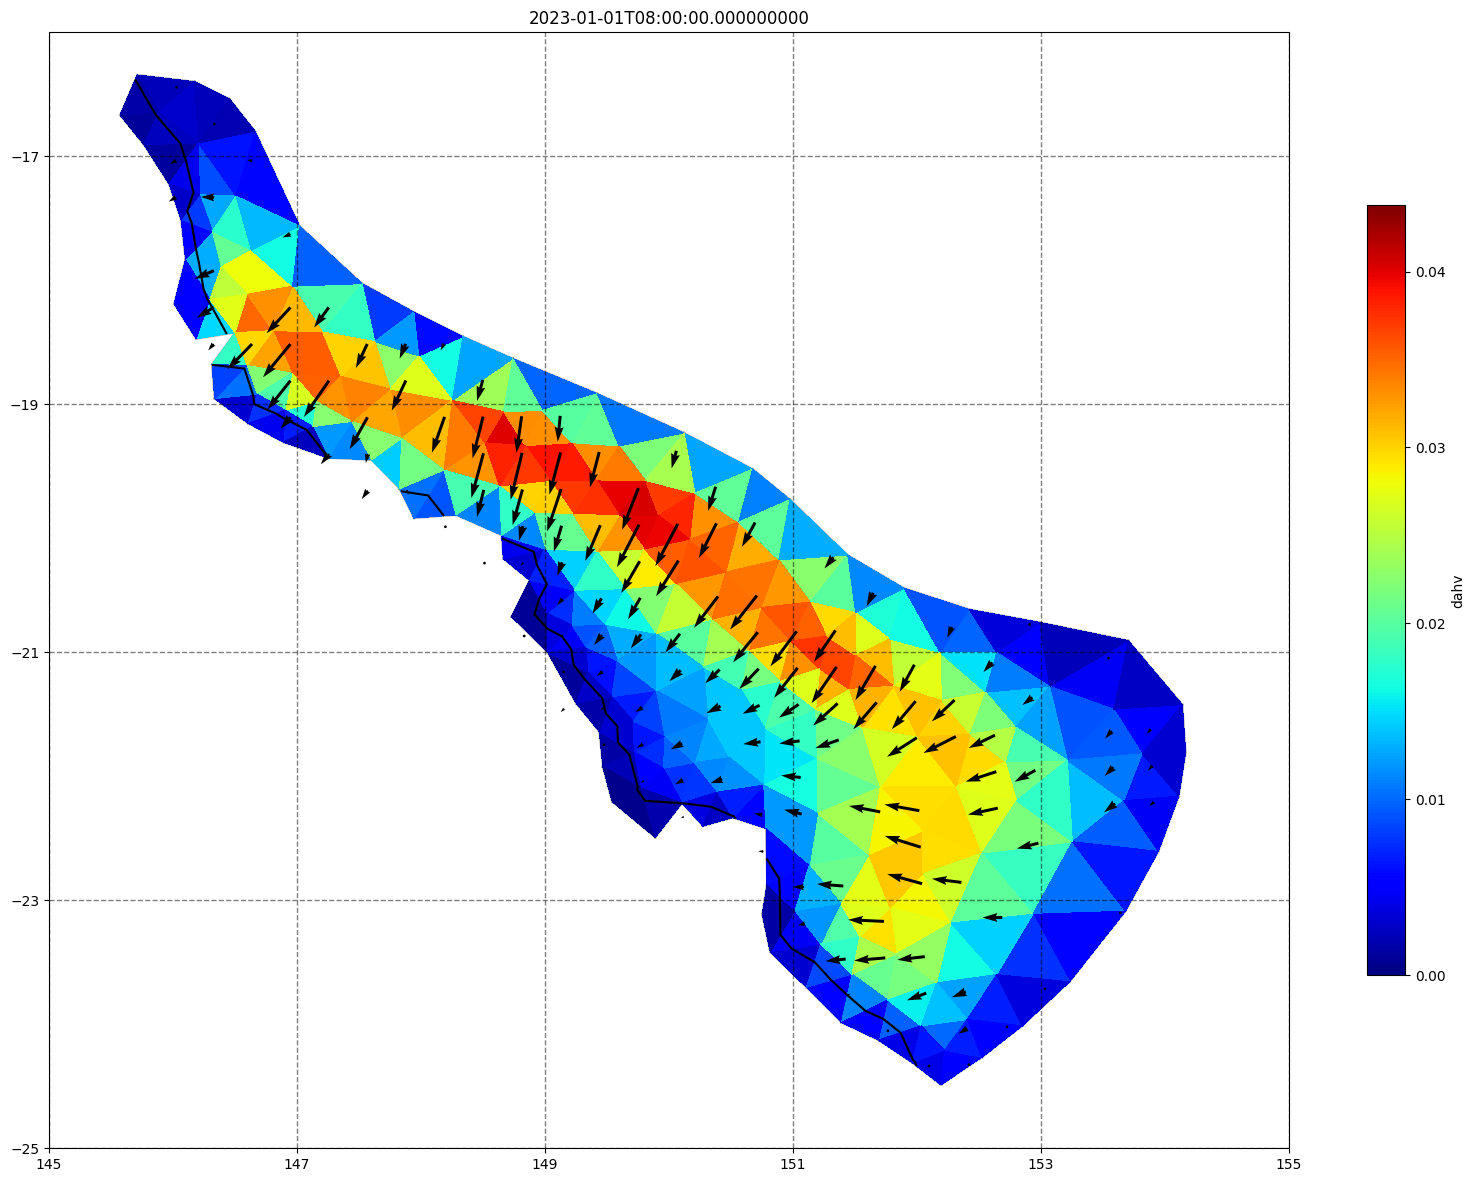

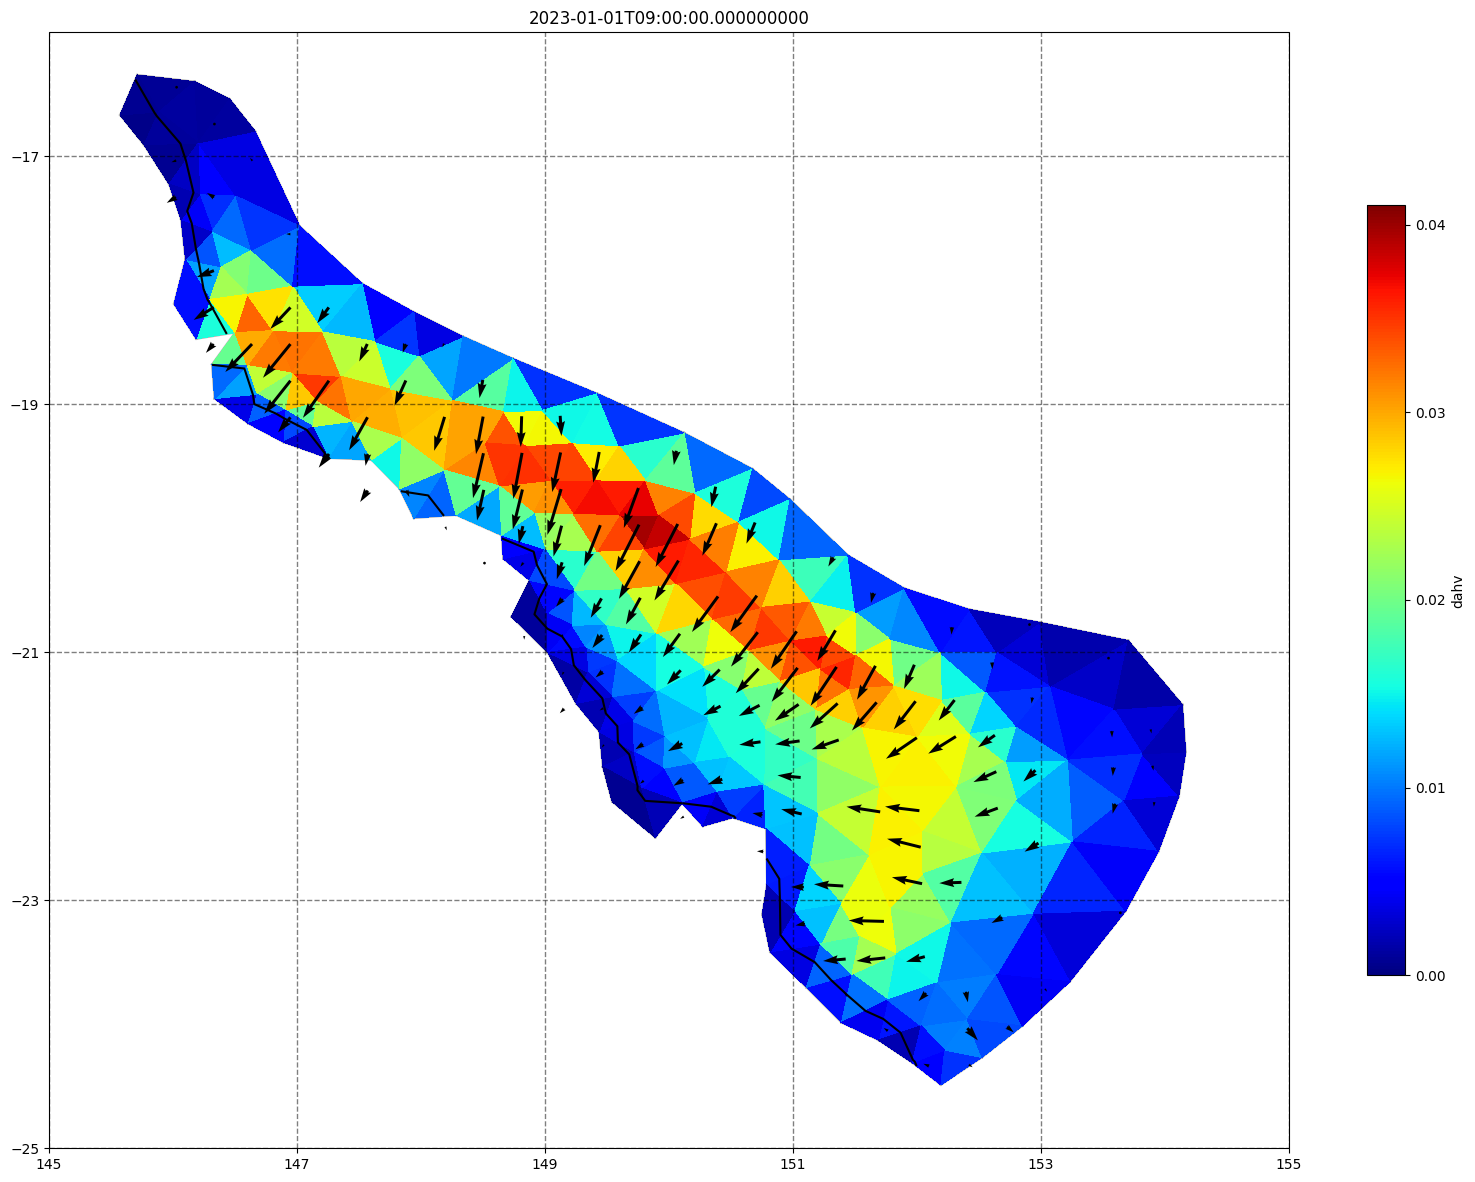

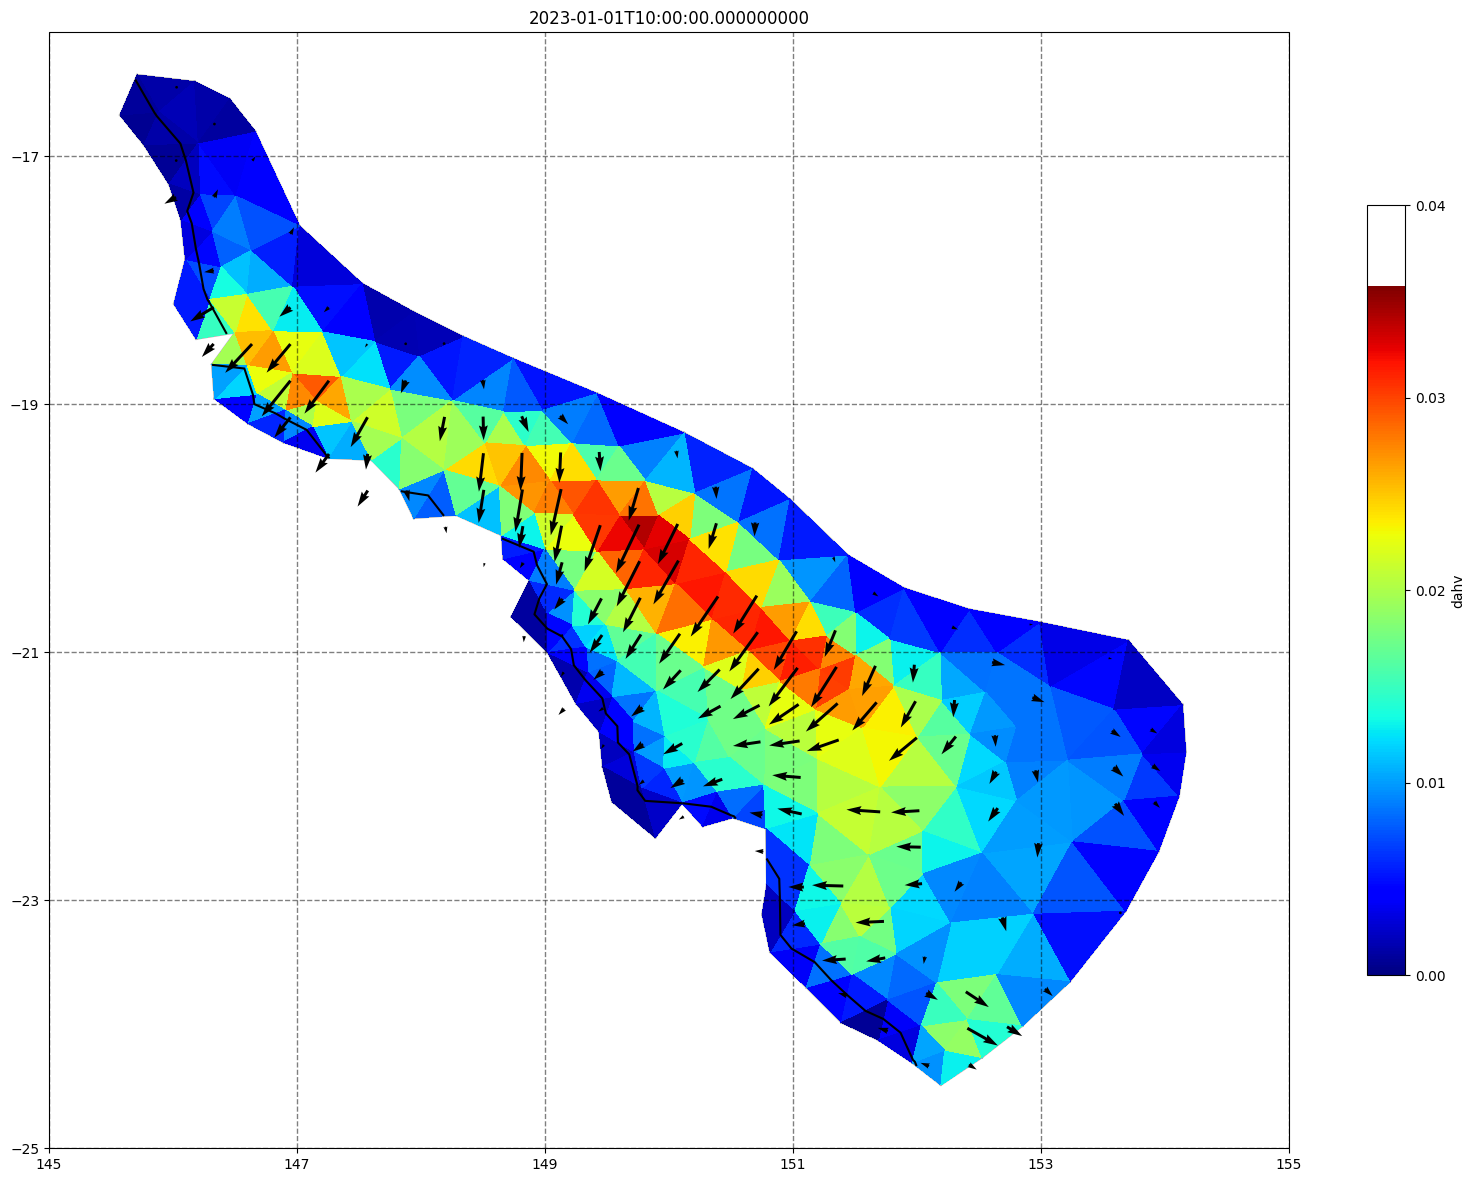

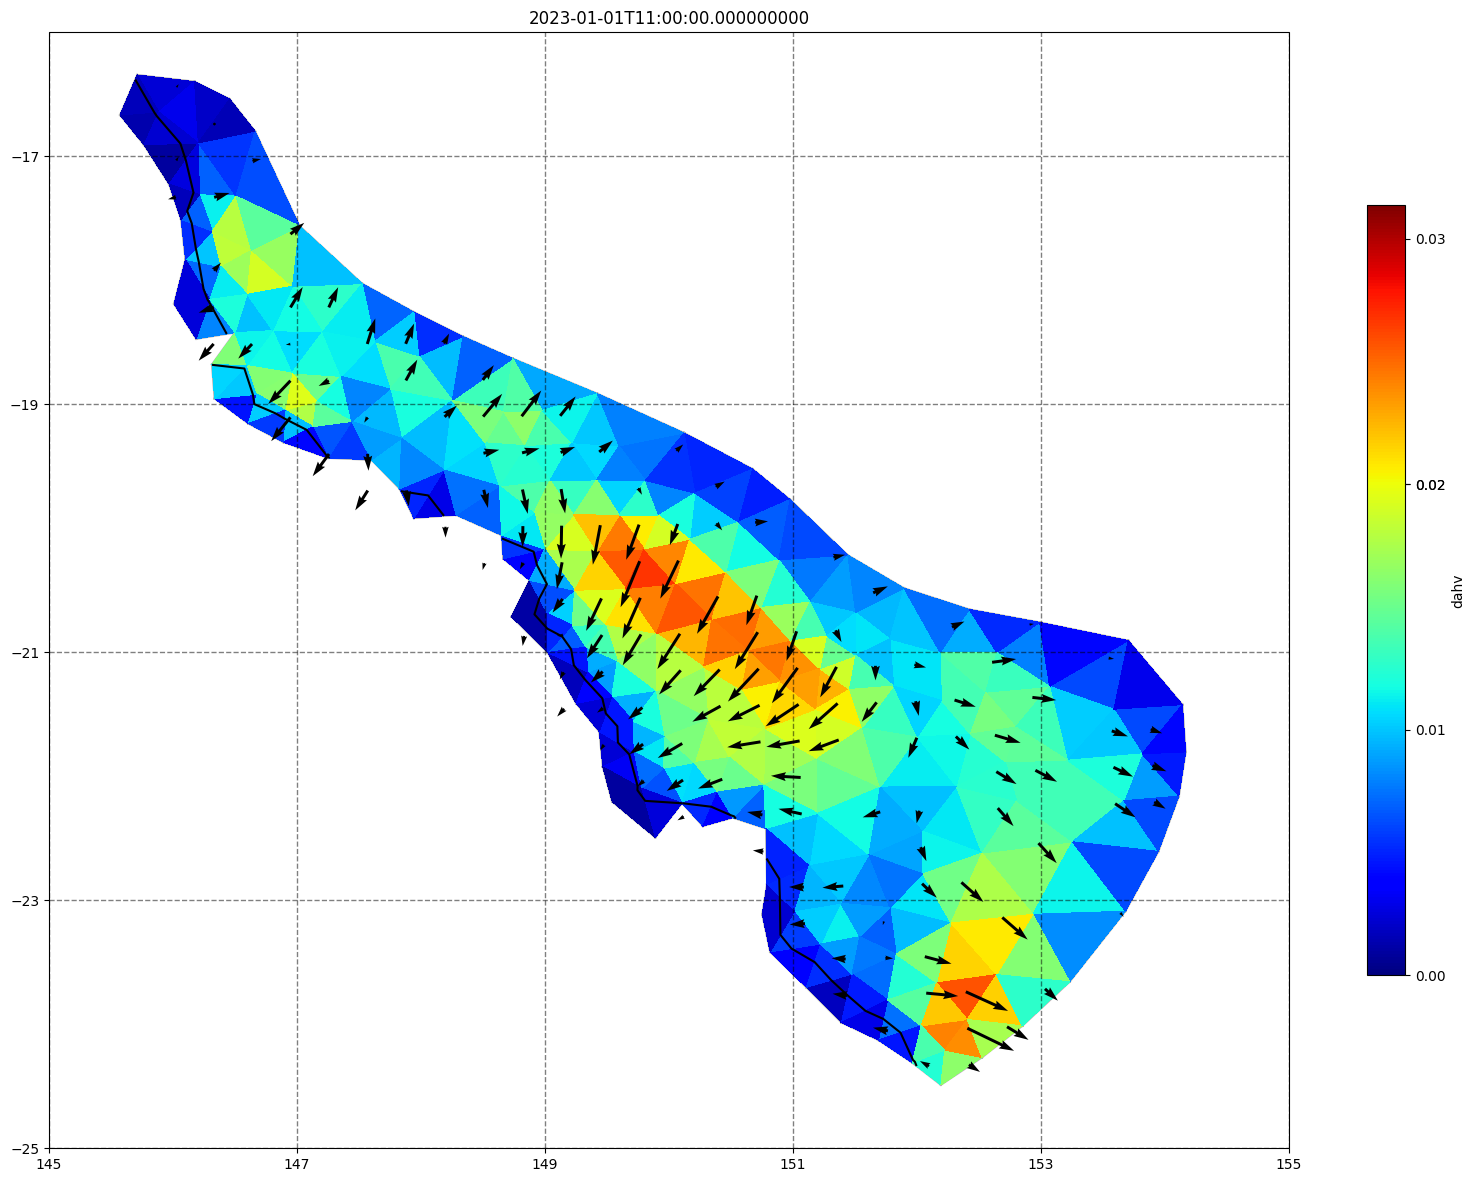

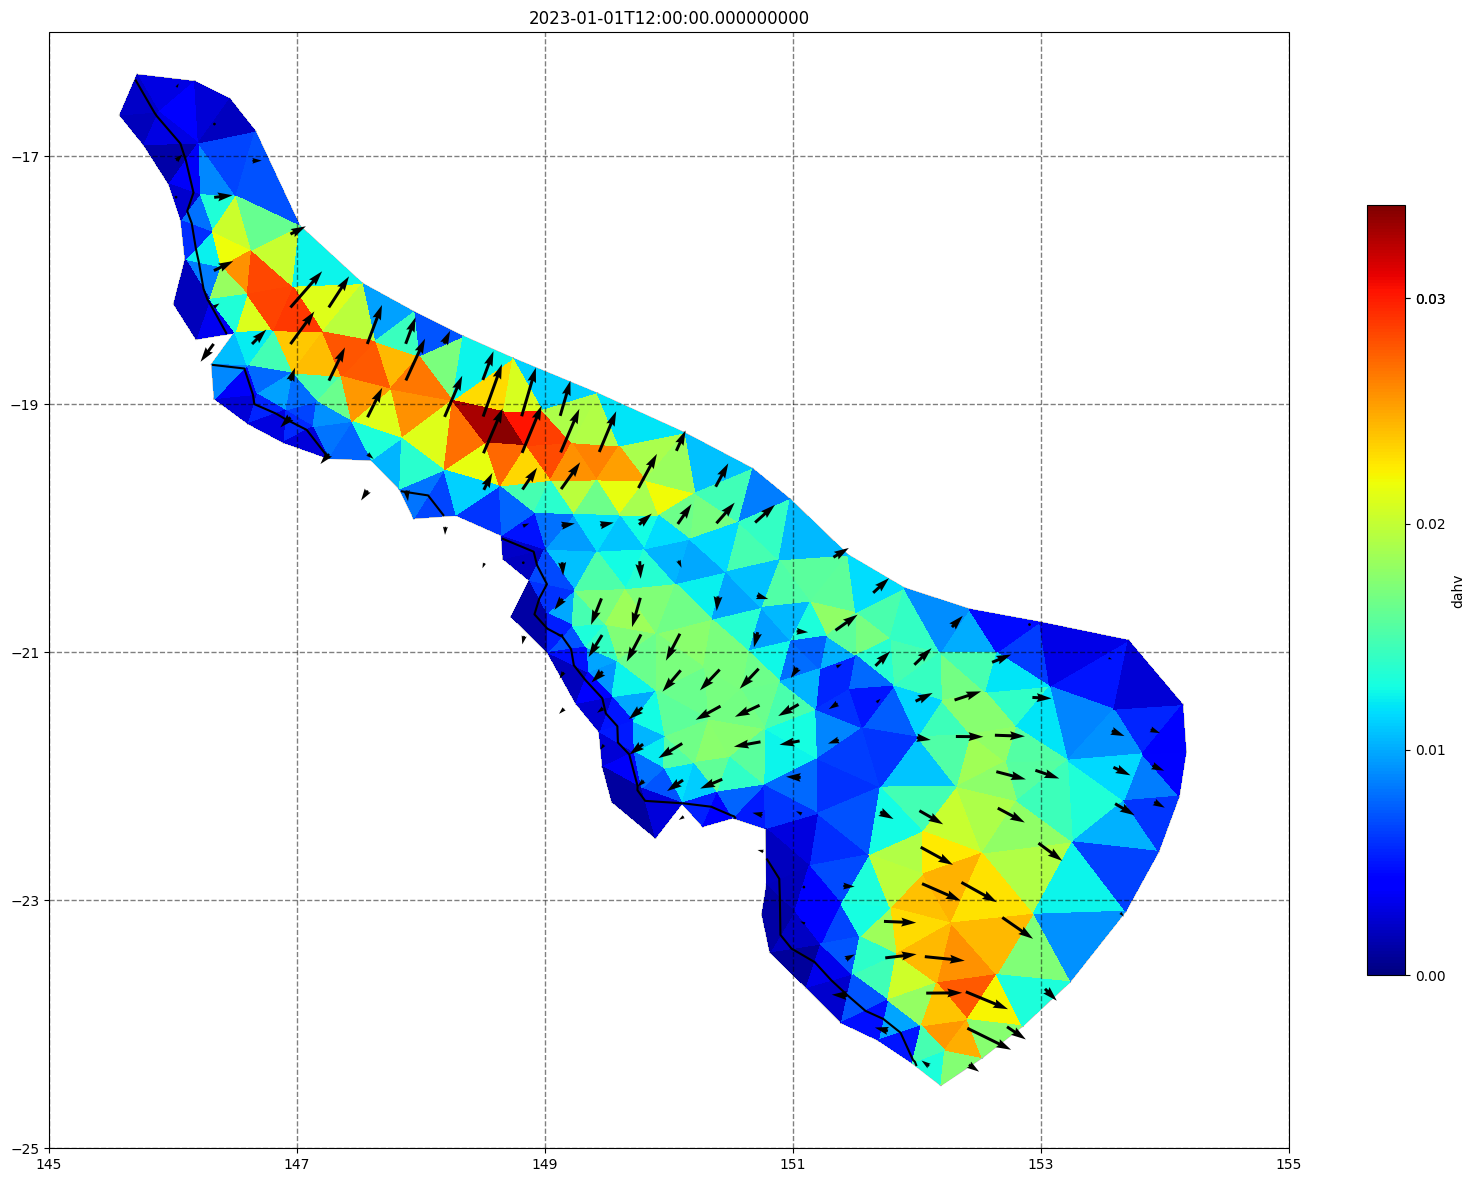

In [35]:
## plot gridded fields - Hs
for ix, time in enumerate(schout.time.values):
    fig, ax=schism_plot(schout, meshtri,'dahv', bbox=[145,-25,155,-16], project=True, plotmesh=True, mask=False, time=time,
              vectors=True, contours=[0])
    ax.set_title(time)

In [36]:
# The full model can be dumped to a configuration file.
import yaml
# dump full model to yaml
with open('model.yaml', 'w') as f:
    yaml.dump(run.model_dump(), f)


In [37]:
!cat model.yaml

config:
  CGPP: F
  CPP: F
  DM: T
  DPEAK: T
  DSPR: T
  HS: T
  KPP: F
  LPP: F
  ORBITAL: F
  PEAKD: T
  PEAKDSPR: T
  TM01: T
  TM02: F
  TPP: T
  TPPD: T
  UBOT: F
  WNPP: F
  ac: T
  brcrYN: ''
  checkout: main
  currYN: '!'
  data:
    atmos:
      air_1:
        buffer: 2.0
        coords:
          s: site
          t: time
          x: longitude
          y: latitude
          z: depth
        crop_data: true
        data_type: sflux_air
        fail_if_missing: true
        filter:
          crop:
            latitude:
              start: -26.4884499831
              stop: -14.343982374700001
            longitude:
              start: 143.572275673
              stop: 156.1662613999
            time:
              start: &id001 2023-01-01 00:00:00
              stop: 2023-01-01 13:00:00
          derived: {}
          rename: {}
          sort:
            coords:
            - latitude
          subset: {}
          timenorm: {}
        id: air_1
        link: false
     

### Running from configuration files. 
The full model dump above looks complex due to the fact that the full model state, including all default value, is written to the model.yaml file. The same model configuration can be achived in a much simpler file by simply specifying non default values. For example, the entire configuration above is specified in the demo.yaml file shown below

In [38]:
!cat demo.yaml

output_dir: schism_declaritive
period:
  start: 20230101T00
  end: 20230101T12
  interval: 3600
run_id: test_schismcsiro
config:
  model_type: schismcsiro
  mesbf: 1
  fricc: 0.067
  param_iof_hydro1: 1 # elevation
  param_iof_hydro2: 1 # mslp
  param_iof_hydro14: 1 # wind speed
  param_iof_hydro16: 1 # surface velocities
  wwm18: 1 # peak wave direction
  wwm1: 1 # significant wave height
  wwm9: 1 # peak period
  grid:
    grid_type: schism
    hgrid:
      id: hgrid
      model_type: data_blob
       #source: ../../tests/schism/test_data/hgrid.gr3
      source: ../../tests/schism/test_data/hgrid_20kmto60km_rompyschism_testing.gr3
    manning: 1
  data:
    data_type: schism
    atmos:
      air_1:
        data_type: sflux_air
        source: 
          model_type: file
          uri: "../../tests/schism/test_data/era5.nc"
        uwind_name: u10
        vwind_name: v10
        prmsl_name: msl
        filter:
          sort: {coords: [latitude]}
        buffer: 5
    ocean:
      ele

In [39]:
# This can be loaded and used to instatiate the model object and run as above, e.g
import yaml
demo_config = yaml.load(open('demo.yaml', 'r'), Loader=yaml.FullLoader)
run = ModelRun(**demo_config)
# Remove old run if it exists
if run.output_dir.exists():
    rmtree(run.output_dir)
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schismcsiro
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: None
	Include End: True

output_dir: schism_declaritive
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_declaritive
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_declaritive/test_

'/home/tdurrant/source/rompy/rompy-base/notebooks/schism/schism_declaritive/test_schismcsiro'

In [40]:
# Alternatively, this same config can be run directly using the rompy cli
!rm -fr schism_declaritive #remove previous run
!rompy schism demo.yaml

/home/tdurrant/.virtualenvs/rompy-base-xqus/lib/python3.12/site-packages/pyschism/forcing/hycom/gofs.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw
/home/tdurrant/.virtualenvs/rompy-base-xqus/lib/python3.12/site-packages/pydantic/_internal/_model_construction.py:64: UserWarning: `validate_rheol_steps` overrides an existing Pydantic `@model_validator` decorator
  warnings.warn(f'`{k}` overrides an existing Pydantic `{existing.decorator_info.decorator_repr}` decorator')
INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schismcsiro
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: None
	Include End: True

output_dir: schism_declaritive
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating 